In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors  
from rdkit.Chem import Lipinski
from rdkit import DataStructs
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

import pubchempy as pcp
#from IPython.display import Imag

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestRegressor

#import torch
from scipy import stats
import os

import joblib
import json


# Generate SMILES if needed

In [3]:
solvent_names_bdo = pd.read_csv('results-bdo.log', sep='|')
solvent_names_wat = pd.read_csv('results-wat.log', sep='|')

# Remove some unwanted space
solvent_names_bdo.columns = solvent_names_bdo.columns.str.strip()
solvent_names_bdo['Solvent Name'] = [ s.strip()[1:-1] for s in solvent_names_bdo['Solvent Name']]
solvent_names_wat.columns = solvent_names_wat.columns.str.strip()
solvent_names_wat['Solvent Name'] = [ s.strip()[1:-1] for s in solvent_names_wat['Solvent Name']]
display(solvent_names_bdo,solvent_names_wat)

,Energy,Free Energy,JobID,Solvent Name
0,-308.870246,-308.760704,job_1,"1,1,1-TRICHLOROETHANE"
1,-308.869345,-308.759776,job_10,1-BROMOPENTANE
2,-308.866908,-308.757184,job_100,"E-1,2-DICHLOROETHENE"
3,-308.870935,-308.761615,job_101,"Z-1,2-DICHLOROETHENE"
4,-308.871052,-308.761796,job_102,DICHLOROMETHANE
...,...,...,...,...
174,-308.866035,-308.756169,job_95,CIS-DECALIN
175,-308.866340,-308.756449,job_96,N-DECANE
176,-308.869782,-308.760424,job_97,DIBROMOMETHANE
177,-308.868239,-308.758441,job_98,DIBUTYLETHER


,Energy,Free Energy,JobID,Solvent Name
0,-76.433265,-76.429968,job_1,"1,1,1-TRICHLOROETHANE"
1,-76.432932,-76.429628,job_10,1-BROMOPENTANE
2,-76.431265,-76.427971,job_100,"E-1,2-DICHLOROETHENE"
3,-76.434679,-76.431476,job_101,"Z-1,2-DICHLOROETHENE"
4,-76.434567,-76.431406,job_102,DICHLOROMETHANE
...,...,...,...,...
174,-76.430624,-76.427242,job_95,CIS-DECALIN
175,-76.430561,-76.427169,job_96,N-DECANE
176,-76.434043,-76.430868,job_97,DIBROMOMETHANE
177,-76.432420,-76.429076,job_98,DIBUTYLETHER


In [4]:
smiles_bdo,smiles_wat = [],[]
for m in solvent_names_bdo['Solvent Name']:
    results = pcp.get_compounds(m, 'name')
    if len(results)==1:
        smiles_bdo.append( results[0].isomeric_smiles )
    else:
        smiles_bdo.append( None )
        print( m, results )
for m in solvent_names_wat['Solvent Name']:
    results = pcp.get_compounds(m, 'name')
    if len(results)==1:
        smiles_wat.append( results[0].isomeric_smiles )
    else:
        smiles_wat.append( None )
        print( m, results )

PROPANONITRILE []
BUTANONITRILE []
PROPANONITRILE []
BUTANONITRILE []


In [5]:
manually = {
    'BUTANONITRILE': 'CCCC#N',
    'PROPANONITRILE':'CCC#N',
}

for n,(full_name,smi) in enumerate(zip(solvent_names_bdo['Solvent Name'],smiles_bdo)):
    if smi is None:
        smiles_bdo[n] = manually[full_name]
        print(full_name)
for n,(full_name,smi) in enumerate(zip(solvent_names_wat['Solvent Name'],smiles_wat)):
    if smi is None:
        smiles_wat[n] = manually[full_name]
        print(full_name)

PROPANONITRILE
BUTANONITRILE
PROPANONITRILE
BUTANONITRILE


In [6]:
solvent_names_bdo['SMILES'] = smiles_bdo
solvent_names_bdo.to_csv('results_bdo_with_SMILES.csv')
solvent_names_wat['SMILES'] = smiles_wat
solvent_names_wat.to_csv('results_wat_with_SMILES.csv')
display(solvent_names_bdo,solvent_names_wat)

,Energy,Free Energy,JobID,Solvent Name,SMILES
0,-308.870246,-308.760704,job_1,"1,1,1-TRICHLOROETHANE",CC(Cl)(Cl)Cl
1,-308.869345,-308.759776,job_10,1-BROMOPENTANE,CCCCCBr
2,-308.866908,-308.757184,job_100,"E-1,2-DICHLOROETHENE",C(=C/Cl)\Cl
3,-308.870935,-308.761615,job_101,"Z-1,2-DICHLOROETHENE",C(=C\Cl)\Cl
4,-308.871052,-308.761796,job_102,DICHLOROMETHANE,C(Cl)Cl
...,...,...,...,...,...
174,-308.866035,-308.756169,job_95,CIS-DECALIN,C1CCC2CCCCC2C1
175,-308.866340,-308.756449,job_96,N-DECANE,CCCCCCCCCC
176,-308.869782,-308.760424,job_97,DIBROMOMETHANE,C(Br)Br
177,-308.868239,-308.758441,job_98,DIBUTYLETHER,CCCCOCCCC


,Energy,Free Energy,JobID,Solvent Name,SMILES
0,-76.433265,-76.429968,job_1,"1,1,1-TRICHLOROETHANE",CC(Cl)(Cl)Cl
1,-76.432932,-76.429628,job_10,1-BROMOPENTANE,CCCCCBr
2,-76.431265,-76.427971,job_100,"E-1,2-DICHLOROETHENE",C(=C/Cl)\Cl
3,-76.434679,-76.431476,job_101,"Z-1,2-DICHLOROETHENE",C(=C\Cl)\Cl
4,-76.434567,-76.431406,job_102,DICHLOROMETHANE,C(Cl)Cl
...,...,...,...,...,...
174,-76.430624,-76.427242,job_95,CIS-DECALIN,C1CCC2CCCCC2C1
175,-76.430561,-76.427169,job_96,N-DECANE,CCCCCCCCCC
176,-76.434043,-76.430868,job_97,DIBROMOMETHANE,C(Br)Br
177,-76.432420,-76.429076,job_98,DIBUTYLETHER,CCCCOCCCC


# Solvation data load

In [3]:
solvation_bdo = pd.read_csv('results_bdo_with_SMILES.csv', index_col=0)#.set_index('Solvent Name')
solvation_wat = pd.read_csv('results_wat_with_SMILES.csv', index_col=0)#.set_index('Solvent Name')
display(solvation_bdo,solvation_wat)

,Energy,Free Energy,JobID,SMILES,Solvent Inchi,deltaG_Sol-Wat(kcal/mol),logP at 25C
Solvent Name,,,,,,,
DIIODOMETHANE,-308.865566,-308.756008,job_106,C(I)I,InChI=1S/CH2I2/c2-1-3/h1H2,4.371604,-3.204160
CIS-DECALIN,-308.866035,-308.756169,job_95,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.271077,-3.130479
N-HEXADECANE,-308.866086,-308.756199,job_126,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.251875,-3.116405
N-PENTADECANE,-308.866112,-308.756224,job_150,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.236062,-3.104815
DECALIN,-308.866125,-308.756258,job_94,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.214727,-3.089177
...,...,...,...,...,...,...,...
2-METHYL-1-PROPANOL,-308.875088,-308.765698,job_43,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.708895,1.252532
2-PROPANOL,-308.875132,-308.765773,job_50,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.755833,1.286935
1-PROPANOL,-308.875160,-308.765828,job_31,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.790283,1.312185


,Energy,Free Energy,JobID,SMILES,Solvent Inchi,deltaG_Sol-Wat(kcal/mol),logP at 25C
Solvent Name,,,,,,,
N-HEXADECANE,-76.430517,-76.427127,job_126,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,5.815026,-4.262113
N-PENTADECANE,-76.430521,-76.427131,job_150,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,5.812930,-4.260577
N-DODECANE,-76.430542,-76.427151,job_115,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,5.800304,-4.251323
N-NONANE,-76.430560,-76.427166,job_148,CCCCCCCCC,"InChI=1S/C9H20/c1-3-5-7-9-8-6-4-2/h3-9H2,1-2H3",5.790653,-4.244250
N-DECANE,-76.430561,-76.427169,job_96,CCCCCCCCCC,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",5.789003,-4.243040
...,...,...,...,...,...,...,...
1-PROPANOL,-76.439280,-76.436017,job_31,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",0.236922,-0.173652
ETHANOL,-76.439450,-76.436191,job_117,CCO,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",0.127729,-0.093619
WATER,-76.439649,-76.436394,job_175,O,InChI=1S/H2O/h1H2,0.000000,-0.000000


In [ ]:
%%capture --no-display

## Add the Inchi to differentiate SMILES if needed
inchi_solvent = []
for smi_solvent in solvation_bdo['SMILES']:
    try:
        mol = Chem.MolFromSmiles(smi_solvent)
        inchi = Chem.MolToInchi(mol)
    except:
        print(smi_solvent, 'is bad solute')
        inchi = 'NotFound'
    inchi_solvent.append(inchi)

solvation_bdo['Solvent Inchi'] = inchi_solvent

inchi_solvent = []
for smi_solvent in solvation_wat['SMILES']:
    try:
        mol = Chem.MolFromSmiles(smi_solvent)
        inchi = Chem.MolToInchi(mol)
    except:
        print(smi_solvent, 'is bad solute')
        inchi = 'NotFound'
    inchi_solvent.append(inchi)

solvation_wat['Solvent Inchi'] = inchi_solvent

display(solvation_bdo,solvation_wat)

In [ ]:
### Just checking
solvation_bdo.plot(x='Free Energy', y='Energy', kind='scatter')
solvation_wat.plot(x='Free Energy', y='Energy', kind='scatter')
display(solvation_bdo,solvation_wat)

In [4]:
Eh_to_kcalmol = 627.509
Temp_C = 25

column_logP_name = f'logP at {Temp_C}C'

G_water = solvation_bdo[ solvation_bdo['SMILES']=='O' ]['Free Energy'].values[0]
deltaG = (solvation_bdo['Free Energy'] - G_water)*Eh_to_kcalmol
logP = -deltaG/(2.303*1.987*0.001*(273.15+Temp_C))
solvation_bdo[column_logP_name] = logP
solvation_bdo['deltaG_Sol-Wat(kcal/mol)'] = deltaG

G_water = solvation_wat[ solvation_wat['SMILES']=='O' ]['Free Energy'].values[0]
deltaG = (solvation_wat['Free Energy'] - G_water)*Eh_to_kcalmol
logP = -deltaG/(2.303*1.987*0.001*(273.15+Temp_C))
solvation_wat[column_logP_name] = logP
solvation_wat['deltaG_Sol-Wat(kcal/mol)'] = deltaG

solvation_bdo = solvation_bdo.sort_values(f'deltaG_Sol-Wat(kcal/mol)',ascending=False) #.reset_index(drop=True)
solvation_wat = solvation_wat.sort_values(f'deltaG_Sol-Wat(kcal/mol)',ascending=False) #.reset_index(drop=True)

display(solvation_bdo,solvation_wat)

,Energy,Free Energy,JobID,SMILES,Solvent Inchi,deltaG_Sol-Wat(kcal/mol),logP at 25C
Solvent Name,,,,,,,
DIIODOMETHANE,-308.865566,-308.756008,job_106,C(I)I,InChI=1S/CH2I2/c2-1-3/h1H2,4.371604,-3.204160
CIS-DECALIN,-308.866035,-308.756169,job_95,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.271077,-3.130479
N-HEXADECANE,-308.866086,-308.756199,job_126,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.251875,-3.116405
N-PENTADECANE,-308.866112,-308.756224,job_150,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.236062,-3.104815
DECALIN,-308.866125,-308.756258,job_94,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.214727,-3.089177
...,...,...,...,...,...,...,...
2-METHYL-1-PROPANOL,-308.875088,-308.765698,job_43,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.708895,1.252532
2-PROPANOL,-308.875132,-308.765773,job_50,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.755833,1.286935
1-PROPANOL,-308.875160,-308.765828,job_31,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.790283,1.312185


,Energy,Free Energy,JobID,SMILES,Solvent Inchi,deltaG_Sol-Wat(kcal/mol),logP at 25C
Solvent Name,,,,,,,
N-HEXADECANE,-76.430517,-76.427127,job_126,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,5.815026,-4.262113
N-PENTADECANE,-76.430521,-76.427131,job_150,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,5.812930,-4.260577
N-DODECANE,-76.430542,-76.427151,job_115,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,5.800304,-4.251323
N-NONANE,-76.430560,-76.427166,job_148,CCCCCCCCC,"InChI=1S/C9H20/c1-3-5-7-9-8-6-4-2/h3-9H2,1-2H3",5.790653,-4.244250
N-DECANE,-76.430561,-76.427169,job_96,CCCCCCCCCC,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",5.789003,-4.243040
...,...,...,...,...,...,...,...
1-PROPANOL,-76.439280,-76.436017,job_31,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",0.236922,-0.173652
ETHANOL,-76.439450,-76.436191,job_117,CCO,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",0.127729,-0.093619
WATER,-76.439649,-76.436394,job_175,O,InChI=1S/H2O/h1H2,0.000000,-0.000000


C:\Users\zhan051\AppData\Local\Temp\ipykernel_20472\1118759578.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs.plot([-100,1000], [y[idx_water] ,y[idx_water] ], '--', color='gray', lw=1)


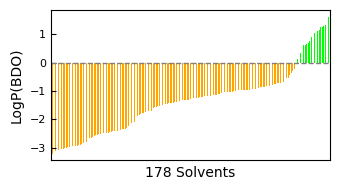

In [5]:
## If we only plot BDO at T
y = solvation_bdo[column_logP_name]
x = np.arange(len(solvation_bdo))
m = solvation_bdo.index #['Solvent Name']

idx_water = np.where(m=='WATER')[0][0]

colors = np.array(['gray' if i==idx_water else 
                   'orange' if  i<idx_water else
                   'lime' for i in range(len(x))])

fig, axs = plt.subplots(1,1,figsize=(3.5,2),tight_layout=True,dpi=100)

axs.bar(x,y, color=colors, width=0.5)  
axs.plot([-100,1000], [y[idx_water] ,y[idx_water] ], '--', color='gray', lw=1)
xlim = [ np.amin(x)-1, np.amax(x)+1 ]
#ylim = [ np.amin(y)-1, np.amax(y)+1 ]
axs.set_xlim(xlim)
#axs.set_ylim(ylim)
axs.set_xticks([])
axs.set_xlabel('178 Solvents',fontsize=10) ## input X name
axs.set_ylabel('LogP(BDO)',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')

#plt.savefig('logP_BDO.png', dpi=800)
plt.show()

In [ ]:
blue = m[ np.where(colors=='b')[0] ]
blue = solvation_bdo.loc[blue].sort_values(column_logP_name)
blue.to_csv('logP_BDO.csv')
blue

# Experimental data - paper version

In [6]:
exp_data = 'Experimental_data.csv'

exp_data = pd.read_csv(exp_data)#, index_col=0).set_index('Solvent Name')

inchi_value = []
included_data = []

dG_DFT_bdo, dG_DFT_bdo = [],[]

for smi in exp_data['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    inchi = Chem.MolToInchi(mol)
    inchi_value.append(inchi)
    if smi in list(solvation_bdo['SMILES']):
        included_data.append( True )
    elif inchi in list(solvation_bdo['Solvent Inchi']):        
        k = list(solvation_bdo[ solvation_bdo['Solvent Inchi']==inchi ].index)[0]
        included_data.append( True )
    else:
        included_data.append( False )    
        
    #if smi=='CCOC(=O)C':
    #    included_data[-1]=False

exp_data['inchi'] = inchi_value

included_data = np.array(included_data)

not_included_data = exp_data[~included_data]
included_data = exp_data[included_data]

#water_density = 1 #g/ml
display( included_data, not_included_data )

[17:34:36] WARNING: Omitted undefined stereo

[17:34:36] WARNING: Omitted undefined stereo

[17:34:36] WARNING: Omitted undefined stereo

[17:34:36] WARNING: Omitted undefined stereo



,Class,Solvent,MW (g/mol),Kd 20C,Kd 40C,Kd 60C,SMILES,inchi
0,Alcohol,1-Butanol,74.12,0.920,1.03,1.13,CCCCO,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3"
1,Alcohol,1-Hexanol,102.17,0.370,0.47,0.48,CCCCCCO,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3"
4,Alcohol,1-Heptanol,116.20,0.220,0.29,0.34,CCCCCCCO,"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3"
5,Alcohol,1-Octanol,130.23,0.220,0.27,0.30,CCCCCCCCO,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3"
6,Alcohol,1-Nonanol,144.25,0.140,0.20,0.20,CCCCCCCCCO,"InChI=1S/C9H20O/c1-2-3-4-5-6-7-8-9-10/h10H,2-9..."
9,Ester,Ethyl acetate,88.11,0.190,0.20,0.22,CCOC(=O)C,"InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3"
13,Ester,n-Pentyl acetate,130.18,0.040,0.06,0.06,CCCCCOC(=O)C,"InChI=1S/C7H14O2/c1-3-4-5-6-9-7(2)8/h3-6H2,1-2H3"
19,Hydrocarbon,Toluene,92.14,0.010,0.02,0.02,CC1=CC=CC=C1,"InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3"
20,Hydrocarbon,Methylcycohexane,98.19,0.005,0.01,0.05,CC1CCCCC1,"InChI=1S/C7H14/c1-7-5-3-2-4-6-7/h7H,2-6H2,1H3"
22,Hydrocarbon,Dodecane,170.33,0.030,0.09,0.05,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...


,Class,Solvent,MW (g/mol),Kd 20C,Kd 40C,Kd 60C,SMILES,inchi
2,Alcohol,2-Hexanol,102.17,0.35,0.41,0.47,CCCCC(C)O,"InChI=1S/C6H14O/c1-3-4-5-6(2)7/h6-7H,3-5H2,1-2H3"
3,Alcohol,4-Methyl-2-pentanol,102.17,0.30,0.41,0.44,CC(C)CC(C)O,"InChI=1S/C6H14O/c1-5(2)4-6(3)7/h5-7H,4H2,1-3H3"
7,Alcohol,"3,7-Dimethyl-1-octanol",158.28,0.11,0.17,0.20,CC(C)CCCC(C)CCO,InChI=1S/C10H22O/c1-9(2)5-4-6-10(3)7-8-11/h9-1...
8,Alcohol,Oleyl alcohol,268.50,0.07,0.07,0.11,CCCCCCCC/C=C\CCCCCCCCO,InChI=1S/C18H36O/c1-2-3-4-5-6-7-8-9-10-11-12-1...
10,Ester,Isopropyl acetate,102.13,0.10,0.11,0.13,CC(C)COC(=O)C,"InChI=1S/C6H12O2/c1-5(2)4-8-6(3)7/h5H,4H2,1-3H3"
11,Ester,sec-Butyl acetate,116.16,0.04,0.08,0.17,CCC(C)OC(=O)C,"InChI=1S/C6H12O2/c1-4-5(2)8-6(3)7/h5H,4H2,1-3H3"
12,Ester,Isobutyl acetate,116.16,0.05,0.07,0.07,CC(C)OC(=O)C,"InChI=1S/C5H10O2/c1-4(2)7-5(3)6/h4H,1-3H3"
14,Ester,Butyl butyrate,144.21,0.03,0.04,0.04,CCCCOC(=O)CCC,"InChI=1S/C8H16O2/c1-3-5-7-10-8(9)6-4-2/h3-7H2,..."
15,Ester,n-Hexyl acetate,144.21,0.03,0.04,0.05,CCCCCCOC(=O)C,"InChI=1S/C8H16O2/c1-3-4-5-6-7-10-8(2)9/h3-7H2,..."
16,Ester,Dibutyl oxalate,202.25,0.01,0.02,0.04,CCCCOC(=O)C(=O)OCCCC,InChI=1S/C10H18O4/c1-3-5-7-13-9(11)10(12)14-8-...


In [7]:
dG_DFT = []
for i in included_data['inchi']:
    d1 = solvation_bdo[ solvation_bdo['Solvent Inchi']==i ]['deltaG_Sol-Wat(kcal/mol)'].values[0]
    d2 = solvation_wat[ solvation_wat['Solvent Inchi']==i ]['deltaG_Sol-Wat(kcal/mol)'].values[0]
    dG_DFT.append( [d1,d2] )
dG_DFT = np.transpose( dG_DFT )

included_data['dG_DFT_bdo'] = dG_DFT[0]
included_data['dG_DFT_wat'] = dG_DFT[1]
included_data

C:\Users\zhan051\AppData\Local\Temp\ipykernel_20472\733105044.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  included_data['dG_DFT_bdo'] = dG_DFT[0]
C:\Users\zhan051\AppData\Local\Temp\ipykernel_20472\733105044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  included_data['dG_DFT_wat'] = dG_DFT[1]


,Class,Solvent,MW (g/mol),Kd 20C,Kd 40C,Kd 60C,SMILES,inchi,dG_DFT_bdo,dG_DFT_wat
0,Alcohol,1-Butanol,74.12,0.920,1.03,1.13,CCCCO,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3",-1.543609,0.366515
1,Alcohol,1-Hexanol,102.17,0.370,0.47,0.48,CCCCCCO,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3",-1.218309,0.613610
4,Alcohol,1-Heptanol,116.20,0.220,0.29,0.34,CCCCCCCO,"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3",-1.045995,0.723436
5,Alcohol,1-Octanol,130.23,0.220,0.27,0.30,CCCCCCCCO,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",-0.836972,0.868109
6,Alcohol,1-Nonanol,144.25,0.140,0.20,0.20,CCCCCCCCCO,"InChI=1S/C9H20O/c1-2-3-4-5-6-7-8-9-10/h10H,2-9...",-0.599020,1.044495
9,Ester,Ethyl acetate,88.11,0.190,0.20,0.22,CCOC(=O)C,"InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3",1.724457,3.875176
13,Ester,n-Pentyl acetate,130.18,0.040,0.06,0.06,CCCCCOC(=O)C,"InChI=1S/C7H14O2/c1-3-4-5-6-9-7(2)8/h3-6H2,1-2H3",2.069023,4.092940
19,Hydrocarbon,Toluene,92.14,0.010,0.02,0.02,CC1=CC=CC=C1,"InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3",3.118343,5.166294
20,Hydrocarbon,Methylcycohexane,98.19,0.005,0.01,0.05,CC1CCCCC1,"InChI=1S/C7H14/c1-7-5-3-2-4-6-7/h7H,2-6H2,1H3",3.994471,5.734899
22,Hydrocarbon,Dodecane,170.33,0.030,0.09,0.05,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,4.159443,5.800304


0.05678550187310659 0.021490456657210662
Pearsons correlation: 0.946


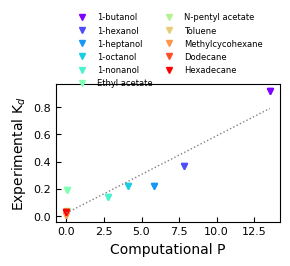

In [8]:
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

final_x, final_y, final_errbar, final_label = [],[], [],[]
for n,d in enumerate(included_data['SMILES']):
    temp_K = 273.15+25
    
    exp_sr = exp_data[ exp_data['SMILES']==d ] #['Kd 20C']
    inchi = exp_sr['inchi'].values[0]
    exp = exp_sr['Kd 20C'].values[0]
    label = exp_sr['Solvent'].values[0]
    #exp = np.log10(exp)
    
    sim = solvation_bdo[ solvation_bdo['Solvent Inchi'] == inchi ]
    sim = sim['deltaG_Sol-Wat(kcal/mol)'].values[0]
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim = np.power( 10, sim)  #sim = np.exp(sim)
    
    #display( exp_sr, sim )
    axs.plot((sim,sim), (exp,exp), color=colors[n], label=label.capitalize(), lw=2, ls='', marker='v', ms=5)
    
    #print(sim, exp)
    final_x.append( sim )
    final_y.append( exp )
    final_errbar.append( [0,0] )
    final_label.append( label.capitalize() )
    
final_x = np.array(final_x).flatten()
#record_x += [ x for x in final_x ]
#record_y += [ y for y in final_y ]
#record_m += [ m for m in included_data ]
#record_e += [ e for e in final_errbar ]

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational P',fontsize=10) ## input Y name
#axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
#axs.set_xlabel('Simulated partition coeffcient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')

axs.legend(fontsize=6, frameon=False, loc=10, ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1.25) )

fit_a,fit_b = np.polyfit(final_x,final_y,1)
fit_x = np.array([ min(final_x), max(final_x) ])

print(fit_a,fit_b)

axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')
#axs.set_yscale('log')

from scipy.stats import pearsonr
corr, _ = pearsonr( final_x,final_y )
print('Pearsons correlation: %.3f' % corr)

#plt.savefig('Compare2.png', dpi=800)

plt.show()

In [9]:
fitted_a, fitted_b = np.round( [fit_a, fit_b], 5 )
fitted_a, fitted_b 

(np.float64(0.05679), np.float64(0.02149))

Pearsons correlation: 0.946
R2: 0.939
RMSE: 0.007


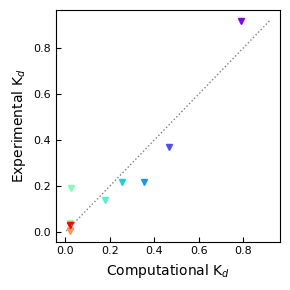

In [10]:
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)

y_fit = []
for n,(x,y,e,b) in enumerate(zip(final_x, final_y, final_errbar, final_label)):
    x = x*fitted_a + fitted_b
    axs.plot(x, y, color=colors[n], label=b, lw=2, ls='', marker='v', ms=5)
    y_fit.append(x)

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

x = np.array([np.amin(final_y),np.amax(final_y)])
axs.plot(x,x, ls=':',marker='',lw=1,color='gray')

corr, _ = pearsonr( y_fit, final_y )
r2 = metrics.r2_score( y_fit, final_y ) 
rmse = metrics.mean_squared_error( y_fit, final_y, )#squared=False)
print('Pearsons correlation: %.3f' % corr)
print('R2: %.3f' % np.sqrt(r2) )
print('RMSE: %.3f' % rmse)

plt.show()

In [11]:
solvation_data = solvation_bdo[['SMILES','Solvent Inchi','deltaG_Sol-Wat(kcal/mol)']]
solvation_data.columns = ['SMILES','Inchi','deltaG_bdo']
solvation_data

,SMILES,Inchi,deltaG_bdo
Solvent Name,,,
DIIODOMETHANE,C(I)I,InChI=1S/CH2I2/c2-1-3/h1H2,4.371604
CIS-DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.271077
N-HEXADECANE,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.251875
N-PENTADECANE,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.236062
DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.214727
...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.708895
2-PROPANOL,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.755833
1-PROPANOL,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.790283


In [12]:
## Add water?
s = solvation_wat[['deltaG_Sol-Wat(kcal/mol)']]
s.columns = ['deltaG_wat']
solvation_data = pd.concat([solvation_data,s], axis=1, join='inner')
solvation_data

,SMILES,Inchi,deltaG_bdo,deltaG_wat
Solvent Name,,,,
DIIODOMETHANE,C(I)I,InChI=1S/CH2I2/c2-1-3/h1H2,4.371604,4.804874
CIS-DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.271077,5.743013
N-HEXADECANE,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.251875,5.815026
N-PENTADECANE,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.236062,5.812930
DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.214727,5.731278
...,...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.708895,0.321554
2-PROPANOL,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.755833,0.321705
1-PROPANOL,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.790283,0.236922


[ 0.14424 -2.08347  0.05202]
Pearsons correlation: 0.972
R2: 0.943
RMSE: 0.004


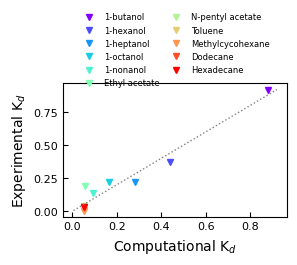

In [13]:
# Adding water does not help siginificantly
from scipy.optimize import curve_fit
from scipy.stats import pearsonr


def func1( xy, a1, a2, a3):
    x1, y1 = xy
    #return a*np.exp(b*x+c)
    return  a1*x1 + a2*y1 + a3
    #return a*np.log(x)+b
    
    
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

final_x1,final_x2, final_y, final_errbar, final_label = [],[],[], [],[]
for n,d in enumerate(included_data['SMILES']):
    temp_K = 273.15+25
    
    exp_sr = exp_data[ exp_data['SMILES']==d ] #['Kd 20C']
    inchi = exp_sr['inchi'].values[0]
    exp = exp_sr['Kd 20C'].values[0]
    label = exp_sr['Solvent'].values[0]
    #exp = np.log10(exp)
    
    sim = solvation_data[ solvation_data['Inchi'] == inchi ]
    sim1 = sim['deltaG_bdo'].values[0]
    sim1 = -sim1/(2.303*1.987*0.001*temp_K)  ## logP
    sim1 = np.power( 10, sim1)  #sim = np.exp(sim)
    
    sim2 = sim['deltaG_wat'].values[0]
    sim2 = -sim2/(2.303*1.987*0.001*temp_K)  ## logP
    sim2 = np.power( 10, sim2)  #sim = np.exp(sim)

    final_x1.append( sim1 )
    final_x2.append( sim2 )
    final_y.append( exp )
    final_errbar.append( [0,0] )
    final_label.append( label.capitalize() )
    
final_x1 = np.array(final_x1).flatten()
final_x2 = np.array(final_x2).flatten()
# Plot y vs a and b
popt, pcov = curve_fit(func1, (final_x1,final_x2), final_y, maxfev=1000)
y_fit = func1( (final_x1,final_x2), *popt)

for n,(x,y) in enumerate(zip(y_fit, final_y)):
    axs.plot( x, y, lw=2, ls='', marker='v', ms=5, color=colors[n], label=final_label[n] ) 

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational K$_d$',fontsize=10) ## input Y name
#axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
#axs.set_xlabel('Simulated partition coeffcient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')

axs.legend( fontsize=6, frameon=False, loc=10, ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1.25) )

fitted_abc = np.round( popt, 5 )
print( fitted_abc )

axlim = [ np.amin(final_y), np.amax(final_y) ]
axs.plot(axlim,axlim ,ls=':',marker='',lw=1,color='gray')

#axs.set_xscale('log')
#axs.set_yscale('log')

corr, _ = pearsonr( y_fit, final_y )
r2 = metrics.r2_score( y_fit, final_y ) 
rmse = metrics.mean_squared_error( y_fit, final_y, )#squared=False)
print('Pearsons correlation: %.3f' % corr)
print('R2: %.3f' % r2)
print('RMSE: %.3f' % rmse)

#plt.savefig('Compare2.png', dpi=800)
plt.show()

## Exp data - old testing version

Not included:  ['Iso-pentanol', '2-Ethyl-1-hexanol', 'Oleyl alcohol']
Ethyl acetate [0.06541891]
Butyl acetate [0.04158859]
1-butanol [11.48408966]
Iso-butanol [14.91451345]
1-pentanol [9.48815095]
1-Hexanol [6.86580606]
0.04598014670998502 0.32571846541362737
Pearsons correlation: 0.915


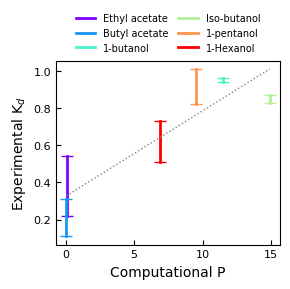

In [12]:
# Compare to exp data D
paper_data = {
    'Ethyl acetate': [318.2, (0.22,0.54), 'CCOC(=O)C', 0.902],
    'Butyl acetate': [318.2, (0.11,0.31), 'CCCCOC(=O)C', 0.882],
    '1-butanol':     [318.2, (0.94,0.96), 'CCCCO', 0.81],
    'Iso-butanol':   [318.2, (0.83,0.87), 'CC(C)CO', 0.802],
    '1-pentanol':    [318.2, (0.82,1.01), 'CCCCCO', 0.811],
    'Iso-pentanol':  [318.2, (0.80,0.90), 'CC(C)CCO', 0.825],
    '1-Hexanol':     [318.2, (0.51,0.73), 'CCCCCCO', 0.814],
    '2-Ethyl-1-hexanol': [315.2, (0.99,2.04), 'CCCCC(CC)CO', 0.833],
    'Oleyl alcohol': [314.2, (2.13,5.81), 'CCCCCCCC/C=C\CCCCCCCCO', 0.849],
}

# Which solvent is in our DFT result
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)

included_data = [k for k,v in paper_data.items() if v[2] in list(solvation_bdo['SMILES'])]
print('Not included: ', [k for k in paper_data.keys() if k not in included_data])

labels = included_data
colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

final_x,final_y, final_errbar = [],[], []
for n,d in enumerate(included_data):
    temp_K = paper_data[d][0]
    exp = paper_data[d][1]
    #exp = np.log10(exp)
    
    sim = solvation_bdo[ solvation_bdo['SMILES']==paper_data[d][2] ]['deltaG_Sol-Wat(kcal/mol)'].values
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim = np.power( 10, sim)
    #sim = np.exp(sim)
    
    #sim = sim/paper_data[d][3]
    print(d,sim)
    
    axs.plot((sim,sim), exp, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    
    final_x.append( sim )
    final_y.append( np.mean(exp) )
    final_errbar.append( list(exp) )
    
final_x = np.array(final_x).flatten()

record_x = [ x for x in final_x ]
record_y = [ y for y in final_y ]
record_m = [ m for m in included_data ]
record_e = [ e for e in final_errbar ]

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational P',fontsize=10) ## input Y name
#axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
#axs.set_xlabel('Simulated partition coeffcient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
axs.legend(fontsize=7, frameon=False, loc=10, ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1.15) )

fit_a,fit_b = np.polyfit(final_x,final_y,1)
fit_x = np.array([ min(final_x), max(final_x) ])

print(fit_a,fit_b)

axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')

from scipy.stats import pearsonr
corr, _ = pearsonr( final_x,final_y )
print('Pearsons correlation: %.3f' % corr)

#plt.savefig('Compare1.png', dpi=800)

plt.show()

In [13]:
%%capture --no-display

## Updated data in April
Dupeng_list = { ## exp D, solvent density g/ml
    # Group A
    'N-DODECANE':      [0.03, 0.75 ] + ['CCCCCCCCCCCC'],
    'N-HEXADECANE':    [0.04, 0.773] + ['CCCCCCCCCCCCCCCC'],
    '1-OCTANOL':       [0.24,0.824] + ['CCCCCCCCO'],
    'ETHYL ETHANOATE': [0.18,0.902] + ['CCOC(=O)C'],  # also known as ethyl acetate
    '1-BUTANOL':       [0.88,0.81 ] + ['CCCCO'],
    '1-HEXANOL':       [0.34,0.814] + ['CCCCCCO'],
    
    'Isopropyl Myristate': [0.02,0.85 ] + ['CCCCCCCCCCCCCC(=O)OC(C)C'],
    'Oleyl Alcohol': [0.06,0.849] + ['CCCCCCCC/C=C\CCCCCCCCO'],
    
    # Group B
    'Methylcyclohexane':      [-0.02, 0 ] + ['CC1CCCCC1'],
    '3,7-Dimethyl-1-octanol':      [0.09, 0 ] + ['CC(C)CCCC(C)CCO'],
    '1-Nonanol':      [0.12, 0 ] + ['CCCCCCCCCO'],
    'Dibutyl oxalate':      [-0.01, 0 ] + ['CCCCOC(=O)C(=O)OCCCC'],
    '1-Heptanol':      [0.2, 0 ] + ['CCCCCCCO'],
    'Diethyl adipate':      [0.02, 0 ] + ['CCOC(=O)CCCCC(=O)OCC'],
    'sec-Butyl acetate':      [0.03, 0 ] + ['CCC(C)OC(=O)C'],
    '4-methyl-2-pentanol':      [0.26, 0 ] + ['CC(C)CC(C)O'],
    
    # Group C
    'Toluene':      [0.01, 0 ] + ['CC1=CC=CC=C1'],
    'PENTYL ETHANOATE':      [0.03, 0 ] + ['CCCCCOC(=O)C'], # n-Pentyl acetate 
    'Isopropyl acetate':      [0.1, 0 ] + ['CC(C)OC(=O)C'],
    'Butyl butyrate':      [0.03, 0 ] + ['CCCCOC(=O)CCC'],
    'Isobutyl acetate':      [0.05, 0 ] + ['CC(C)COC(=O)C'],
    'n-Hexyl acetate':      [0.03, 0 ] + ['CCCCCCOC(=O)C'],
    '2-Hexanol':      [0.34, 0 ] + ['CCCCC(C)O'],
    'tert-Butylcyclohexane':      [0.01, 0 ] + ['CC(C)(C)C1CCCCC1'],
}

Dupeng_list = { k.upper():v for k,v in Dupeng_list.items() }

included_data = []
for k,v in Dupeng_list.items():
    mol = Chem.MolFromSmiles(v[2])
    inchi = Chem.MolToInchi(mol)
    if k in list(solvation_bdo.index):
        included_data.append(k)
    elif inchi in list(solvation_bdo['Solvent Inchi']):        
        k = list(solvation_bdo[ solvation_bdo['Solvent Inchi']==inchi ].index)[0]
        print( '========',k )
        included_data.append(k)
    
water_density = 1 #g/ml

display( [ k for k in Dupeng_list if k not in included_data] )


['ISOPROPYL MYRISTATE',
 'OLEYL ALCOHOL',
 '3,7-DIMETHYL-1-OCTANOL',
 'DIBUTYL OXALATE',
 'DIETHYL ADIPATE',
 'SEC-BUTYL ACETATE',
 '4-METHYL-2-PENTANOL',
 'ISOPROPYL ACETATE',
 'BUTYL BUTYRATE',
 'ISOBUTYL ACETATE',
 'N-HEXYL ACETATE',
 '2-HEXANOL',
 'TERT-BUTYLCYCLOHEXANE']

0.05225295235520195 0.018421336778079736
Pearsons correlation: 0.943


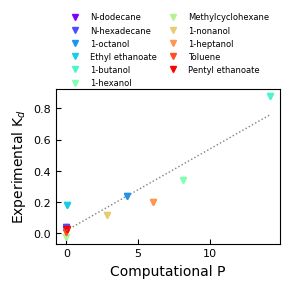

In [14]:
#display(solvation_bdo.loc[ ['WATER']+included_data ])

# Which solvent is in our DFT result
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)

labels = included_data
colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

final_x,final_y, final_errbar = [],[], []
for n,d in enumerate(included_data):
    temp_K = 293.15
    exp = Dupeng_list[d][0]
    #exp = np.log10(exp)
    
    try:
        sim = solvation_bdo.loc[ d ]['deltaG_Sol-Wat(kcal/mol)']
    except:
        sim = solvation_bdo[ solvation_bdo['Solvent Inchi'] == Dupeng_list[d][3] ]
        sim = sim['deltaG_Sol-Wat(kcal/mol)']
    
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim = np.power( 10, sim)        
    #sim = np.exp(sim)
    
    #sim = sim/Dupeng_list[d][1]
    
    axs.plot((sim,sim), (exp,exp), color=colors[n], label=labels[n].capitalize(), lw=2, ls='', marker='v', ms=5)
    
    #print(sim, exp)
    final_x.append( sim )
    final_y.append( exp )
    final_errbar.append( [0,0] )

    
final_x = np.array(final_x).flatten()

record_x += [ x for x in final_x ]
record_y += [ y for y in final_y ]
record_m += [ m for m in included_data ]
record_e += [ e for e in final_errbar ]

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational P',fontsize=10) ## input Y name
#axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
#axs.set_xlabel('Simulated partition coeffcient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')

axs.legend(fontsize=6, frameon=False, loc=10, ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1.25) )

fit_a,fit_b = np.polyfit(final_x,final_y,1)
fit_x = np.array([ min(final_x), max(final_x) ])

print(fit_a,fit_b)

axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')
#axs.set_yscale('log')

from scipy.stats import pearsonr
corr, _ = pearsonr( final_x,final_y )
print('Pearsons correlation: %.3f' % corr)

#plt.savefig('Compare2.png', dpi=800)

plt.show()

In [ ]:
# Both data
from scipy.stats import pearsonr

fig, axs = plt.subplots(1,1,figsize=(2.5,2.5),tight_layout=True,dpi=100)

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(record_x)) ]

mask = []#'N-DODECANE', 'N-HEXADECANE']
record_x_masked,record_y_masked,record_m_masked = [],[],[]
record_e_masked = []

for n in range(len(record_x)):
    #print(n)
    if record_m[n] not in mask:
        print( record_x[n] ,record_y[n], record_m[n], record_e[n] )
        if record_e[n][0]!=record_e[n][1]:
            axs.plot( record_x[n] ,record_y[n], color='c', label=record_m[n], lw=2, ls='', marker='o', ms=5)
            err_lo = record_y[n] - record_e[n][0]
            err_hi = record_e[n][1] - record_y[n]
            axs.errorbar( record_x[n] ,record_y[n], yerr=[[err_lo],[err_hi]], ecolor='c', capsize=7)
        else:
            axs.plot( record_x[n] ,record_y[n], color='m', label=record_m[n], lw=2, ls='', marker='v', ms=6)
            #err_lo = err_hi =0
        
        #axs.annotate(record_m[n].capitalize(), xy=( np.mean(record_x[n])+0.2, np.mean(record_y[n]) ), fontsize=6)
    
        record_x_masked.append(record_x[n])
        record_y_masked.append(record_y[n])
        record_m_masked.append(record_m[n])

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computationl P',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')

#axs.legend(fontsize=6, frameon=False, loc=4, ncol=2)


fit_a,fit_b = np.polyfit(record_x_masked,record_y_masked,1)
fit_x = np.array([ min(record_x_masked), max(record_x_masked) ])

print(fit_a,fit_b)

axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')

corr, _ = pearsonr( record_x_masked,record_y_masked )
print('Pearsons correlation: %.3f' % corr)

plt.savefig('benchmark.png', dpi=800)

plt.show()

In [10]:
solvation_data = solvation_bdo[['SMILES','Solvent Inchi','deltaG_Sol-Wat(kcal/mol)']]
solvation_data.columns = ['SMILES','Inchi','deltaG_bdo']
solvation_data

,SMILES,Inchi,deltaG_bdo
Solvent Name,,,
DIIODOMETHANE,C(I)I,InChI=1S/CH2I2/c2-1-3/h1H2,4.371604
CIS-DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.271046
N-HEXADECANE,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.251882
N-PENTADECANE,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.236062
DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.214746
...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.708902
2-PROPANOL,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.755827
1-PROPANOL,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.790315


In [7]:
# If we consider both BDO and water
solvation_data = pd.concat([ solvation_bdo[['SMILES','deltaG_Sol-Wat(kcal/mol)',column_logP_name]], 
                            solvation_wat[['deltaG_Sol-Wat(kcal/mol)',column_logP_name]] ], 
                           axis=1, join='inner')
solvation_data.columns = ['SMILES','deltaG_bdo',f'{column_logP_name} bdo','deltaG_wat',f'{column_logP_name} wat']
solvation_data

,SMILES,deltaG_bdo,logP at 25C bdo,deltaG_wat,logP at 25C wat
Solvent Name,,,,,
DIIODOMETHANE,C(I)I,4.371604,-3.204160,4.804874,-3.521725
CIS-DECALIN,C1CCC2CCCCC2C1,4.271046,-3.130456,5.743013,-4.209332
N-HEXADECANE,CCCCCCCCCCCCCCCC,4.251882,-3.116410,5.815026,-4.262113
N-PENTADECANE,CCCCCCCCCCCCCCC,4.236062,-3.104815,5.812930,-4.260577
DECALIN,C1CCC2CCCCC2C1,4.214746,-3.089191,5.731278,-4.200731
...,...,...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,-1.708902,1.252537,0.321554,-0.235683
2-PROPANOL,CC(C)O,-1.755827,1.286930,0.321705,-0.235793
1-PROPANOL,CCCO,-1.790315,1.312208,0.236922,-0.173652


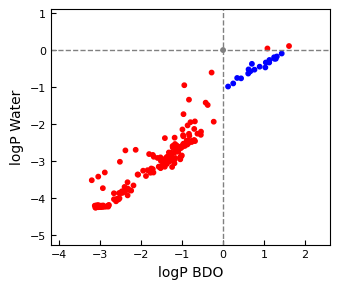

In [8]:
x = solvation_data[f'{column_logP_name} bdo']
y = solvation_data[f'{column_logP_name} wat']
m = solvation_data.index

idx_water = np.where(m=='WATER')[0][0]

colors = np.array(['gray' if m[i]=='WATER' else 
                   'b' if x[i]>x[idx_water] and y[i]<y[idx_water] else
                   'r' for i in range(len(m))])

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

axs.plot([-100,100], [y[idx_water] ,y[idx_water] ], '--', color='gray', lw=1)
axs.plot([x[idx_water] ,x[idx_water] ], [-100,100], '--', color='gray', lw=1)
axs.scatter(x,y, marker='o', c=colors, s=10)  

xlim = [ np.amin(x)-1, np.amax(x)+1 ]
ylim = [ np.amin(y)-1, np.amax(y)+1 ]
axs.set_xlim(xlim)
axs.set_ylim(ylim)

#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
axs.set_xlabel('logP BDO',fontsize=10) ## input X name
axs.set_ylabel('logP Water',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
plt.show()

In [9]:
blue = m[ np.where(colors=='b')[0] ]
blue = solvation_data.loc[blue].sort_values(f'{column_logP_name} bdo')
blue

,SMILES,deltaG_bdo,logP at 25C bdo,deltaG_wat,logP at 25C wat
Solvent Name,,,,,
M-CRESOL,CC1=CC(=CC=C1)O,-0.166585,0.122098,1.346459,-0.986885
1-DECANOL,CCCCCCCCCCO,-0.338058,0.247779,1.232277,-0.903195
"2,2,2-TRIFLUOROETHANOL",C(C(F)(F)F)O,-0.469295,0.343969,1.030583,-0.755364
1-NONANOL,CCCCCCCCCO,-0.599045,0.439069,1.044495,-0.765561
1-OCTANOL,CCCCCCCCO,-0.836953,0.613443,0.868109,-0.636279
CYCLOPENTANOL,C1CCC(C1)O,-0.848756,0.622094,0.714074,-0.523379
BENZYL ALCOHOL,C1=CC=C(C=C1)CO,-0.907409,0.665084,0.785466,-0.575706
2-METHOXYETHANOL,COCCO,-0.960177,0.703760,0.509412,-0.373373
1-HEPTANOL,CCCCCCCO,-1.045982,0.766651,0.723436,-0.530241


In [81]:
bdo_monomer = pd.read_csv('results_bdo_with_SMILES.csv', index_col=0).set_index('Solvent Name')
bdo_monomer

,Energy,Free Energy,JobID,SMILES
Solvent Name,,,,
"1,1,1-TRICHLOROETHANE",-308.870246,-308.760704,job_1,CC(Cl)(Cl)Cl
1-BROMOPENTANE,-308.869345,-308.759776,job_10,CCCCCBr
"E-1,2-DICHLOROETHENE",-308.866908,-308.757184,job_100,C(=C/Cl)\Cl
"Z-1,2-DICHLOROETHENE",-308.870935,-308.761615,job_101,C(=C\Cl)\Cl
DICHLOROMETHANE,-308.871052,-308.761796,job_102,C(Cl)Cl
...,...,...,...,...
CIS-DECALIN,-308.866035,-308.756169,job_95,C1CCC2CCCCC2C1
N-DECANE,-308.866340,-308.756449,job_96,CCCCCCCCCC
DIBROMOMETHANE,-308.869782,-308.760424,job_97,C(Br)Br


In [82]:
# Dimer and trimer data
bdo_dimer = pd.read_csv('results_bdo_dimer.log', sep='|')
bdo_dimer.columns = [ c.strip() for c in bdo_dimer.columns ]
bdo_dimer['Solvent Name'] = [ m.strip()[1:-1] for m in bdo_dimer['Solvent Name'] ]
bdo_dimer = bdo_dimer.set_index('Solvent Name')

bdo_trimer = pd.read_csv('results_bdo_trimer.log', sep='|')
bdo_trimer.columns = [ c.strip() for c in bdo_trimer.columns ]
bdo_trimer['Solvent Name'] = [ m.strip()[1:-1] for m in bdo_trimer['Solvent Name'] ]
bdo_trimer = bdo_trimer.set_index('Solvent Name')

display( bdo_dimer, bdo_trimer )

,Energy,Free Energy,JobID
Solvent Name,,,
"1,1,1-TRICHLOROETHANE",-617.751643,-617.510185,job_1
1-BROMOPENTANE,-617.749999,-617.507197,job_10
"E-1,2-DICHLOROETHENE",-617.745999,-617.502401,job_100
"Z-1,2-DICHLOROETHENE",-617.752526,-617.510027,job_101
DICHLOROMETHANE,-617.752822,-617.512731,job_102
...,...,...,...
CIS-DECALIN,-617.744470,-617.503093,job_95
N-DECANE,-617.745101,-617.504536,job_96
DIBROMOMETHANE,-617.750522,-617.510185,job_97


,Energy,Free Energy,JobID
Solvent Name,,,
"1,1,1-TRICHLOROETHANE",-926.639775,-926.262807,job_1
1-BROMOPENTANE,-926.637671,-926.260563,job_10
"E-1,2-DICHLOROETHENE",-926.633217,-926.255606,job_100
"Z-1,2-DICHLOROETHENE",-926.640122,-926.263243,job_101
DICHLOROMETHANE,-926.640583,-926.263765,job_102
...,...,...,...
CIS-DECALIN,-926.631459,-926.253768,job_95
N-DECANE,-926.632444,-926.254714,job_96
DIBROMOMETHANE,-926.637649,-926.260607,job_97


In [83]:
names = {
    'Energy': 'E_', 
    'Free Energy': 'FE_', 
    'JobID': 'JobID_', 
    'SMILES': 'SMILES'}

names_monomer = { k:v+'monomer' if k!='SMILES' else v for k,v in names.items()  }
bdo_monomer = bdo_monomer.rename( columns=names_monomer )

names_dimer = { k:v+'dimer' if k!='SMILES' else v for k,v in names.items()  }
bdo_dimer = bdo_dimer.rename( columns=names_dimer )

names_trimer = { k:v+'trimer' if k!='SMILES' else v for k,v in names.items()  }
bdo_trimer = bdo_trimer.rename( columns=names_trimer )

bdo_all = pd.concat( [bdo_monomer, bdo_dimer, bdo_trimer], axis=1)
bdo_all = bdo_all[ ['SMILES','JobID_monomer','E_monomer','FE_monomer','E_dimer','FE_dimer','E_trimer','FE_trimer'] ]

bdo_all

,SMILES,JobID_monomer,E_monomer,FE_monomer,E_dimer,FE_dimer,E_trimer,FE_trimer
Solvent Name,,,,,,,,
"1,1,1-TRICHLOROETHANE",CC(Cl)(Cl)Cl,job_1,-308.870246,-308.760704,-617.751643,-617.510185,-926.639775,-926.262807
1-BROMOPENTANE,CCCCCBr,job_10,-308.869345,-308.759776,-617.749999,-617.507197,-926.637671,-926.260563
"E-1,2-DICHLOROETHENE",C(=C/Cl)\Cl,job_100,-308.866908,-308.757184,-617.745999,-617.502401,-926.633217,-926.255606
"Z-1,2-DICHLOROETHENE",C(=C\Cl)\Cl,job_101,-308.870935,-308.761615,-617.752526,-617.510027,-926.640122,-926.263243
DICHLOROMETHANE,C(Cl)Cl,job_102,-308.871052,-308.761796,-617.752822,-617.512731,-926.640583,-926.263765
...,...,...,...,...,...,...,...,...
CIS-DECALIN,C1CCC2CCCCC2C1,job_95,-308.866035,-308.756169,-617.744470,-617.503093,-926.631459,-926.253768
N-DECANE,CCCCCCCCCC,job_96,-308.866340,-308.756449,-617.745101,-617.504536,-926.632444,-926.254714
DIBROMOMETHANE,C(Br)Br,job_97,-308.869782,-308.760424,-617.750522,-617.510185,-926.637649,-926.260607


In [84]:
Eh_to_kcalmol = 627.509

G_water = bdo_all[ bdo_all['SMILES']=='O' ]

G_water_bdo_monomer = G_water['FE_monomer'].values[0]
G_water_bdo_dimer = G_water['FE_dimer'].values[0]
G_water_bdo_trimer = G_water['FE_trimer'].values[0]

deltaG_bdo_monomer = (bdo_all['FE_monomer']-G_water_bdo_monomer)*Eh_to_kcalmol
deltaG_bdo_dimer = (bdo_all['FE_dimer']-G_water_bdo_dimer)*Eh_to_kcalmol
deltaG_bdo_trimer = (bdo_all['FE_trimer']-G_water_bdo_trimer)*Eh_to_kcalmol

bdo_all['deltaG_monomer'] = deltaG_bdo_monomer
bdo_all['deltaG_dimer'] = deltaG_bdo_dimer
bdo_all['deltaG_trimer'] = deltaG_bdo_trimer 

bdo_all

,SMILES,JobID_monomer,E_monomer,FE_monomer,E_dimer,FE_dimer,E_trimer,FE_trimer,deltaG_monomer,deltaG_dimer,deltaG_trimer
Solvent Name,,,,,,,,,,,
"1,1,1-TRICHLOROETHANE",CC(Cl)(Cl)Cl,job_1,-308.870246,-308.760704,-617.751643,-617.510185,-926.639775,-926.262807,1.424747,2.467428,2.118790
1-BROMOPENTANE,CCCCCBr,job_10,-308.869345,-308.759776,-617.749999,-617.507197,-926.637671,-926.260563,2.007571,4.342996,3.527046
"E-1,2-DICHLOROETHENE",C(=C/Cl)\Cl,job_100,-308.866908,-308.757184,-617.745999,-617.502401,-926.633217,-926.255606,3.633886,7.352109,6.637759
"Z-1,2-DICHLOROETHENE",C(=C\Cl)\Cl,job_101,-308.870935,-308.761615,-617.752526,-617.510027,-926.640122,-926.263243,0.853550,2.566951,1.845416
DICHLOROMETHANE,C(Cl)Cl,job_102,-308.871052,-308.761796,-617.752822,-617.512731,-926.640583,-926.263765,0.739940,0.870041,1.517700
...,...,...,...,...,...,...,...,...,...,...,...
CIS-DECALIN,C1CCC2CCCCC2C1,job_95,-308.866035,-308.756169,-617.744470,-617.503093,-926.631459,-926.253768,4.271046,6.918174,7.791102
N-DECANE,CCCCCCCCCC,job_96,-308.866340,-308.756449,-617.745101,-617.504536,-926.632444,-926.254714,4.095199,6.012189,7.197296
DIBROMOMETHANE,C(Br)Br,job_97,-308.869782,-308.760424,-617.750522,-617.510185,-926.637649,-926.260607,1.600499,2.467742,3.499712


In [87]:
%%capture --no-display

## Add the Inchi to differentiate SMILES
inchi_solvent = []
for smi_solvent in bdo_all['SMILES']:
    try:
        mol = Chem.MolFromSmiles(smi_solvent)
        inchi = Chem.MolToInchi(mol)
    except:
        print(smi_solvent, 'is bad solute')
        inchi = 'NotFound'
    inchi_solvent.append(inchi)

bdo_all['Solvent Inchi'] = inchi_solvent
bdo_all

,SMILES,JobID_monomer,E_monomer,FE_monomer,E_dimer,FE_dimer,E_trimer,FE_trimer,deltaG_monomer,deltaG_dimer,deltaG_trimer,Solvent Inchi
Solvent Name,,,,,,,,,,,,
"1,1,1-TRICHLOROETHANE",CC(Cl)(Cl)Cl,job_1,-308.870246,-308.760704,-617.751643,-617.510185,-926.639775,-926.262807,1.424747,2.467428,2.118790,"InChI=1S/C2H3Cl3/c1-2(3,4)5/h1H3"
1-BROMOPENTANE,CCCCCBr,job_10,-308.869345,-308.759776,-617.749999,-617.507197,-926.637671,-926.260563,2.007571,4.342996,3.527046,"InChI=1S/C5H11Br/c1-2-3-4-5-6/h2-5H2,1H3"
"E-1,2-DICHLOROETHENE",C(=C/Cl)\Cl,job_100,-308.866908,-308.757184,-617.745999,-617.502401,-926.633217,-926.255606,3.633886,7.352109,6.637759,InChI=1S/C2H2Cl2/c3-1-2-4/h1-2H/b2-1+
"Z-1,2-DICHLOROETHENE",C(=C\Cl)\Cl,job_101,-308.870935,-308.761615,-617.752526,-617.510027,-926.640122,-926.263243,0.853550,2.566951,1.845416,InChI=1S/C2H2Cl2/c3-1-2-4/h1-2H/b2-1-
DICHLOROMETHANE,C(Cl)Cl,job_102,-308.871052,-308.761796,-617.752822,-617.512731,-926.640583,-926.263765,0.739940,0.870041,1.517700,InChI=1S/CH2Cl2/c2-1-3/h1H2
...,...,...,...,...,...,...,...,...,...,...,...,...
CIS-DECALIN,C1CCC2CCCCC2C1,job_95,-308.866035,-308.756169,-617.744470,-617.503093,-926.631459,-926.253768,4.271046,6.918174,7.791102,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...
N-DECANE,CCCCCCCCCC,job_96,-308.866340,-308.756449,-617.745101,-617.504536,-926.632444,-926.254714,4.095199,6.012189,7.197296,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,..."
DIBROMOMETHANE,C(Br)Br,job_97,-308.869782,-308.760424,-617.750522,-617.510185,-926.637649,-926.260607,1.600499,2.467742,3.499712,InChI=1S/CH2Br2/c2-1-3/h1H2


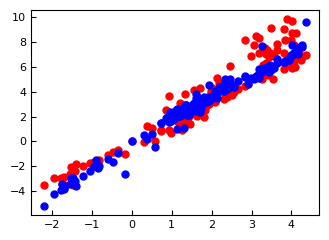

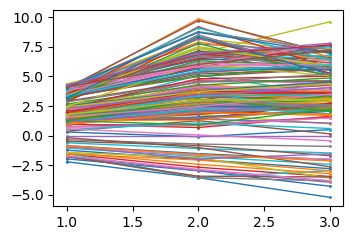

In [88]:
fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
axs.plot(bdo_all['deltaG_monomer'], bdo_all['deltaG_dimer'], lw=2, ls='', marker='o', ms=5, label='dimer', color='r')
axs.plot(bdo_all['deltaG_monomer'], bdo_all['deltaG_trimer'], lw=2, ls='', marker='o', ms=5, label='trimer', color='b')
#axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
#axs.set_xlabel('Simulated partition coeffcient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
#axs.legend(fontsize=7, frameon=False, loc=1, ncol=2)

#plt.savefig('Compare.png', dpi=800)
plt.show()

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
x=[1,2,3]
#y = np.transpose([bdo_all['FE_monomer'], bdo_all['FE_dimer'], bdo_all['FE_trimer']])
for y1,y2,y3 in zip( bdo_all['deltaG_monomer'], bdo_all['deltaG_dimer'], bdo_all['deltaG_trimer'] ):
    axs.plot(x,[y1,y2,y3], lw=1, ls='-', marker='o', ms=1)
#axs.tick_params(direction='in',labelsize='8')
#axs.legend(fontsize=7, frameon=False, loc=1, ncol=2)
plt.show()

Not included:  ['Iso-pentanol', '2-Ethyl-1-hexanol', 'Oleyl alcohol']
Not included:  ['Isopropyl Myristate', 'Oleyl Alcohol']
Ethyl acetate CCOC(=O)C [0.06542216 0.01809924 0.00748618] (0.22, 0.54)
Butyl acetate CCCCOC(=O)C [0.04159024 0.00384307 0.00318221] (0.11, 0.31)
1-Butanol CCCCO [ 11.48431757  67.35239973 230.02991938] (0.94, 0.96)
Iso-Butanol CC(C)CO [ 14.91466145 265.87225503 415.24839328] (0.83, 0.87)
1-Pentanol CCCCCO [  9.48786851  45.23480648 157.30204589] (0.82, 1.01)
n-Hexanol CCCCCCO [ 6.86587419 24.00453131 81.35506812] (0.51, 0.73)
6
N-DODECANE CCCCCCCCCCCC [0.0007931558572012433 4.939155960861518e-06 3.167717568711165e-06] 5.9
N-HEXADECANE CCCCCCCCCCCCCCCC [0.0006767626294674716 8.923628354874748e-06 2.145637877817483e-06] 2.1
1-OCTANOL CCCCCCCCO [4.206356277899528 13.364324616697804 31.545191040665873] 0.16
ETHYL ETHANOATE CCOC(=O)C [0.05182355689015895 0.01284622613090332 0.004927352813624002] 0.27
1-BUTANOL CCCCO [14.147913133454102 96.51346724700278 366.10147345

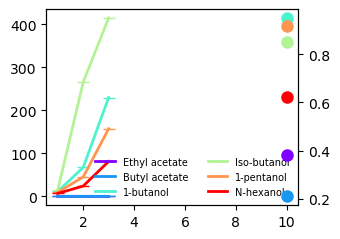

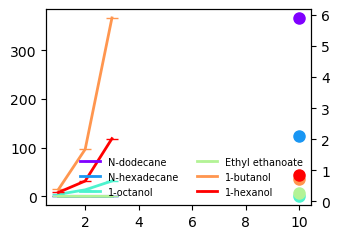

In [14]:
# Compare to exp data D
paper_data = {
    'Ethyl acetate': [318.2, (0.22,0.54), 'CCOC(=O)C', 0.902],
    'Butyl acetate': [318.2, (0.11,0.31), 'CCCCOC(=O)C', 0.882],
    '1-Butanol':     [318.2, (0.94,0.96), 'CCCCO', 0.81],
    'Iso-Butanol':   [318.2, (0.83,0.87), 'CC(C)CO', 0.802],
    '1-Pentanol':    [318.2, (0.82,1.01), 'CCCCCO', 0.811],
    'Iso-pentanol':  [318.2, (0.80,0.90), 'CC(C)CCO', 0.825],
    'n-Hexanol':     [318.2, (0.51,0.73), 'CCCCCCO', 0.814],
    '2-Ethyl-1-hexanol': [315.2, (0.99,2.04), 'CCCCC(CC)CO', 0.833],
    'Oleyl alcohol': [314.2, (2.13,5.81), 'CCCCCCCC/C=C\CCCCCCCCO', 0.849],
}

included_data1 = [k for k,v in paper_data.items() if v[2] in list(bdo_all['SMILES'])]
print('Not included: ', [k for k in paper_data.keys() if k not in included_data1])

# Dupeng exp data
temp_K = 293.15
Dupeng_list = { ## exp D, solvent density g/ml
    'N-DODECANE':      [5.9, 0.75 ],
    'N-HEXADECANE':    [2.1, 0.773],
    '1-OCTANOL':       [0.16,0.824],
    'ETHYL ETHANOATE': [0.27,0.902],
    '1-BUTANOL':       [0.72,0.81 ],
    '1-HEXANOL':       [0.84,0.814],
    
    'Isopropyl Myristate': [0.85,0.85 ],
    'Oleyl Alcohol': [1.18,0.849],
}
Dupeng_list = { k:[temp_K]+v for k,v in Dupeng_list.items() }

included_data2 = [ k for k,v in Dupeng_list.items() if k in list(bdo_all.index) ]
print( 'Not included: ', [ k for k in Dupeng_list if k not in included_data2] )

water_density = 1 #g/ml

# Which solvent is in our DFT result
all_data = []

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
axt = axs.twinx()

labels = [ s.capitalize() for s in included_data1 ]
colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data1)) ]

for n,d in enumerate(included_data1):
    temp_K = paper_data[d][0]
    exp = paper_data[d][1]
    #exp = np.log10(exp)
    
    sim = bdo_all[ bdo_all['SMILES']==paper_data[d][2] ]
    smiles = str(sim['SMILES'].values[0])
    sim = sim[ ['deltaG_monomer','deltaG_dimer','deltaG_trimer'] ].values[0]    
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## log10[P]
    sim = np.power( 10, sim) ## P
    #sim = np.exp(sim)
    #sim = sim/paper_data[d][3]
    print(d, smiles, sim, exp)
    
    x=[1,2,3]
    #axs.plot((sim,sim), exp, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    axs.plot(x, sim, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    axt.plot([10], np.mean(exp), color=colors[n], label=labels[n], lw=2, ls='-', marker='o', ms=8)
    
    all_data.append( [d, smiles]+list(sim)+[exp] )

axs.legend(fontsize=7, frameon=False, loc=4, ncol=2)
print( len(all_data) )

print('================')
# Which solvent is in our DFT result
fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
axt = axs.twinx()

labels = [ s.capitalize() for s in included_data2 ]
colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data2)) ]

for n,d in enumerate(included_data2):
    temp_K = Dupeng_list[d][0]
    exp = Dupeng_list[d][1]
    #exp = np.log10(exp)
    
    sim = bdo_all.loc[d]
    smiles = str(sim['SMILES'])
    sim = sim[ ['deltaG_monomer','deltaG_dimer','deltaG_trimer'] ].values
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim = np.power( 10, sim)        
    #sim = np.exp(sim)
    #sim = sim/Dupeng_list[d][1]
    print(d, smiles, sim, exp)
    
    x=[1,2,3]
    #axs.plot((sim,sim), exp, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    axs.plot(x, sim, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    axt.plot([10], exp, color=colors[n], label=labels[n], lw=2, ls='-', marker='o', ms=8)
    
    all_data.append( [d,smiles]+list(sim)+[exp] )

axs.legend(fontsize=7, frameon=False, loc=4, ncol=2)
print( len(all_data) )


['Ethyl acetate', 'CCOC(=O)C', 0.0654221587255987, 0.018099244758172817, 0.007486184230821717, (0.22, 0.54)]
['Butyl acetate', 'CCCCOC(=O)C', 0.04159023654824525, 0.0038430728708670338, 0.0031822109155573465, (0.11, 0.31)]
['1-Butanol', 'CCCCO', 11.48431757351582, 67.35239972555733, 230.0299193843493, (0.94, 0.96)]
['Iso-Butanol', 'CC(C)CO', 14.914661453233546, 265.8722550271833, 415.2483932764896, (0.83, 0.87)]
['1-Pentanol', 'CCCCCO', 9.48786850624444, 45.234806475080035, 157.30204588818418, (0.82, 1.01)]
['n-Hexanol', 'CCCCCCO', 6.865874193454447, 24.00453130849052, 81.35506812091951, (0.51, 0.73)]
['N-DODECANE', 'CCCCCCCCCCCC', 0.0007931558572012433, 4.939155960861518e-06, 3.167717568711165e-06, 5.9]
['N-HEXADECANE', 'CCCCCCCCCCCCCCCC', 0.0006767626294674716, 8.923628354874748e-06, 2.145637877817483e-06, 2.1]
['1-OCTANOL', 'CCCCCCCCO', 4.206356277899528, 13.364324616697804, 31.545191040665873, 0.16]
['ETHYL ETHANOATE', 'CCOC(=O)C', 0.05182355689015895, 0.01284622613090332, 0.004927

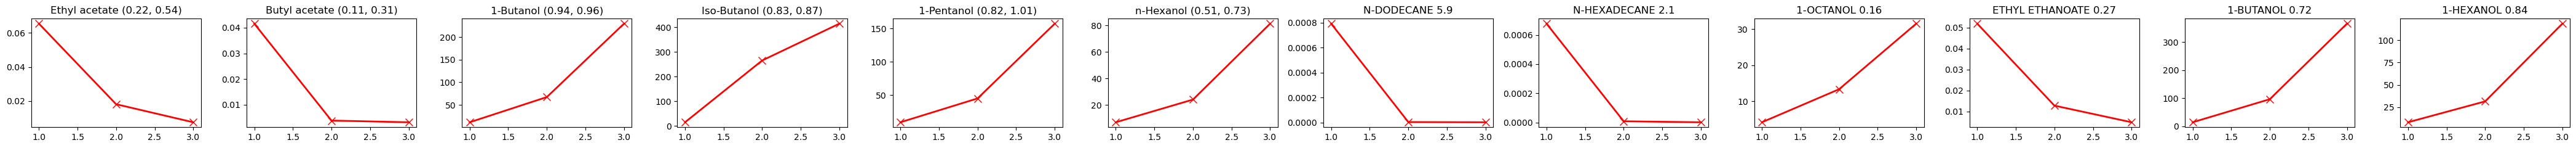

In [57]:
fig, axs = plt.subplots(1,len(all_data), figsize=(3.5*len(all_data),2.5),tight_layout=True,dpi=100)

for n,d in enumerate(all_data):
    print( d )
    axs[n].plot( [1,2,3], d[2:5], color='r', label=d[0], lw=2, ls='-', marker='x', ms=8)
    axs[n].set_title( d[0]+f' {d[-1]}' )
    
plt.show()

[0.04494816 0.27973788] [[ 0.00011289 -0.000783  ]
 [-0.000783    0.00874758]]
Fit RMSE error:  0.1628902004406704
Check if overfitted: 207.6777758277712 [0.00011289 0.00874758]
Pearsons correlation: 0.831


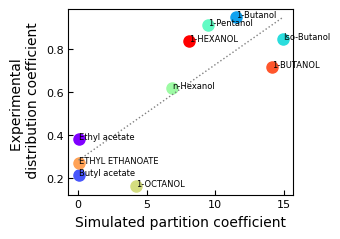

In [15]:
# 0-5 is paper data, 6-11 is Dupeng data
plot_data = [d for d in all_data if d[0] not in ['N-DODECANE','N-HEXADECANE'] ]

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
#axt = axs.twinx()

axs.set_ylabel('Experimental \n distribution coefficient',fontsize=10) ## input X name
axs.set_xlabel('Simulated partition coefficient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(plot_data)) ]

xdat,ydat = [],[]
for n,d in enumerate(plot_data): 
    label = d[0]
    x = d[2]
    y = d[5:]
    axs.plot(x, np.mean(y), color=colors[n], label=label, lw=2, ls='', marker='o', ms=8) 
    axs.annotate(label, xy=(x, np.mean(y)), fontsize=6)
    
    xdat.append(x)
    ydat.append(np.mean(y))

xdat = np.array(xdat)
ydat = np.array(ydat)

#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')

#axs.legend(fontsize=6, frameon=False, loc=0, ncol=2)

from scipy.optimize import curve_fit

def func(x,a,b):
    #return a*np.exp(b*x+c)
    return  a*x+b 
    #return a*np.log(x)+b

popt, pcov = curve_fit(func, xdat,ydat, maxfev=1000)
print(popt, pcov)
print('Fit RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )
print( 'Check if overfitted:', np.linalg.cond(pcov), np.diag(pcov) )

xdat_fit = np.linspace( min(xdat), max(xdat),50 )
ydat_fit = func(xdat_fit, *popt)
axs.plot( xdat_fit, ydat_fit, ls=':',marker='',lw=1,color='gray')

corr, _ = pearsonr( xdat,ydat )
print('Pearsons correlation: %.3f' % corr)

plt.savefig('Compare.png', dpi=800)
plt.show()

['Ethyl acetate', 'CCOC(=O)C', 0.0654221587255987, 0.018099244758172817, 0.007486184230821717, (0.22, 0.54)] [-0.02896799  0.08827184  1.        ]
['Butyl acetate', 'CCCCOC(=O)C', 0.04159023654824525, 0.0038430728708670338, 0.0031822109155573465, (0.11, 0.31)] [-0.01920401  0.0546132   1.        ]
['1-Butanol', 'CCCCO', 11.48431757351582, 67.35239972555733, 230.0299193843493, (0.94, 0.96)] [ 109.27280105 -115.59005659    1.        ]
['Iso-Butanol', 'CC(C)CO', 14.914661453233546, 265.8722550271833, 415.2483932764896, (0.83, 0.87)] [ 200.16686583 -168.32196174    1.        ]
['1-Pentanol', 'CCCCCO', 9.48786850624444, 45.234806475080035, 157.30204588818418, (0.82, 1.01)] [ 73.90708869 -77.13927043   1.        ]
['n-Hexanol', 'CCCCCCO', 6.865874193454447, 24.00453130849052, 81.35506812091951, (0.51, 0.73)] [ 37.24459696 -37.08070272   1.        ]
['1-OCTANOL', 'CCCCCCCCO', 4.206356277899528, 13.364324616697804, 31.545191040665873, 0.16] [ 13.66941738 -10.96687745   1.        ]
['ETHYL ETHA

C:\Users\zhan051\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


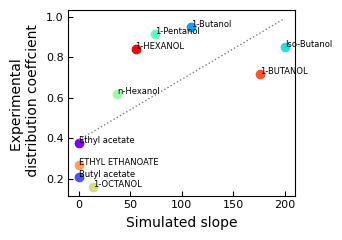

In [16]:
from scipy.optimize import curve_fit

def func(x,a,b,c):
    #return a*np.exp(b*x+c)
    return  a*x+b 


# 0-6 is paper data, 7-12 is Dupeng data
plot_data = [d for d in all_data if d[0] not in ['N-DODECANE','N-HEXADECANE']]

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
#axt = axs.twinx()

axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
axs.set_xlabel('Simulated slope',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(plot_data)) ]

xdat,ydat = [],[]
for n,d in enumerate(plot_data): 
    label = d[0]
    x = np.array([1,2,3])
    y = d[2:5]
    y_exp = np.mean(d[5:])
    
    # linear y=ax+b
    popt, pcov = curve_fit(func, x, y, maxfev=1000)
    print( d, popt )
    #yfit = func(x, *popt)
    fit_a = popt[0]
    axs.plot( fit_a, y_exp, color=colors[n], label=label, lw=2, ls='-', marker='o', ms=6)
    
    axs.annotate(label, xy=(fit_a, y_exp), fontsize=6)

    xdat.append(fit_a)
    ydat.append(y_exp)

xdat = np.array(xdat)
ydat = np.array(ydat)

#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
#axs.legend(fontsize=6, frameon=False, loc=0, ncol=2)


def func2(x,a,b):
    #return a*np.exp(b*x+c)
    return  a*x+b 
    #return a*np.log10(x+b)

popt, pcov = curve_fit(func2, xdat,ydat, maxfev=1000)
print(popt, pcov)
print('Fit RMSE error: ', np.sqrt(np.mean((ydat-func2(xdat, *popt))**2)) )
print( 'Check if overfitted:', np.linalg.cond(pcov), np.diag(pcov) )

xdat_fit = np.linspace( min(xdat), max(xdat),50 )
ydat_fit = func2(xdat_fit, *popt)
axs.plot( xdat_fit, ydat_fit, ls=':',marker='',lw=1,color='gray')

corr, _ = pearsonr( xdat,ydat )
print('Pearsons correlation: %.3f' % corr)

#plt.savefig('Compare.png', dpi=800)
plt.show()

# How about ML

In [14]:
## Remove data column with std=0
def clean_std(df):
    print('Before clean', df.shape )
    #X_features.loc[ :, X_features.std() > X_features.mean() ]
    df_new = df.loc[ :, df.std()>0 ]
    print('After clean', df_new.shape )
    return df_new

# Remove high correlated data, step by step
def remove_high_corr_gradually(df, cutoff=0.9, highlight=None):
    corr_matx = df.corr()
    #sns.heatmap(corr_matx.abs())
    # The upper triangle of absolute values
    upper_tri = corr_matx.abs().where(np.triu(np.ones(corr_matx.shape),k=1).astype(bool))
    upper_tri = upper_tri>cutoff
    
    for n in range(len(upper_tri)):
        if upper_tri.sum().sum()>0:
            ## Find which one has the most overlap 
            occur = upper_tri.sum(axis=0).add( upper_tri.sum(axis=1) ).sort_values(ascending=False)
            bad_fp = list( occur.index )[0]
            #print( bad_fp, occur[bad_fp])
            upper_tri.drop( bad_fp, axis=1, inplace=True)
            upper_tri.drop( bad_fp, axis=0, inplace=True)
        else:
            break
    
    print("Num of keep: ",len(upper_tri.columns))
    print("Num of drop: ",len(df.columns)-len(upper_tri.columns))
    print("---------")
    
    if highlight is not None:
        highlight = corr_matx[ highlight ]
        
    return  df[ upper_tri.columns ], highlight

## Standardization of a pd dataframe
def get_std(data_x):   
    scaler = StandardScaler()
    scaler.fit(data_x)
    X_scale = scaler.transform(data_x)
    data_new = pd.DataFrame(X_scale, columns=data_x.columns, index=data_x.index)
    return data_new, scaler  ## Save the new data, and its scaler

# Standardization of a dict of pd dataframe
def standard_dataset(dataset_dict):
    dataset_new = dataset_dict.copy()
    x_train, scaler = get_std(dataset_dict['x_train'])
    x_test = scaler.transform(dataset_dict['x_test'])
    x_test = pd.DataFrame(x_test, columns=dataset_dict['x_test'].columns, index=dataset_dict['x_test'].index)
    x_val = scaler.transform(dataset_dict['x_val'])
    x_val = pd.DataFrame(x_val, columns=dataset_dict['x_val'].columns, index=dataset_dict['x_val'].index)
    dataset_new['x_train'] = x_train
    dataset_new['x_test'] = x_test
    dataset_new['x_val'] = x_val
    dataset_new['scaler'] = scaler
    return dataset_new

## split train, text, valid
def split_data(x,y, rand_state=1, ignore_val=False):
    if rand_state>0:
        # Assign 20% data as testing data
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=rand_state, shuffle = True)
        # Assign 20% data as val data, so train data is 60%.  val size = 0.8*0.125 = 0.1
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=rand_state)  
    else:
        x_train, x_test, x_val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        y_train, y_test, y_val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        ref = x.iloc[0].values
        sel = x.values
        cosine = [ np.dot(s,ref)/(norm(s)*norm(sel)) for s in sel ]
        x['COS'] = cosine
        x = x.sort_values(by='COS', ascending=False)##.drop(['COS'],axis=1)
        y = y.loc[x.index]

        bmax,bmin = y.max(), y.min()
        bins = np.linspace(bmin,bmax,10)
        bins[0] = bins[0]-1
        bins[-1] = bins[-1]+1
        labels = np.arange(len(bins)-1)
        group = pd.cut(Y_prop, bins=bins, labels=labels)
        for b in labels:
            idx = group[ group==b ].index
            x1 = x.loc[idx].sort_values(by='COS', ascending=False).drop(['COS'],axis=1)
            y1 = y.loc[x1.index]
            x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size = 0.2, random_state=-rand_state, shuffle=True)
            x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.25, random_state=-rand_state, shuffle=True) 
            x_train= pd.concat( [x_train, x_train1], axis=0)
            x_test= pd.concat( [x_test, x_test1], axis=0)
            x_val= pd.concat( [x_val, x_val1], axis=0)
            y_train= pd.concat( [y_train, y_train1], axis=0)
            y_test= pd.concat( [y_test, y_test1], axis=0)
            y_val= pd.concat( [y_val, y_val1], axis=0)
        y_train = y_train.squeeze()
        y_test = y_test.squeeze()
        y_val = y_val.squeeze()
        
    if ignore_val:
        x_test = pd.concat( [x_test,x_val], axis=0 )
        y_test = pd.concat( [y_test,y_val], axis=0 )
        #x_val.drop(x_val.index, inplace=True)
        #y_val.drop(y_val.index, inplace=True)
        x_val = x_test.copy()
        y_val = y_test.copy()
    
    print("Train, Test, Val sizes are: ", x_train.shape, x_test.shape, x_val.shape)
    return  x_train, x_test, x_val, y_train, y_test, y_val

## Call lazypredictor
from lazypredict.Supervised import LazyRegressor

def do_lazy_regression(data_dict, ylabel=None, rg="all"):
    reg = LazyRegressor(verbose=2,ignore_warnings=False, custom_metric=None, regressors=rg)
    if ylabel is not None:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'][ylabel], data_dict['y_test'][ylabel])
    else:
        models,predictions = reg.fit(data_dict['x_train'], data_dict['x_test'], data_dict['y_train'], data_dict['y_test'])
    return models, predictions

def know_any_depth(x_train, y_train, x_test, y_test, model_algorithm, name='None', max_layer=20, vb=0):
    values = [i for i in range(1, max_layer)]  ## depth of tree
    train_scores, test_scores =[], []
    r2_train,rmse_train,r2_test,rmse_test = [],[],[],[]
    # evaluate a decision tree for each depth
    for i in values:
        model = model_algorithm(max_depth=i, verbose=vb)
        model.fit(x_train, y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        r2_train.append( metrics.r2_score(y_train, y_pred_train) )
        rmse_train.append( metrics.mean_squared_error(y_train, y_pred_train,))# squared=False) )
        r2_test.append( metrics.r2_score(y_test, y_pred_test) )
        rmse_test.append( metrics.mean_squared_error(y_test, y_pred_test, ))# squared=False) )
        # summarize progress
        print('>%d, train: %.3f, test: %.3f' % (i, r2_train[-1], r2_test[-1]))
    # plot of train and test scores vs tree depth
    fig, axs = plt.subplots(1,2,figsize=(7,3.5),tight_layout=True)
    axs[0].plot(values, r2_train, '-o', label='Train')
    axs[0].plot(values, r2_test, '-o', label='Test')
    axs[0].set_xticks( np.arange(1,max_layer+1,1) )
    axs[0].grid(axis='both',color='g')
    axs[0].legend()
    axs[0].set_title('R2')
    axs[1].plot(values, rmse_train, '-o', label='Train')
    axs[1].plot(values, rmse_test, '-o', label='Test')
    axs[1].set_xticks( np.arange(1,max_layer+1,1) )
    axs[1].grid(axis='both',color='g')
    axs[1].legend()
    axs[1].set_title('RMSE')
    #pyplot.savefig("testtrain90-10.png", dpi=300)
    plt.show()
    print("=============Done==============")
    
def model_any_fit(x_train,y_train, x_test,y_test, model_algorithm, name='None',vb=0, axs_lim=None,savefig=None, ml_parameter=None):
    if ml_parameter is None:
        model = model_algorithm( )
    else:
        model = model_algorithm( **ml_parameter )
    model = model.fit(x_train, y_train)
    y_pred_train=model.predict(x_train)
    y_pred_test=model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))    
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    print("================ Info =================")
    print(">>>>>> Train set", x_train.shape)
    print("R square score: " , r2_train)
    print("RMSE, MAE: ", rmse_train, mae_train)
    print(">>>>>> Test set", x_test.shape)
    print("R square score: " , r2_test)
    print("RMSE, MAE: ", rmse_test, mae_test)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True)
    axs.plot(y_train, y_pred_train, 'o', color='orange', label='Training',alpha=0.8, markersize=5)           # scatter plot showing actual data
    axs.plot(y_test, y_pred_test, 'v', color='g', label='Testing',alpha=0.5, markersize=3)           # scatter plot showing actual data
    axs.plot([-100,100], [-100,100], '--', color='k') 

    a_train, b_train = np.polyfit(y_train, y_pred_train, 1)
    a_test, b_test = np.polyfit(y_test, y_pred_test, 1)
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_train), np.amin(y_test)])-0.3
        ax_max = np.amax([np.amax(y_train), np.amax(y_test)])+0.3
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)

    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    axs.legend(fontsize=8, frameon=False,)
    plt.title(name)
        
    r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test = np.round([r2_train,rmse_train,mae_train,r2_test,rmse_test,mae_test], 2)
    performance_train = f'R$^2$: {r2_train}\nRMSE: {rmse_train}\nMAE: {mae_train}'
    performance_test = f'R$^2$: {r2_test}\nRMSE: {rmse_test}\nMAE: {mae_test}'
    axs.text(0.65,0.25, performance_train, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='orange')
    axs.text(0.65,0.05, performance_test,  style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white',color='g')

    if savefig is not None:
        plt.savefig(savefig, dpi=800)
    plt.show()
    return model

## Evaluate validation data
def score_val(x_val, y_val, model, name='',axs_lim=None, savefig=None, alpha=0.5, data_color=None):
    y_predict_val = model.predict(x_val)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,3.5),tight_layout=True )#,dpi=100)
    #axs.plot(y_val, y_predict_val, 'o', color='r',label='Validating')  
    
    x,y,z = color_density(y_val, y_predict_val)
    if data_color is not None:
        z = data_color
    #z = plt.cm.jet(z)            
    im = axs.scatter(x, y, marker='o', c=z, cmap='jet', label='Validating', alpha=alpha, s=10) 
    
    axs.plot([-100,100], [-100,100], '--', color='k', lw=1)
    
    a, b = np.polyfit(y_val, y_predict_val, 1)
    #axs.plot(y_val, a*y_val+b, color='r') 
    
    r2_val = metrics.r2_score(y_val, y_predict_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, y_predict_val))    
    mae_val = metrics.mean_absolute_error(y_val, y_predict_val)
    print(">>>>>> Val set", y_val.shape)
    print("R square score: " , r2_val)
    print("RMSE, MAE:", rmse_val, mae_val)
    
    #plt.text(-11,-6.5, 'R^2 = 0.811')
    if axs_lim is None:
        ax_min = np.amin([np.amin(y_val), np.amin(y_predict_val)])-0.1
        ax_max = np.amax([np.amax(y_val), np.amax(y_predict_val)])+0.1
        axs.set_xlim((ax_min,ax_max))
        axs.set_ylim((ax_min,ax_max))
    else:
        axs.set_xlim(axs_lim)
        axs.set_ylim(axs_lim)
    
    axs.set_xlabel('Reference ',fontsize=10) ## input X name
    axs.set_ylabel('ML prediction',fontsize=10) ## input Y name
    axs.tick_params(direction='in',labelsize=8)
    
    plt.title(name)
    #fig.colorbar(im, shrink=0.5, label='Density')

    r2_val, rmse_val, mae_val = np.round([r2_val, rmse_val, mae_val], 2)
    performance = f'R$^2$: {r2_val}\nRMSE: {rmse_val}\nMAE: {mae_val}'
    axs.text(0.6,0.05, performance, style='italic', fontsize=10, transform = axs.transAxes, backgroundcolor='white', color='k')
    
    #axs.legend(fontsize=8, frameon=False,)
    if savefig is not None:
        plt.savefig(savefig, dpi=800)      
    plt.show()
    
    return r2_val, rmse_val, mae_val
    
def color_density(x,y):
    x= np.array(x)
    y= np.array(y)
    xy = np.vstack([x, y])
    z = stats.gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x,y,z

def xyz_to_smiles(fname: str) -> str:
    mol = next(pybel.readfile("xyz", fname))
    smi = mol.write(format="smi")
    return smi.split()[0].strip()

def smiles_to_xyz_pybel(smi, if_write_xyz='molecule.xyz', if_overwrite=False):
    mol = pybel.readstring("smi", smi)
    mol.addh() # add Hs for 3D
    mol.make3D() # generate 3D coordinates
    if if_write_xyz is not None:
        xyz = mol.write(format='xyz',filename=if_write_xyz, overwrite=if_overwrite)
    else:
        xyz = mol.write(format='xyz')
    return xyz

In [15]:
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin

import xgboost
import lightgbm

removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression", 
    "CCA", 
    "IsotonicRegression", 
    "StackingRegressor",
    "MultiOutputRegressor", 
    "MultiTaskElasticNet", 
    "MultiTaskElasticNetCV", 
    "MultiTaskLasso", 
    "MultiTaskLassoCV", 
    "PLSCanonical", 
    "PLSRegression", 
    "RadiusNeighborsRegressor", 
    "RegressorChain", 
    "VotingRegressor",
    
    "PoissonRegressor",
    "QuantileRegressor",
]

chosen_regressors = [
    'SVR',
    'BaggingRegressor'
]

my_REGRESSORS = [
    est
    for est in all_estimators()
    #if (issubclass(est[1], RegressorMixin) and (est[0] in chosen_regressors))
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))  
]

my_REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
my_REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))

for i,r in enumerate(my_REGRESSORS):
    print(i, r[0])
    
def screen_ML_performance(X_prop, Y_prop, rand_state=10, if_std=False, if_switch_test_valid=False, ignore_val=False, regressors=my_REGRESSORS):
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=rand_state, ignore_val=ignore_val)
    sns.histplot(y_train, kde=True, color='r',  binwidth=0.5)
    sns.histplot(y_test, kde=True, color='g',  binwidth=0.5)
    sns.histplot(y_val, kde=True, color='b',  binwidth=0.5)
    plt.show()
    
    colors = ['orange','m','g','b','c','r']
    fig, axs = plt.subplots(3,1,figsize=(3.5,3.5) )#,tight_layout=True,dpi=100)
    axst = [a.twinx() for a in axs]
    bw = 0.2
    sns.histplot(y_train, kde=False, color='r', alpha=1, binwidth=bw, ax=axs[0], legend=False, fill=True, element="step", label='Training')
    sns.histplot(y_test,  kde=False, color='g', alpha=1, binwidth=bw, ax=axs[1], legend=False, fill=True, element="step", label='Testing')
    sns.histplot(y_val,   kde=False, color='b', alpha=1, binwidth=bw, ax=axs[2], legend=False, fill=True, element="step", label='Validation')
    sns.kdeplot(y_train, color='k', alpha=1, ax=axst[0], legend=False, fill=False)
    sns.kdeplot(y_test,  color='k', alpha=1, ax=axst[1], legend=False, fill=False)
    sns.kdeplot(y_val,   color='k', alpha=1, ax=axst[2], legend=False, fill=False)
    #sns.histplot(df_prop['y_train'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[0], x="LUMO", hue="diene_class", element="step", legend=True, multiple="stack")
    #sns.histplot(df_prop['y_test'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[1], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
    #sns.histplot(df_prop['y_val'], palette=colors, edgecolor=None, kde=False, alpha=0.6, binwidth=bw, ax=axs[2], x="LUMO", hue="diene_class", element="step", legend=False, multiple="stack")
    
    #legend = axs[0].get_legend()
    #handles = legend.legendHandles
    #legend.remove()
    #axs[0].legend(handles, ['N=0, Aliphatic','N=0','N=1'], fontsize=8, frameon=False, loc=2)
    tit = ['Training','Testing','Validating']
    ymax= [8.5,8.5,8.5]
    ytmax= [0.3, 0.3, 0.3]
    for n in range(3):
        axs[n].tick_params(direction='in',labelsize=8)
        axs[n].set_xlabel('', fontsize=10)
        axs[n].set_ylabel('') 
        axs[n].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[n].set_yticks(np.arange(0, 8, 2))
        axst[n].set_ylabel('') 
        axst[n].set_xlabel('') 
        axst[n].set_yticks( [] )
        axst[n].set_yticklabels([])
        axs[n].set_xlim((-3,5))
        axs[n].set_ylim([0,ymax[n]])
        axst[n].set_ylim([0,ytmax[n]])
        axs[n].legend(fontsize=8, frameon=False, loc=2) 
    axs[0].set_xticklabels([])
    axs[1].set_xticklabels([])
    axs[2].set_xlabel(r'$\Delta G$$_{2,3-BDO}$', fontsize=10)
    axs[1].set_ylabel('Number of data points', fontsize=10)

    plt.subplots_adjust(wspace=0, hspace=0.0)
    plt.savefig("spliting_detail.png", dpi=800)      
    plt.show()    
    
    df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    if if_switch_test_valid:
        df_prop = {'x_train':x_train, 'x_test':x_val, 'x_val':x_test, 'y_train':y_train, 'y_test':y_val, 'y_val':y_test}
        
    if if_std:
        df_prop = standard_dataset(df_prop)
        scaler = df_prop['scaler']
    else:
        scaler = None
    
    model_ml, lazy_ml = do_lazy_regression(df_prop, rg=regressors)
    
    rmse = model_ml[ model_ml['RMSE']<5 ].sort_values(by='RMSE',ascending=False)
    
    fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
    rmse.plot(kind='bar', y=['RMSE'], color=['blueviolet'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)
    
    axs.set_ylabel('Model RMSE', fontsize=10)
    axs.set_xlabel('ML models', fontsize=10)
    axs.set_xticklabels( [n for n in range(len(rmse))], rotation=0, ha='center')
    
    axt = axs.twinx()
    axt.set_xticks( [] )
    axt.set_ylabel('Model R$^2$', fontsize=10)
    rmse.plot(kind='line', y=['R-Squared'], color=['limegreen'], ax=axt, legend=False, fontsize=8, xlabel=None)
    axt.set_ylim((0,1))
    
    rr = np.round( [rmse['R-Squared'].tail(1), rmse['RMSE'].tail(1)], 2)
    rr = f'Best performance:\nRMSE={rr[1][0]}\nR2 score={rr[0][0]}'
    #axs.text(0.4,0.6, rr, style='italic', fontsize=12, transform = axs.transAxes, color='k')
    
    #axs.legend(fontsize=8, frameon=False)
    #axt.legend(fontsize=8, frameon=False)
    handles = axs.get_legend_handles_labels()[0]+axt.get_legend_handles_labels()[0]
    labels = axs.get_legend_handles_labels()[1]+['R$^2$']  ##axt.get_legend_handles_labels()[1]
    plt.legend( handles,labels, loc='upper center', fontsize=10, frameon=False,)#  bbox_to_anchor=(0.99, 0.5))
    
    plt.savefig("ml_modeling_selection.png", dpi=800)  
    plt.show()
    display(rmse)

0 AdaBoostRegressor
1 BaggingRegressor
2 BayesianRidge
3 DecisionTreeRegressor
4 DummyRegressor
5 ElasticNet
6 ElasticNetCV
7 ExtraTreeRegressor
8 ExtraTreesRegressor
9 GammaRegressor
10 GaussianProcessRegressor
11 GradientBoostingRegressor
12 HistGradientBoostingRegressor
13 HuberRegressor
14 KNeighborsRegressor
15 KernelRidge
16 Lars
17 LarsCV
18 Lasso
19 LassoCV
20 LassoLars
21 LassoLarsCV
22 LassoLarsIC
23 LinearRegression
24 LinearSVR
25 MLPRegressor
26 NuSVR
27 OrthogonalMatchingPursuit
28 OrthogonalMatchingPursuitCV
29 PassiveAggressiveRegressor
30 RANSACRegressor
31 RandomForestRegressor
32 Ridge
33 RidgeCV
34 SGDRegressor
35 SVR
36 TransformedTargetRegressor
37 TweedieRegressor
38 XGBRegressor
39 LGBMRegressor


In [16]:
#import lightgbm
from sklearn.model_selection import RandomizedSearchCV

def hyperparameter_tuning(X_prop, Y_prop, method, para_dict, name_header='ml', rand_state=1234, if_std=False, if_tuning=True):

    fp_name_prop = list( X_prop.columns )
    display( len(fp_name_prop) )
    
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=rand_state)
    df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}

    fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
    sns.histplot(y_train, kde=True, color='r',  label='Training', binwidth=0.5)
    sns.histplot(y_test, kde=True, color='g',  label='Testing', binwidth=0.5)
    sns.histplot(y_val, kde=True, color='b',  label='Validating', binwidth=0.5)
    axs.legend()
    plt.show()
    
    if if_std:
        df_prop = standard_dataset(df_prop)
        scaler = df_prop['scaler']
    else:
        scaler = None
                
    if if_tuning:
        random_search = RandomizedSearchCV(estimator=method(), param_distributions=para_dict, 
                                           n_iter=200, cv=3, scoring='neg_mean_absolute_error', verbose=0)
        random_search.fit( df_prop['x_train'], df_prop['y_train'] )
        
        display("Best hyperparameters:")
        parameter = random_search.best_params_
        for k,v in parameter.items():
            display(k,v)
        display("Best accuracy:", random_search.best_score_, )
        
        best_model = random_search.best_estimator_
        test_accuracy = best_model.score( df_prop['x_test'], df_prop['y_test'] )
        display("Test accuracy:", test_accuracy)
        
        model_all = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
                              model_algorithm=method, 
                              #vb=-1, name='', #savefig='TrainTesting.png', axs_lim=[-5,2], 
                              ml_parameter=parameter) #rf_nlayers, 
        score_val( df_prop['x_val'], df_prop['y_val'],  model_all, name='', data_color='b') #savefig='Validating.png', axs_lim=[-5,2] )
        
        file_model = f'model_{name_header}.pkl'
        joblib.dump(model_all, file_model)
        
        file_scaler = f'scaler_{name_header}.pkl'
        joblib.dump(scaler, file_scaler)
        
        file_feature=f'feature_{name_header}.json'
        with open(file_feature, 'w') as f1:
            json.dump(fp_name_prop, f1, indent=4) 
        display( f'=========== Saved {file_model} {file_feature} {file_scaler} to device ===========')
    else:                
        model_all = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
                              model_algorithm=method, vb=-1, name='')
        score_val( df_prop['x_val'], df_prop['y_val'],  model_all, name='', data_color='b')
    return scaler, fp_name_prop, model_all

## Generate rdkit FP

In [16]:
# If needed
bdo_all = solvation_data.copy() #.rename(columns={"deltaG_bdo": "deltaG_monomer"})
bdo_all

,SMILES,Inchi,deltaG_bdo,deltaG_wat
Solvent Name,,,,
DIIODOMETHANE,C(I)I,InChI=1S/CH2I2/c2-1-3/h1H2,4.37,4.80
CIS-DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.27,5.74
N-HEXADECANE,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.25,5.82
N-PENTADECANE,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.24,5.81
DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.21,5.73
...,...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.71,0.32
2-PROPANOL,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.76,0.32
1-PROPANOL,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.79,0.24


In [17]:
%%capture --no-display

from rdkit.ML.Descriptors import MoleculeDescriptors

fp_names_prop = [ n[0] for n in Descriptors._descList if not n[0].startswith('fr_')]
fp_names_prop.remove('Ipc')  ## https://github.com/rdkit/rdkit/issues/1527
print( len(fp_names_prop) )

calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_names_prop)

fp_data = []
for smi in bdo_all['SMILES']:
    try:
        fp = calc.CalcDescriptors( Chem.MolFromSmiles(smi) )
        fp_data.append( list(fp) )
    except:
        print(smi, 'has problem')

df_features_prop = pd.DataFrame(fp_data, columns=fp_names_prop, index=bdo_all.index)
#df_WatSol_features_prop.to_csv('df_WatSol_features_prop.csv')
#X_features_prop = X_features_prop.dropna(axis='columns')
df_features_prop

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumSpiroAtoms,NumUnspecifiedAtomStereoCenters,Phi,RingCount,MolLogP,MolMR
Solvent Name,,,,,,,,,,,,,,,,,,,,,
DIIODOMETHANE,2.28,2.28,1.19,1.19,0.46,6.00,267.83,265.82,267.82,20,...,0,0,0,0,0,0,5.14,0,1.81,32.91
CIS-DECALIN,1.56,1.56,1.16,1.16,0.48,40.80,138.25,120.11,138.14,58,...,0,2,0,2,0,0,1.97,2,3.37,43.92
N-HEXADECANE,2.29,2.29,1.37,1.37,0.31,10.88,226.45,192.18,226.27,98,...,13,0,0,0,0,0,15.00,0,6.49,75.99
N-PENTADECANE,2.29,2.29,1.37,1.37,0.34,10.80,212.42,180.16,212.25,92,...,12,0,0,0,0,0,14.00,0,6.10,71.37
DECALIN,1.56,1.56,1.16,1.16,0.48,40.80,138.25,120.11,138.14,58,...,0,2,0,2,0,0,1.97,2,3.37,43.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-METHYL-1-PROPANOL,8.14,8.14,0.31,0.31,0.48,9.60,74.12,64.04,74.07,32,...,1,0,0,0,0,0,2.19,0,0.63,21.92
2-PROPANOL,8.06,8.06,0.17,-0.17,0.43,9.00,60.10,52.03,60.06,26,...,0,0,0,0,0,0,1.28,0,0.39,17.35
1-PROPANOL,7.88,7.88,0.32,0.32,0.46,7.50,60.10,52.03,60.06,26,...,1,0,0,0,0,0,2.93,0,0.39,17.38


In [ ]:
#%%capture --no-display
# rdkit Morgan Fingerprint (ECFPx)  ECFP6 bits

rr = 3 # 3 for ML, 2 for similarity usually
nbits = 1024 # 1024 or 2048

fp_names_prop = [f'bit_{n}' for n in range(nbits)]

fp_data = []
for smi in solvation_data['SMILES']:
    try:
        fp = AllChem.GetMorganFingerprintAsBitVect( Chem.MolFromSmiles(smi), radius=rr, nBits=nbits) 
        fp_data.append( np.array( list(fp) , dtype=int) )
    except:
        print(smi, 'has problem')

df_features_prop = pd.DataFrame(fp_data, columns=fp_names_prop, index=solvation_data.index)
#df_WatSol_features_prop.to_csv('df_WatSol_features_prop.csv')
#X_features_prop = X_features_prop.dropna(axis='columns')
df_features_prop

In [18]:
%%capture --no-display

good_elements = ['C','H','O','N',]#'S']#,'P']
mask_element = []   ## molecules to keep, keep=True
for smi in bdo_all['SMILES']:
    mol = Chem.MolFromSmiles( smi )
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    if all(e in good_elements for e in element):
        mask_element.append(True)
    else:
        mask_element.append(False)

solvation_data = bdo_all[mask_element]
#df_watsol = df_watsol.reset_index(drop=True)
df_features_prop = df_features_prop[mask_element]

display( df_features_prop, solvation_data )

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumSpiroAtoms,NumUnspecifiedAtomStereoCenters,Phi,RingCount,MolLogP,MolMR
Solvent Name,,,,,,,,,,,,,,,,,,,,,
CIS-DECALIN,1.56,1.56,1.16,1.16,0.48,40.80,138.25,120.11,138.14,58,...,0,2,0,2,0,0,1.97,2,3.37,43.92
N-HEXADECANE,2.29,2.29,1.37,1.37,0.31,10.88,226.45,192.18,226.27,98,...,13,0,0,0,0,0,15.00,0,6.49,75.99
N-PENTADECANE,2.29,2.29,1.37,1.37,0.34,10.80,212.42,180.16,212.25,92,...,12,0,0,0,0,0,14.00,0,6.10,71.37
DECALIN,1.56,1.56,1.16,1.16,0.48,40.80,138.25,120.11,138.14,58,...,0,2,0,2,0,0,1.97,2,3.37,43.92
N-DODECANE,2.28,2.28,1.37,1.37,0.43,10.50,170.34,144.13,170.20,74,...,9,0,0,0,0,0,11.00,0,4.93,57.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-METHYL-1-PROPANOL,8.14,8.14,0.31,0.31,0.48,9.60,74.12,64.04,74.07,32,...,1,0,0,0,0,0,2.19,0,0.63,21.92
2-PROPANOL,8.06,8.06,0.17,-0.17,0.43,9.00,60.10,52.03,60.06,26,...,0,0,0,0,0,0,1.28,0,0.39,17.35
1-PROPANOL,7.88,7.88,0.32,0.32,0.46,7.50,60.10,52.03,60.06,26,...,1,0,0,0,0,0,2.93,0,0.39,17.38


,SMILES,Inchi,deltaG_bdo,deltaG_wat
Solvent Name,,,,
CIS-DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.27,5.74
N-HEXADECANE,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.25,5.82
N-PENTADECANE,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.24,5.81
DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.21,5.73
N-DODECANE,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,4.16,5.80
...,...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.71,0.32
2-PROPANOL,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.76,0.32
1-PROPANOL,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.79,0.24


In [19]:
solvation_data.to_csv('solvation_data_final.csv')
df_features_prop.to_csv('df_features_prop_final.csv')

In [ ]:
#sns.histplot(solvation_data, x='deltaG_bdo', kde=True, color='b',  binwidth=0.5)
sns.histplot(df_features_prop, x='MaxEStateIndex', kde=True,  binwidth=0.5, element='step',fill=False) #
sns.histplot(df_features_prop, x='MinEStateIndex', kde=True,  binwidth=0.5, element='step',fill=False) 
plt.show()


# For BDO data

In [210]:
solvation_data = pd.read_csv('solvation_data_final.csv', index_col=0) ##.set_index('Solvent Name')
df_features_prop = pd.read_csv('df_features_prop_final.csv', index_col=0)
display( solvation_data, df_features_prop )

,SMILES,Inchi,deltaG_bdo,deltaG_wat
Solvent Name,,,,
CIS-DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.27,5.74
N-HEXADECANE,CCCCCCCCCCCCCCCC,InChI=1S/C16H34/c1-3-5-7-9-11-13-15-16-14-12-1...,4.25,5.82
N-PENTADECANE,CCCCCCCCCCCCCCC,InChI=1S/C15H32/c1-3-5-7-9-11-13-15-14-12-10-8...,4.24,5.81
DECALIN,C1CCC2CCCCC2C1,InChI=1S/C10H18/c1-2-6-10-8-4-3-7-9(10)5-1/h9-...,4.21,5.73
N-DODECANE,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,4.16,5.80
...,...,...,...,...
2-METHYL-1-PROPANOL,CC(C)CO,"InChI=1S/C4H10O/c1-4(2)3-5/h4-5H,3H2,1-2H3",-1.71,0.32
2-PROPANOL,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.76,0.32
1-PROPANOL,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.79,0.24


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumSpiroAtoms,NumUnspecifiedAtomStereoCenters,Phi,RingCount,MolLogP,MolMR
Solvent Name,,,,,,,,,,,,,,,,,,,,,
CIS-DECALIN,1.56,1.56,1.16,1.16,0.48,40.80,138.25,120.11,138.14,58,...,0,2,0,2,0,0,1.97,2,3.37,43.92
N-HEXADECANE,2.29,2.29,1.37,1.37,0.31,10.88,226.45,192.18,226.27,98,...,13,0,0,0,0,0,15.00,0,6.49,75.99
N-PENTADECANE,2.29,2.29,1.37,1.37,0.34,10.80,212.42,180.16,212.25,92,...,12,0,0,0,0,0,14.00,0,6.10,71.37
DECALIN,1.56,1.56,1.16,1.16,0.48,40.80,138.25,120.11,138.14,58,...,0,2,0,2,0,0,1.97,2,3.37,43.92
N-DODECANE,2.28,2.28,1.37,1.37,0.43,10.50,170.34,144.13,170.20,74,...,9,0,0,0,0,0,11.00,0,4.93,57.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2-METHYL-1-PROPANOL,8.14,8.14,0.31,0.31,0.48,9.60,74.12,64.04,74.07,32,...,1,0,0,0,0,0,2.19,0,0.63,21.92
2-PROPANOL,8.06,8.06,0.17,-0.17,0.43,9.00,60.10,52.03,60.06,26,...,0,0,0,0,0,0,1.28,0,0.39,17.35
1-PROPANOL,7.88,7.88,0.32,0.32,0.46,7.50,60.10,52.03,60.06,26,...,1,0,0,0,0,0,2.93,0,0.39,17.38


In [211]:
X_prop = df_features_prop.copy()
Y_prop = solvation_data['deltaG_bdo']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_prop = X_prop.select_dtypes(include=numerics)
X_prop = clean_std(X_prop)
X_prop,_ = remove_high_corr_gradually(X_prop, cutoff=0.75)
#mask_zscore = np.abs( stats.zscore(X_features_prop_clean) )
#X_features_prop_clean = X_features_prop_clean[ (mask_zscore<10).all(axis=1) ]

Before clean (130, 131)
After clean (130, 121)
Num of keep:  64
Num of drop:  57
---------


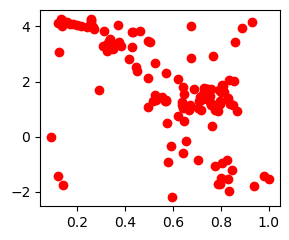

Solvent Name
1-BUTANOL             1.00
1-PENTANOL            0.98
1-PROPANOL            0.94
HEXANOIC ACID         0.93
PENTANOIC ACID        0.89
                      ... 
N-HEXADECANE          0.13
BENZENE               0.13
2-METHYL-2-PROPANOL   0.12
CYCLOHEXANE           0.12
WATER                 0.09
Name: COS, Length: 130, dtype: float64

In [212]:
## Re-order by COS?
from numpy.linalg import norm

ref = X_prop.loc['1-BUTANOL'].values
sel = X_prop.values

cosine = np.dot(sel,ref)/(norm(sel,axis=1)*norm(ref))
X_prop['COS'] = cosine

fig, axs = plt.subplots(1,1,figsize=(3,2.5),tight_layout=True,dpi=100)
axs.plot(X_prop['COS'], Y_prop, color='r', lw=2, ls='', marker='o', ms=6) 
plt.show()

display( X_prop.sort_values(by='COS', ascending=False)['COS'] )

X_prop = X_prop.sort_values(by='COS', ascending=False).drop(['COS'],axis=1)
Y_prop = Y_prop.loc[X_prop.index]


In [ ]:
# Remove COS outliners?
from numpy.linalg import norm

ref = X_prop.loc['1-BUTANOL'].values
sel = X_prop.values

cosine = np.dot(sel,ref)/(norm(sel,axis=1)*norm(ref))
X_prop['COS'] = cosine

X_prop = X_prop[ X_prop['COS']>0. ] 
Y_prop = Y_prop.loc[X_prop.index]
display( X_prop.sort_values(by='COS', ascending=False)['COS'] )

X_prop = X_prop.drop(['COS'],axis=1)

In [185]:
for i,r in enumerate(my_REGRESSORS):
    print(i, r[0])
used_regressor = [3,7,8,10,11,12,14,23,24,31,35,38,39]
used_regressor =[8, 39]
used_regressor = [ my_REGRESSORS[n] for n in used_regressor ]

used_regressor

0 AdaBoostRegressor
1 BaggingRegressor
2 BayesianRidge
3 DecisionTreeRegressor
4 DummyRegressor
5 ElasticNet
6 ElasticNetCV
7 ExtraTreeRegressor
8 ExtraTreesRegressor
9 GammaRegressor
10 GaussianProcessRegressor
11 GradientBoostingRegressor
12 HistGradientBoostingRegressor
13 HuberRegressor
14 KNeighborsRegressor
15 KernelRidge
16 Lars
17 LarsCV
18 Lasso
19 LassoCV
20 LassoLars
21 LassoLarsCV
22 LassoLarsIC
23 LinearRegression
24 LinearSVR
25 MLPRegressor
26 NuSVR
27 OrthogonalMatchingPursuit
28 OrthogonalMatchingPursuitCV
29 PassiveAggressiveRegressor
30 RANSACRegressor
31 RandomForestRegressor
32 Ridge
33 RidgeCV
34 SGDRegressor
35 SVR
36 TransformedTargetRegressor
37 TweedieRegressor
38 XGBRegressor
39 LGBMRegressor


[('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('LGBMRegressor', lightgbm.sklearn.LGBMRegressor)]

100

200

300

400

500

600

700

800

900

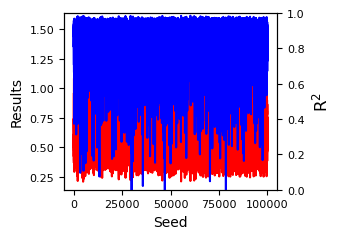

,R-Squared,RMSE,Seed
Model,,,
ExtraTreesRegressor,0.98,0.21,4900
ExtraTreesRegressor,0.98,0.21,55464
ExtraTreesRegressor,0.98,0.21,60262
ExtraTreesRegressor,0.98,0.21,2117
ExtraTreesRegressor,0.98,0.22,45788
...,...,...,...
LGBMRegressor,0.16,1.53,10342
LGBMRegressor,0.23,1.53,71563
ExtraTreesRegressor,0.10,1.54,3414


In [186]:
%%capture --no-display

# Try a seed screen? it takes 30 min to 1 hr

def optimize_ML_performance(X_prop, Y_prop, rand_state=10, if_std=False, if_switch_test_valid=False, ignore_val=False):
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=rand_state, ignore_val=ignore_val)
    
    df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    if if_switch_test_valid:
        df_prop = {'x_train':x_train, 'x_test':x_val, 'x_val':x_test, 'y_train':y_train, 'y_test':y_val, 'y_val':y_test}
    if if_std:
        df_prop = standard_dataset(df_prop)
        scaler = df_prop['scaler']
    else:
        scaler = None
        
    model_ml, lazy_ml = do_lazy_regression(df_prop, rg=used_regressor)
    rmse = model_ml[ model_ml['RMSE']<5 ].sort_values(by='RMSE',ascending=True)
    result = rmse.head(1)
    result['Seed'] = rand_state
    return result[ ['R-Squared','RMSE','Seed'] ]


performance = pd.DataFrame()
for rd in range(1,1000):
    if rd%100==0:
        display(rd)
    rand_num = np.random.randint(100, size=20) # random int from 0 to 99
    rd = rd*100 + np.array( list(set(rand_num)) )
    for r in rd:
        r = optimize_ML_performance(X_prop, Y_prop, rand_state=r, if_std=True, if_switch_test_valid=False, ignore_val=True)
        performance = pd.concat( [performance, r], axis=0 )
    
fig, axs = plt.subplots(1,1,  figsize=(3.5,2.5),tight_layout=True)
performance.plot(kind='line', x='Seed', y='RMSE', color=['red'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)
axs.set_ylabel('Results', fontsize=10)
axs.set_xlabel('Seed', fontsize=10)
#axs.set_xticklabels( [n for n in range(len(rmse))], rotation=0, ha='center')
axt = axs.twinx()
#axt.set_xticks( [] )
axt.set_ylabel('R$^2$', fontsize=12)
performance.plot(kind='line', x='Seed', y='R-Squared', color=['blue'], ax=axt, legend=False, fontsize=8)#, xlabel=None)
axt.set_ylim((0,1))
#plt.savefig("ml_modeling_selection.png", dpi=800)  
plt.show()

display( performance.sort_values(by='RMSE', ascending=True) )

In [187]:
performance = performance.sort_values(by='RMSE', ascending=True)
performance.to_csv('seed.csv')
performance.head(20)

,R-Squared,RMSE,Seed
Model,,,
ExtraTreesRegressor,0.98,0.21,4900
ExtraTreesRegressor,0.98,0.21,55464
ExtraTreesRegressor,0.98,0.21,60262
ExtraTreesRegressor,0.98,0.21,2117
ExtraTreesRegressor,0.98,0.22,45788
ExtraTreesRegressor,0.98,0.22,62227
ExtraTreesRegressor,0.98,0.22,29389
ExtraTreesRegressor,0.98,0.23,23296
ExtraTreesRegressor,0.98,0.23,63004


In [188]:
%%capture --no-display
    
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': np.arange(4, 25),
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_features': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'max_leaf_nodes': np.arange(5, 25),
}

exp_data = pd.read_csv('df_performance.csv', index_col=0)
mask = exp_data['type']=='r'
    
performance = pd.read_csv('seed.csv', index_col=0)
performance = performance.head(50)

new_result = []
for iseed, seed in enumerate(performance['Seed']):
    if iseed%10==0:
        display( iseed )
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=seed, ignore_val=True )
    df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    df_prop = standard_dataset(df_prop)
    
    model_method = ExtraTreesRegressor
    random_search = RandomizedSearchCV(estimator=model_method(), param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_absolute_error', verbose=0)
    random_search.fit( df_prop['x_train'], df_prop['y_train'] )
    
    #parameter = random_search.best_params_
    model_bdo = random_search.best_estimator_    
    #model_bdo = model_method( **parameter )
    #model_bdo = model_bdo.fit(df_prop['x_train'], df_prop['y_train'])
    feature_bdo = list( df_prop['x_train'].columns )
    scaler_bdo = df_prop['scaler']

    y_test_predict = model_bdo.predict(df_prop['x_test'].values) 
    r2 = metrics.r2_score( df_prop['y_test'], y_test_predict )   ###
    rmse = metrics.mean_squared_error(  df_prop['y_test'], y_test_predict, squared=False)   ###
    
    fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_bdo)
    fps = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in list(exp_data['SMILES'])]
    new_df = pd.DataFrame( data=fps, columns=feature_bdo )
    new_df = scaler_bdo.transform(new_df)
    predict_new = model_bdo.predict(new_df)

    sim = -predict_new/(2.303*1.987*0.001*(273.15+25)) 
    sim = np.power( 10, sim) 
    exp_data['ML'] = sim

    fit_a,fit_b = np.polyfit( exp_data['ML'][mask], exp_data['Kd 20C'][mask], 1)
    exp_data['ML_K'] = fit_a*sim + fit_b

    r2_1 = metrics.r2_score(  exp_data['ML_K'], exp_data['Kd 20C'] )  ###
    rmse_1 = metrics.mean_squared_error(  exp_data['ML_K'], exp_data['Kd 20C'], squared=False)   ###
    
    new_result.append( [ r2, rmse, r2_1, rmse_1 ] )

new_result = np.transpose( new_result )
performance['Test_R2'] = new_result[0]
performance['Test_RMSE'] = new_result[1]
performance['NewExp_R2'] = new_result[2]
performance['NewExp_RMSE'] = new_result[3]

performance.sort_values(by='NewExp_RMSE', ascending=True)

4900

55464

60262

2117

45788

62227

29389

23296

63004

5334

57389

14732

4394

26797

49504

68308

91043

30627

14188

29104

66883

89339

98043

85731

80830

75158

66614

19744

92930

69291

86002

26638

79955

69541

50489

99592

96532

6000

77217

14357

29342

88453

1781

80450

94001

45347

65485

72832

43790

33400

,R-Squared,RMSE,Seed,Test_R2,Test_RMSE,NewExp_R2,NewExp_RMSE
Model,,,,,,,
ExtraTreesRegressor,0.98,0.23,63004,0.97,0.28,0.77,0.09
ExtraTreesRegressor,0.97,0.26,14357,0.97,0.30,0.80,0.09
ExtraTreesRegressor,0.98,0.25,26638,0.96,0.35,0.79,0.09
ExtraTreesRegressor,0.97,0.26,33400,0.97,0.29,0.80,0.09
ExtraTreesRegressor,0.98,0.24,57389,0.96,0.29,0.76,0.10
ExtraTreesRegressor,0.97,0.25,86002,0.97,0.27,0.73,0.10
ExtraTreesRegressor,0.97,0.25,66883,0.96,0.30,0.72,0.10
ExtraTreesRegressor,0.98,0.22,29389,0.97,0.31,0.71,0.10
ExtraTreesRegressor,0.98,0.24,4394,0.97,0.31,0.66,0.11


In [190]:
%%capture --no-display
    
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': np.arange(4, 25),
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_features': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'max_leaf_nodes': np.arange(5, 25),
}

exp_data = pd.read_csv('df_performance.csv', index_col=0)
mask = exp_data['type']=='r'
    
performance2 = pd.read_csv('seed.csv', index_col=0)
performance2 = performance2.head(500)

new_result = []
for iseed, seed in enumerate(performance2['Seed']):
    if iseed%100==0:
        display( iseed )
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=seed, ignore_val=True )
    df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    df_prop = standard_dataset(df_prop)
    
    model_method = ExtraTreesRegressor
    #random_search = RandomizedSearchCV(estimator=model_method(), param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_absolute_error', verbose=0)
    #random_search.fit( df_prop['x_train'], df_prop['y_train'] )
    #parameter = random_search.best_params_
    #model_bdo = random_search.best_estimator_    
    model_bdo = model_method(  )
    model_bdo = model_bdo.fit( df_prop['x_train'], df_prop['y_train'] )
    feature_bdo = list( df_prop['x_train'].columns )
    scaler_bdo = df_prop['scaler']

    y_test_predict = model_bdo.predict(df_prop['x_test'].values) 
    r2 = metrics.r2_score( df_prop['y_test'], y_test_predict )   ###
    rmse = metrics.mean_squared_error(  df_prop['y_test'], y_test_predict, squared=False)   ###
    
    fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_bdo)
    fps = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in list(exp_data['SMILES'])]
    new_df = pd.DataFrame( data=fps, columns=feature_bdo )
    new_df = scaler_bdo.transform(new_df)
    predict_new = model_bdo.predict(new_df)

    sim = -predict_new/(2.303*1.987*0.001*(273.15+25)) 
    sim = np.power( 10, sim) 
    exp_data['ML'] = sim

    fit_a,fit_b = np.polyfit( exp_data['ML'][mask], exp_data['Kd 20C'][mask], 1)
    exp_data['ML_K'] = fit_a*sim + fit_b

    r2_1 = metrics.r2_score(  exp_data['ML_K'], exp_data['Kd 20C'] )  ###
    rmse_1 = metrics.mean_squared_error(  exp_data['ML_K'], exp_data['Kd 20C'], squared=False)   ###
    
    new_result.append( [ r2, rmse, r2_1, rmse_1 ] )

new_result = np.transpose( new_result )
performance2['Test_R2'] = new_result[0]
performance2['Test_RMSE'] = new_result[1]
performance2['NewExp_R2'] = new_result[2]
performance2['NewExp_RMSE'] = new_result[3]

performance2.sort_values(by=['NewExp_RMSE','NewExp_R2'], ascending=True)

0

100

200

300

400

,R-Squared,RMSE,Seed,Test_R2,Test_RMSE,NewExp_R2,NewExp_RMSE
Model,,,,,,,
ExtraTreesRegressor,0.96,0.32,21305,0.97,0.30,0.85,0.08
ExtraTreesRegressor,0.95,0.35,34524,0.96,0.32,0.85,0.08
ExtraTreesRegressor,0.96,0.34,50684,0.96,0.35,0.82,0.08
ExtraTreesRegressor,0.95,0.34,69905,0.96,0.32,0.85,0.08
ExtraTreesRegressor,0.96,0.34,48508,0.96,0.37,0.87,0.08
...,...,...,...,...,...,...,...
ExtraTreesRegressor,0.97,0.32,92911,0.97,0.31,-0.44,0.17
ExtraTreesRegressor,0.96,0.34,80897,0.96,0.32,-0.11,0.17
ExtraTreesRegressor,0.97,0.29,29440,0.97,0.29,-0.55,0.17


Train, Test, Val sizes are:  (78, 64) (52, 64) (26, 64)


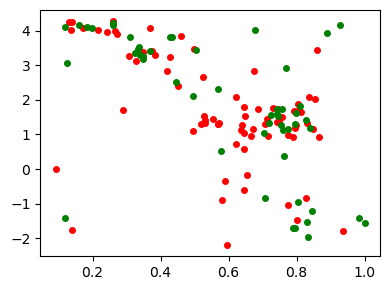

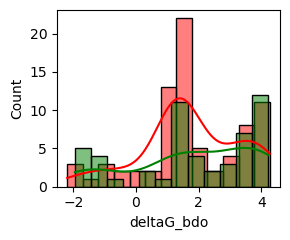

In [214]:
from numpy.linalg import norm

ref = np.array( X_prop.loc['1-BUTANOL'].values )

random_seed = 396673 #365901 

x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=random_seed, ignore_val=True )
df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
df_prop = standard_dataset(df_prop)

if True:
    x_train['COS'] = np.dot(x_train,ref)/(norm(x_train,axis=1)*norm(ref))
    x_test['COS'] = np.dot(x_test,ref)/(norm(x_test,axis=1)*norm(ref))
    x_val['COS'] = np.dot(x_val,ref)/(norm(x_val,axis=1)*norm(ref))

fig, axs = plt.subplots(1,1,figsize=(4,3),tight_layout=True,dpi=100)
axs.plot(x_train['COS'], y_train, color='r', lw=2, ls='', marker='o', ms=4) 
axs.plot(x_test['COS'], y_test, color='g', lw=2, ls='', marker='o', ms=4) 
#axs.plot(x_val['COS'], y_val, color='b', lw=2, ls='', marker='o', ms=4) 
plt.show()

fig, axs = plt.subplots(1,1,figsize=(3,2.5),tight_layout=True,dpi=100)
sns.histplot(y_train, kde=True, color='r',  binwidth=0.5)
sns.histplot(y_test, kde=True, color='g',  binwidth=0.5)
#sns.histplot(y_val, kde=True, color='b',  binwidth=0.5)
plt.show()


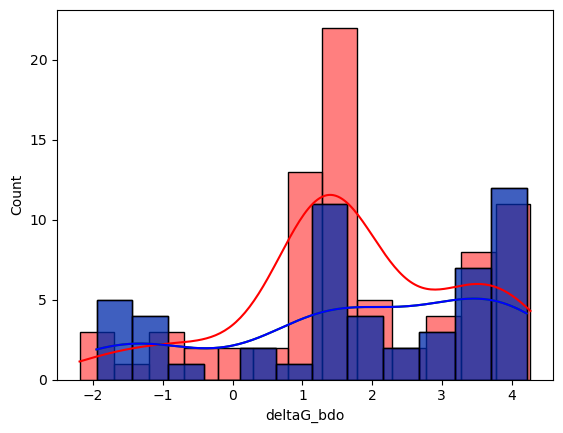

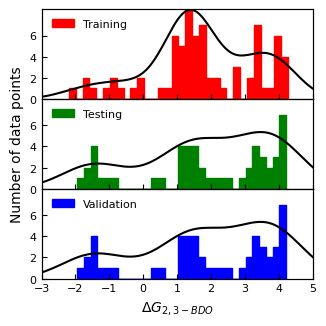

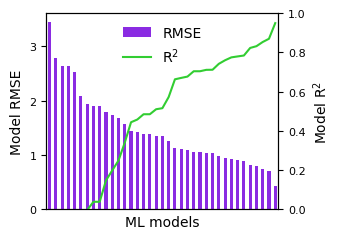

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,13.41,-2.16,3.44,0.51
KernelRidge,9.16,-1.08,2.79,0.02
LinearRegression,8.30,-0.86,2.64,0.02
TransformedTargetRegressor,8.30,-0.86,2.64,0.02
LassoLarsIC,7.74,-0.72,2.54,0.08
GaussianProcessRegressor,5.57,-0.16,2.09,0.02
DummyRegressor,4.94,-0.00,1.94,0.02
LassoLars,4.77,0.04,1.90,0.02
Lasso,4.77,0.04,1.90,0.02


In [248]:
%%capture --no-display

#random_seed = 50 # 126843 for not-reordered, no S
screen_ML_performance(X_prop, Y_prop, rand_state=random_seed, if_std=True, if_switch_test_valid=False, ignore_val=True)

'Best hyperparameters:'

'n_estimators'

100

'max_leaf_nodes'

np.int64(19)

'max_features'

1.0

'max_depth'

np.int64(18)

'Best accuracy:'

np.float64(-0.2688920758389851)

396673

'Para: 0.9903847277058752 0.03606235905977713'

'Exp: 0.8280966222942008 0.01082898033495715'

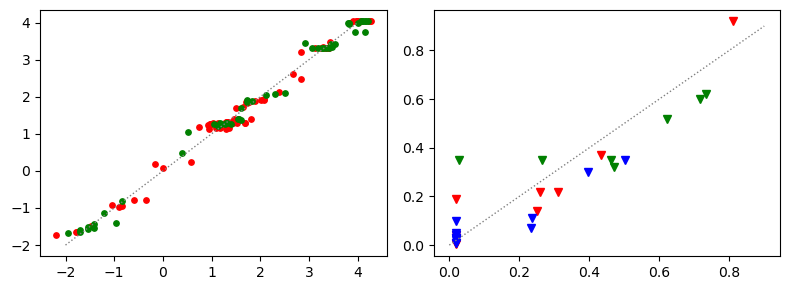

In [227]:
%%capture --no-display

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV


exp_data = pd.read_csv('df_performance.csv', index_col=0)
mask = exp_data['type']=='r'

model_method = ExtraTreesRegressor

if_cross_validate = True
if not if_cross_validate:
    model_bdo = model_method( )
    model_bdo = model_bdo.fit( df_prop['x_train'], df_prop['y_train'] )
else:
    df_x = pd.concat( [df_prop['x_train'],df_prop['x_test']], axis=0 )
    df_y = pd.concat( [df_prop['y_train'],df_prop['y_test']], axis=0 )
    param_dist = {
        'max_depth': np.arange(4, 25),
        'n_estimators': [10, 25, 50, 100, 150, 200, 250, 300, 350],
        'max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
        'max_leaf_nodes': np.arange(3, 20),
    }
    random_search = RandomizedSearchCV(estimator=model_method(), param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_absolute_error', verbose=0)
    #random_search.fit( df_prop['x_train'], df_prop['y_train'] )
    random_search.fit( df_x, df_y )
    model_bdo = random_search.best_estimator_   
    
    display("Best hyperparameters:")
    parameter = random_search.best_params_
    for k,v in parameter.items():
        display(k,v)
    display("Best accuracy:", random_search.best_score_, )

#random_search = RandomizedSearchCV(estimator=model_method(), param_distributions=param_dist, n_iter=100, cv=3, scoring='neg_mean_absolute_error', verbose=0)
#random_search.fit( df_prop['x_train'], df_prop['y_train'] )
#parameter = random_search.best_params_

feature_bdo = list( df_prop['x_train'].columns )
scaler_bdo = df_prop['scaler']

y_train_predict = model_bdo.predict(df_prop['x_train'].values)
y_test_predict = model_bdo.predict(df_prop['x_test'].values) 
r2 = metrics.r2_score( df_prop['y_test'], y_test_predict )   ###
rmse = metrics.mean_squared_error(  df_prop['y_test'], y_test_predict, )#squared=False)   ###

fig, axs = plt.subplots(1,2,figsize=(8,3),tight_layout=True,dpi=100)
## Left plot - parameterization
dx = [df_prop['y_train'].values, df_prop['y_test'].values ]
dy = [y_train_predict, y_test_predict]
colors = ['r','g']
for x,y,c in zip(dx,dy,colors):
    axs[0].scatter(x,y,  marker='o', c=c, s=15) 
axs[0].plot( [-2,4], [-2,4], ls=':',marker='',lw=1,color='gray')

## Right plot - Sim vs Exp
fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(feature_bdo)
fps = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in list(exp_data['SMILES'])]
new_df = pd.DataFrame( data=fps, columns=feature_bdo )
new_df = scaler_bdo.transform(new_df)
predict_new = model_bdo.predict(new_df)

sim = -predict_new/(2.303*1.987*0.001*(273.15+25)) 
sim = np.power( 10, sim) 
exp_data['ML'] = sim
fit_a,fit_b = np.polyfit( exp_data['ML'][mask], exp_data['Kd 20C'][mask], 1)
exp_data['ML_K'] = fit_a*sim + fit_b

r2_1 = metrics.r2_score(  exp_data['ML_K'], exp_data['Kd 20C'] )  ###
rmse_1 = metrics.mean_squared_error(  exp_data['ML_K'], exp_data['Kd 20C'], )#squared=False)   ###
display( random_seed, f'Para: {r2} {rmse}', f'Exp: {r2_1} {rmse_1}' )

for s,e,c,b in zip( exp_data['ML_K'], exp_data['Kd 20C'],exp_data['type'], exp_data['Solvent'] ):
    axs[1].plot( s, e, color=c, label=b, lw=2, ls='', marker='v', ms=6) 
axs[1].plot( [0,0.9], [0,0.9], ls=':',marker='',lw=1,color='gray')

plt.show()

name_header = 'manually'
file_model = f'model_bdo_{name_header}.pkl'
joblib.dump(model_bdo, file_model)

file_scaler = f'scaler_bdo_{name_header}.pkl'
joblib.dump(scaler_bdo, file_scaler)

file_feature=f'feature_bdo_{name_header}.json'
with open(file_feature, 'w') as f1:
    json.dump( feature_bdo, f1, indent=4) 

## SVR model

In [53]:
feature_bdo = list(X_prop.columns)

Train, Test, Val sizes are:  (78, 65) (26, 65) (26, 65)


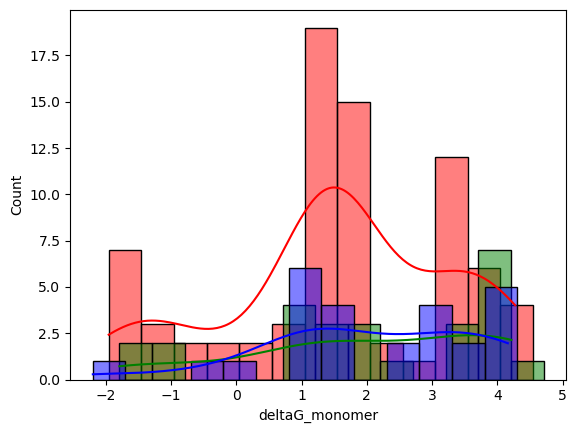

0.9264947490915783 0.8386012702366531 0.42731612225339144


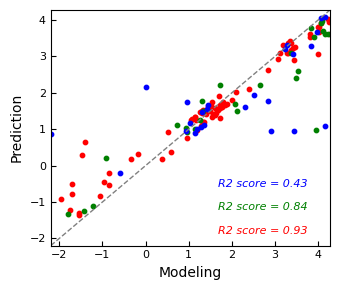

In [54]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=random_seed)
df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
sns.histplot(y_train, kde=True, color='r',  binwidth=0.5)
sns.histplot(y_test, kde=True, color='g',  binwidth=0.5)
sns.histplot(y_val, kde=True, color='b',  binwidth=0.5)
plt.show()

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
#regr = SVR() #C=1.0, epsilon=0.2)

regr.fit(df_prop['x_train'], df_prop['y_train'])

train_score = regr.score(df_prop['x_train'], df_prop['y_train'])
test_score = regr.score(df_prop['x_test'], df_prop['y_test'])
val_score = regr.score(df_prop['x_val'], df_prop['y_val'])

print(train_score, test_score, val_score)

y_train_predict = regr.predict(df_prop['x_train'].values)
y_test_predict = regr.predict(df_prop['x_test'].values)
y_val_predict = regr.predict(df_prop['x_val'].values)

dx = [df_prop['y_train'].values, df_prop['y_test'].values, df_prop['y_val'].values]
dy = [y_train_predict, y_test_predict, y_val_predict]
colors = ['r','g','b']

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

axlim = [100000,-1000000]
for x,y,c in zip(dx,dy,colors):
    axs.scatter(x,y,  marker='o', c=c, s=10)  
    if np.amin([x,y])<axlim[0]:
        axlim[0] = np.amin([x,y])
    if np.amax([x,y])>axlim[1]:
        axlim[1] = np.amax([x,y])
axs.plot(axlim,axlim, '--', color='gray', lw=1)

axs.set_xlim(axlim)
axs.set_ylim(axlim)

#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
axs.set_xlabel('Modeling',fontsize=10) ## input X name
axs.set_ylabel('Prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

for n,s in enumerate([train_score, test_score, val_score]):
    axs.text(0.6,0.05+0.1*n, f'R2 score = {round(s,2)}', style='italic', fontsize=8, transform = axs.transAxes, color=colors[n])

plt.show()


In [87]:
## Make prdiction on one new data point
from rdkit.ML.Descriptors import MoleculeDescriptors

def predict_rdkfp(smi, fp_name, model, scaler=None, fp_calc=None):
    """
    smi = a list of SMILES
    """
    if fp_calc==None:
        fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
    fps = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in smi]
    new_df = pd.DataFrame( data=fps, columns=fp_name )
    if scaler is not None:
        new_df = scaler.transform(new_df)
    predict_new = model.predict(new_df)
    
    return predict_new

Ethyl acetate [0.30596789]
Butyl acetate [0.25132494]
1-Butanol [2.88667463]
Iso-Butanol [3.23365605]
1-Pentanol [2.65692292]
n-Hexanol [2.30872596]
Iso-pentanol (0.8, 0.9) 1.0758891135584665
2-Ethyl-1-hexanol (0.99, 2.04) 0.7203652619742593
Oleyl alcohol (2.13, 5.81) 0.2547418808365773
0.2180265686353944 0.23107621230764136


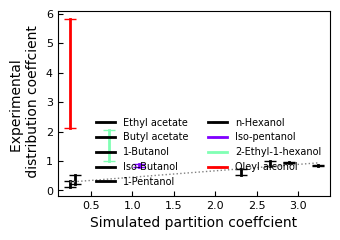

In [88]:
# Compare to exp data
paper_data = {
    'Ethyl acetate': [318.2, (0.22,0.54), 'CCOC(=O)C', 0.902],
    'Butyl acetate': [318.2, (0.11,0.31), 'CCCCOC(=O)C', 0.882],
    '1-Butanol':     [318.2, (0.94,0.96), 'CCCCO', 0.81],
    'Iso-Butanol':   [318.2, (0.83,0.87), 'CC(C)CO', 0.802],
    '1-Pentanol':    [318.2, (0.82,1.01), 'CCCCCO', 0.811],
    'Iso-pentanol':  [318.2, (0.80,0.90), 'CC(C)CCO', 0.825],
    'n-Hexanol':     [318.2, (0.51,0.73), 'CCCCCCO', 0.814],
    '2-Ethyl-1-hexanol': [315.2, (0.99,2.04), 'CCCCC(CC)CO', 0.833],
    'Oleyl alcohol': [314.2, (2.13,5.81), 'CCCCCCCC/C=C\CCCCCCCCO', 0.849],
}

# Which solvent is in our DFT result
fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)

included_data = [k for k,v in paper_data.items() if v[2] in list(solvation_bdo['SMILES'])]
not_included = [k for k in paper_data.keys() if k not in included_data]

labels = included_data
colors = ['k' for n in np.linspace(0,1,len(included_data)) ]

final_x,final_y = [],[]
for n,d in enumerate(included_data):
    temp_K = paper_data[d][0]
    exp = paper_data[d][1]
    #exp = np.log10(exp)
    
    sim = solvation_bdo[ solvation_bdo['SMILES']==paper_data[d][2] ]['deltaG_Sol-Wat(kcal/mol)'].values
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    #sim = np.power( 10, sim)
    sim = np.exp(sim)
    
    #sim = sim/paper_data[d][3]
    print(d,sim)
    
    axs.plot((sim,sim), exp, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    
    final_x.append( sim )
    final_y.append( np.mean(exp) )

labels = not_included
colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(not_included)) ]

for n,d in enumerate(not_included):
    temp_K = paper_data[d][0]
    exp = paper_data[d][1]
    
    sim = paper_data[d][2]
    sim = predict_rdkfp( [sim], feature_bdo, regr)
    sim = -sim[0]/(2.303*1.987*0.001*temp_K)
    sim = np.exp(sim)
    print(d,exp,sim)

    axs.plot((sim,sim), exp, color=colors[n], label=labels[n], lw=2, ls='-', marker='_', ms=8)
    
    
final_x = np.array(final_x).flatten()

axs.set_ylabel('Experimental \n distribution coeffcient',fontsize=10) ## input X name
axs.set_xlabel('Simulated partition coeffcient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
axs.legend(fontsize=7, frameon=False, loc=4, ncol=2)

fit_a,fit_b = np.polyfit(final_x,final_y,1)
fit_x = np.array([ min(final_x), max(final_x) ])

print(fit_a,fit_b)

axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')

#plt.savefig('Compare.png', dpi=800)

plt.show()

## Trees model

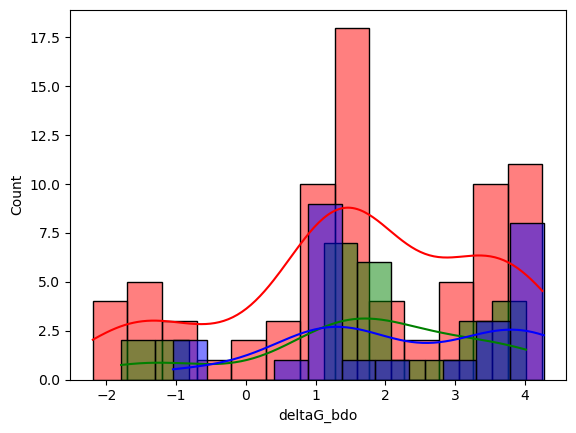

In [55]:
#x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=random_seed, ignore_val=True )
#df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
sns.histplot(y_train, kde=True, color='r',  binwidth=0.5)
sns.histplot(y_test, kde=True, color='g',  binwidth=0.5)
sns.histplot(y_val, kde=True, color='b',  binwidth=0.5)
plt.show()

#df_prop = standard_dataset(df_prop)

>1, train: 0.650, test: 0.700
>2, train: 0.814, test: 0.848
>3, train: 0.913, test: 0.903
>4, train: 0.956, test: 0.950
>5, train: 0.959, test: 0.937
>6, train: 0.965, test: 0.936
>7, train: 0.967, test: 0.931
>8, train: 0.964, test: 0.946
>9, train: 0.965, test: 0.916
>10, train: 0.965, test: 0.923
>11, train: 0.965, test: 0.927
>12, train: 0.969, test: 0.937
>13, train: 0.963, test: 0.929
>14, train: 0.960, test: 0.938
>15, train: 0.967, test: 0.942
>16, train: 0.959, test: 0.899
>17, train: 0.960, test: 0.913
>18, train: 0.964, test: 0.926
>19, train: 0.966, test: 0.922


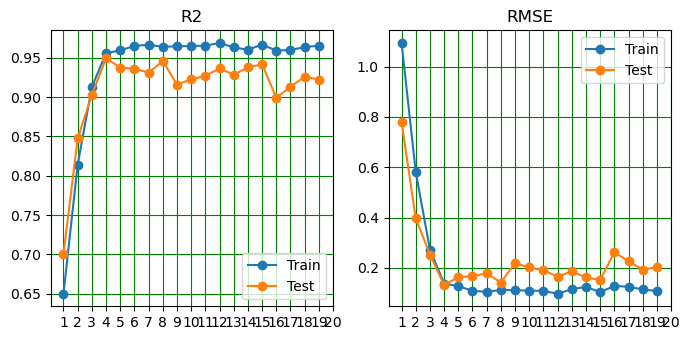

=============Done==============


In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

model_method = ExtraTreesRegressor

know_any_depth(df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
              model_method, name='Prop', max_layer=20)

================ Info =================
>>>>>> Train set (78, 58)
R square score:  0.9665632840293561
RMSE, MAE:  0.3234011901755425 0.17106172892109592
>>>>>> Test set (26, 58)
R square score:  0.9226489318857583
RMSE, MAE:  0.44863594791833467 0.3183519748566938


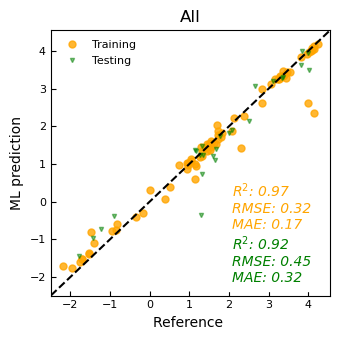

>>>>>> Val set (26,)
R square score:  0.689138099346638
RMSE, MAE: 0.8686299624166771 0.4398796095168777


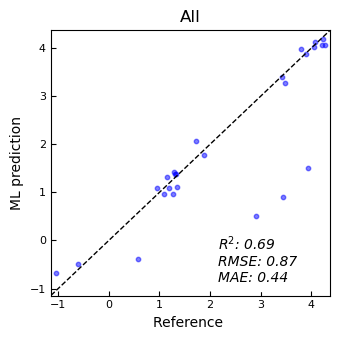

In [79]:
rf_nlayers = None
model_bdo = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
                          model_method, name='All', )
                          #ml_parameter={'max_depth':rf_nlayers})
score_val( df_prop['x_val'], df_prop['y_val'],  model_bdo, name='All',  data_color='b')

feature_bdo = list( df_prop['x_train'].columns )
scaler_bdo = df_prop['scaler']

name_header = 'manually'
file_model = f'model_bdo_{name_header}.pkl'
joblib.dump(model_bdo, file_model)

file_scaler = f'scaler_bdo_{name_header}.pkl'
joblib.dump(scaler_bdo, file_scaler)

file_feature=f'feature_bdo_{name_header}.json'
with open(file_feature, 'w') as f1:
    json.dump( feature_bdo, f1, indent=4) 

In [80]:
%%capture --no-display

# Hyper tuning
#from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'max_depth': np.arange(4, 25),
    'n_estimators': [25, 50, 100, 150, 200, 250, 300],
    'max_features': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'max_leaf_nodes': np.arange(5, 25),
}

#df_x = pd.concat( [df_prop['x_train'],df_prop['x_test']], axis=0 )
#df_y = pd.concat( [df_prop['y_train'],df_prop['y_test']], axis=0 )
random_search = RandomizedSearchCV(estimator=model_method(), param_distributions=param_dist, n_iter=200, cv=3, scoring='neg_mean_absolute_error', verbose=0)
random_search.fit( df_prop['x_train'], df_prop['y_train'] )
#random_search.fit( X_prop, Y_prop )
#random_search.fit( df_x, df_y )


display("Best hyperparameters:")
parameter = random_search.best_params_
for k,v in parameter.items():
    display(k,v)
display("Best accuracy:", random_search.best_score_, )

best_model = random_search.best_estimator_
test_accuracy = best_model.score( df_prop['x_test'], df_prop['y_test'] )
display("Test accuracy:", test_accuracy)
val_accuracy = best_model.score( df_prop['x_val'], df_prop['y_val'] )
display("Validation accuracy:", val_accuracy)

model_bdo = best_model

'Best hyperparameters:'

'n_estimators'

100

'max_leaf_nodes'

np.int64(23)

'max_features'

0.4

'max_depth'

np.int64(10)

'Best accuracy:'

np.float64(-0.5493300493157226)

'Test accuracy:'

0.9168542706721698

'Validation accuracy:'

0.7337418526700615

>>>>>> Val set (26,)
R square score:  0.7337418526700615
RMSE, MAE: 0.8039008903691061 0.447690858129853


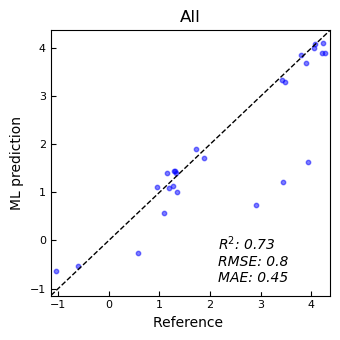

In [81]:
#model_bdo = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], #
#                          model_method, name='All', ml_parameter=parameter )
score_val( df_prop['x_val'], df_prop['y_val'],  model_bdo, name='All',  data_color='b')

feature_bdo = list( df_prop['x_train'].columns )

name_header = 'manually'
file_model = f'model_bdo_{name_header}.pkl'
joblib.dump(model_bdo, file_model)

file_scaler = f'scaler_bdo_{name_header}.pkl'
joblib.dump(df_prop['scaler'], file_scaler)

file_feature=f'feature_bdo_{name_header}.json'
with open(file_feature, 'w') as f1:
    json.dump( feature_bdo, f1, indent=4) 

## LGBM

In [106]:
%%capture --no-display
import lightgbm

# Hyper tuning
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 50),
    'max_depth': np.arange(4, 20),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 400],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}
random_search = RandomizedSearchCV(estimator=lightgbm.LGBMRegressor(), param_distributions=param_dist, n_iter=200, cv=3, scoring='neg_mean_absolute_error', verbose=0)
random_search.fit( df_prop['x_train'], df_prop['y_train'] )

display("Best hyperparameters:")
parameter = random_search.best_params_
for k,v in parameter.items():
    display(k,v)
display("Best accuracy:", random_search.best_score_, )

best_model = random_search.best_estimator_
test_accuracy = best_model.score( df_prop['x_test'], df_prop['y_test'] )
display("Test accuracy:", test_accuracy)
val_accuracy = best_model.score( df_prop['x_val'], df_prop['y_val'] )
display("Validation accuracy:", val_accuracy)

'Best hyperparameters:'

'subsample'

0.8

'num_leaves'

29

'n_estimators'

50

'max_depth'

10

'learning_rate'

0.2

'colsample_bytree'

0.7

'Best accuracy:'

-0.9352474039932069

'Test accuracy:'

0.684268680929874

'Validation accuracy:'

0.7367368137716279

================ Info =================
>>>>>> Train set (78, 55)
R square score:  0.9311060587444708
RMSE, MAE:  0.4294335906200617 0.3000296961066551
>>>>>> Test set (26, 55)
R square score:  0.684268680929874
RMSE, MAE:  0.9608344145418758 0.672926383807318


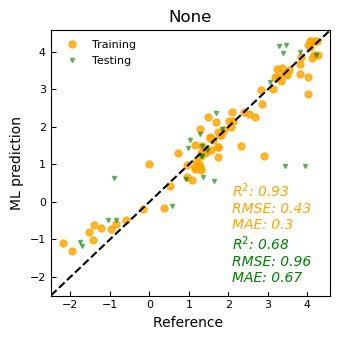

>>>>>> Val set (26,)
R square score:  0.7367368137716279
RMSE, MAE: 0.9812937540494607 0.6159653673836174


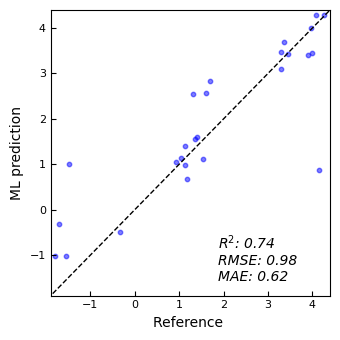

In [107]:
parameter['verbose']=-1
model_bdo = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
                          model_algorithm=lightgbm.LGBMRegressor, 
                          #name='', savefig='TrainTesting.png', axs_lim=[-5,2], 
                          ml_parameter=parameter) 

score_val( df_prop['x_val'], df_prop['y_val'],  model_bdo, name='', data_color='b')#savefig='Validating.png', axs_lim=[-5,2] )

feature_bdo = list( df_prop['x_train'].columns )

name_header = 'manually'
file_model = f'model_bdo_{name_header}.pkl'
joblib.dump(model_bdo, file_model)

file_scaler = f'scaler_bdo_{name_header}.pkl'
joblib.dump(df_prop['scaler'], file_scaler)

file_feature=f'feature_bdo_{name_header}.json'
with open(file_feature, 'w') as f1:
    json.dump( feature_bdo, f1, indent=4) 
    

## Final plot

In [249]:
model_bdo = joblib.load('model_bdo_manually.pkl')
scaler_bdo = joblib.load('scaler_bdo_manually.pkl')
with open('feature_bdo_manually.json', 'r') as f1:
    feature_bdo = json.load(f1)

0.5416067829559048


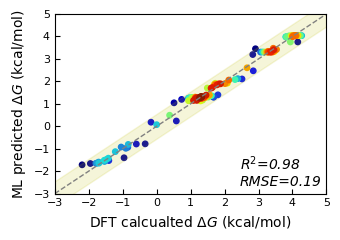

In [294]:
y_train_predict = model_bdo.predict(df_prop['x_train'].values)
y_test_predict = model_bdo.predict(df_prop['x_test'].values)
y_val_predict = model_bdo.predict(df_prop['x_val'].values)

train_score = model_bdo.score(df_prop['x_train'], df_prop['y_train'])
test_score = model_bdo.score(df_prop['x_test'], df_prop['y_test'])
val_score = model_bdo.score(df_prop['x_val'], df_prop['y_val'])

train_rmse = metrics.root_mean_squared_error(  df_prop['y_train'], y_train_predict, )#squared=False)
test_rmse = metrics.root_mean_squared_error(  df_prop['y_test'], y_test_predict, )#squared=False)
val_rmse = metrics.root_mean_squared_error(  df_prop['y_val'], y_val_predict, )#squared=False)
#train_mae = metrics.mean_absolute_error(  df_prop['y_train'], y_train_predict, )#squared=False)

r2 = [train_score, test_score, ]#val_score]
rmse = [train_rmse, test_rmse, ]#val_rmse]

dx = [df_prop['y_train'].values, df_prop['y_test'].values, ]#df_prop['y_val'].values]
dy = [y_train_predict, y_test_predict, ]#y_val_predict]
colors = ['k','g','b']

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)

axlim = np.array([100000,-1000000])
for x,y,c in zip(dx,dy,colors):
    #axs.scatter(x,y,  marker='o', c=c, s=15)  
    if np.amin([x,y])<axlim[0]:
        axlim[0] = np.amin([x,y])
    if np.amax([x,y])>axlim[1]:
        axlim[1] = np.amax([x,y])
axlim[0] -= 1
axlim[1] += 1
axs.plot(axlim,axlim, '--', color='gray', lw=1)

axs.set_xlim(axlim)
axs.set_ylim(axlim)

############
x = np.array([x for d in dx for x in d ])
y = np.array([y for d in dy for y in d ])
x,y,c = color_density(x,y)
axs.scatter(x,y,  marker='o', c=c, s=15, cmap='jet') 
print( np.amax( np.abs(x-y) ) )
###########

#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
axs.set_xlabel(r'DFT calcualted $\Delta G$ (kcal/mol)',fontsize=10) ## input X name
axs.set_ylabel(r'ML predicted $\Delta G$ (kcal/mol)',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

label = ['','Testing','Validation']
for n in range( 1 ):
    line = f'{label[n]} \nR$^2$={round(r2[n],2)} \nRMSE={round(rmse[n],2)}'
    axs.text(0.68,0.04+0.22*n, line, style='italic', fontsize=10, transform = axs.transAxes, color=colors[n])

x = np.arange(axlim[0], axlim[1], 0.01)
y1 = x+0.55
y2 = x-0.55
axs.fill_between(x, y1, y2, alpha=0.15, color='y')

plt.savefig('training.png', dpi=800)

plt.show()


np.float64(0.02844178074582726)

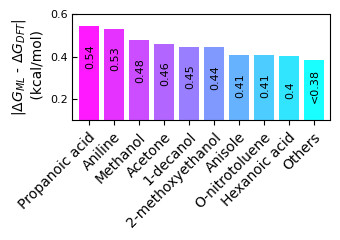

In [305]:
error_bar = pd.DataFrame()

df_sr = y_train_predict - df_prop['y_train']
#display( 'Training', df_sr.abs().sort_values(ascending=False).head(10) )
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
if '1-BUTANOL' in df_sr.index:
    print( '1-BUTANOL=',df_sr.loc['1-BUTANOL'] )

df_sr = y_test_predict - df_prop['y_test']
#display( 'Testing', df_sr.abs().sort_values(ascending=False).head(10) )
error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )
if '1-BUTANOL' in df_sr.index:
    display( df_sr.loc['1-BUTANOL'] )

df_sr = y_val_predict - df_prop['y_val']
#display( df_sr.abs().sort_values(ascending=False).head(10) )
#df_sr['type']='Valid'
#error_bar = pd.concat( [error_bar,df_sr.to_frame()], axis=0 )

error_bar = error_bar.abs().sort_values(by='deltaG_bdo', ascending=False)

df_plot = error_bar.head(10)
labels = list( df_plot.index.str.capitalize() )
labels[-1] = 'Others'

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(1, 0, 10))

bars = df_plot.plot(kind='bar', stacked=False, y=['deltaG_bdo'], ax=axs, #xlabel=labels, #color=colors,
             width=0.8, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for n,rect in enumerate(axs.patches):
    x = rect.get_x()
    y = rect.get_height()
    rect.set_fc( colors[n] )
    if n==len(axs.patches)-1:
        axs.text(x+0.25,y-0.2,'<'+str(round(y,2)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    else:
        axs.text(x+0.25,y-0.2,str(round(y,2)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    
axs.set_xlabel(None,fontsize=10) ## input X name
axs.set_ylabel(r'|$\Delta G$$_{ML}$ - $\Delta G$$_{DFT}$|'+'\n (kcal/mol)' ,fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8, axis='y')
axs.set_xticklabels( labels, rotation=45, fontsize=10, ha='right', rotation_mode='anchor')
axs.set_ylim([0.1,0.6])
#axs.set_xticks( [] )
axs.legend().set_visible(False) #labels=['Aliphatic']+ring_names, fontsize=8, frameon=False, ncol=2, handlelength=1, handletextpad=0.2, columnspacing=1)
#plt.yscale('log')

plt.savefig("ErrorBar.png", dpi=800)  
plt.show()


In [ ]:
%%capture --no-display


exp_data = pd.read_csv('df_performance.csv', index_col=0)
mask = exp_data['type']=='r'

sim = predict_rdkfp( list(exp_data['SMILES']), feature_bdo, model_bdo, scaler=scaler_bdo)
sim = -sim/(2.303*1.987*0.001*(273.15+25)) 
sim = np.power( 10, sim ) 

#a,b = np.polyfit( sim, exp_data['Kd 20C'], 1)
a,b = np.polyfit( sim[mask], exp_data['Kd 20C'][mask], 1)
sim = a*sim + b
exp_data['ML'] = sim

fig, axs = plt.subplots(1,1,figsize=(4,3),tight_layout=True,dpi=100)
for s,e,c,b in zip( exp_data['ML'], exp_data['Kd 20C'],exp_data['type'], exp_data['Solvent'] ):
    #e = np.log10(e)
    axs.plot( s, e, color=c, label=b, lw=2, ls='', marker='v', ms=6) 

axs.plot( [0,0.9], [0,0.9], ls=':',marker='',lw=1,color='gray')

plt.show()

corr, _ = pearsonr( exp_data['ML'], exp_data['Kd 20C'] )
r2 = metrics.r2_score(  exp_data['ML'], exp_data['Kd 20C'] ) 
rmse = metrics.mean_squared_error(  exp_data['ML'], exp_data['Kd 20C'], squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)

exp_data.to_csv('df_performance.csv')
display( exp_data )

In [ ]:
# If save data set split
df_prop['x_train'].to_csv('df_x_train_bdo.csv')
df_prop['y_train'].to_csv('df_y_train_bdo.csv')
df_prop['x_test'].to_csv('df_x_test_bdo.csv')
df_prop['y_test'].to_csv('df_y_test_bdo.csv')
df_prop['x_val'].to_csv('df_x_val_bdo.csv')
df_prop['y_val'].to_csv('df_y_val_bdo.csv')

In [ ]:
#%%capture --no-display

## Hyperparameters for ExtraTrees
para_range = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider at every split
    'max_depth': [None] + list(np.arange(5, 20)),  # Maximum depth of the tree
    'min_samples_split': [2,5,10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1,2,3,4],  # Minimum number of samples required to be at a leaf node
    }

scaler_bdo, feature_bdo, model_bdo = hyperparameter_tuning(X_prop, Y_prop, model_method, para_range,
                                                     if_std=True, name_header='bdo', rand_state=random_seed)

# For Water data

In [42]:
X_prop = df_features_prop.copy()
Y_prop = solvation_data['deltaG_wat']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_prop = X_prop.select_dtypes(include=numerics)
X_prop = clean_std(X_prop)
X_prop,_ = remove_high_corr_gradually(X_prop, cutoff=0.7)
#mask_zscore = np.abs( stats.zscore(X_features_prop_clean) )
#X_features_prop_clean = X_features_prop_clean[ (mask_zscore<10).all(axis=1) ]

Before clean (130, 124)
After clean (130, 116)
Num of keep:  55
Num of drop:  61
---------


In [43]:
# Remove COS outliners?
from numpy.linalg import norm

ref = X_prop.loc['1-BUTANOL'].values
sel = X_prop.values

cosine = np.dot(sel,ref)/(norm(sel,axis=1)*norm(ref))
X_prop['COS'] = cosine

X_prop = X_prop[ X_prop['COS']>0. ] 
Y_prop = Y_prop.loc[X_prop.index]
display( X_prop.sort_values(by='COS', ascending=False)['COS'] )

X_prop = X_prop.drop(['COS'],axis=1)

Solvent Name
1-BUTANOL             1.00
1-PENTANOL            0.99
1-HEXANOL             0.94
1-HEPTANOL            0.92
HEXANOIC ACID         0.92
                      ... 
METHANOL              0.23
DIPHENYLETHER         0.22
2-PROPANOL            0.14
2-METHYL-2-PROPANOL   0.13
BENZENE               0.09
Name: COS, Length: 129, dtype: float64

In [45]:
for i,r in enumerate(my_REGRESSORS):
    print(i, r[0])
used_regressor = [3,7,8,10,11,12,14,23,24,31,35,38,39]
used_regressor = [ my_REGRESSORS[n] for n in used_regressor ]

used_regressor

0 AdaBoostRegressor
1 BaggingRegressor
2 BayesianRidge
3 DecisionTreeRegressor
4 DummyRegressor
5 ElasticNet
6 ElasticNetCV
7 ExtraTreeRegressor
8 ExtraTreesRegressor
9 GammaRegressor
10 GaussianProcessRegressor
11 GradientBoostingRegressor
12 HistGradientBoostingRegressor
13 HuberRegressor
14 KNeighborsRegressor
15 KernelRidge
16 Lars
17 LarsCV
18 Lasso
19 LassoCV
20 LassoLars
21 LassoLarsCV
22 LassoLarsIC
23 LinearRegression
24 LinearSVR
25 MLPRegressor
26 NuSVR
27 OrthogonalMatchingPursuit
28 OrthogonalMatchingPursuitCV
29 PassiveAggressiveRegressor
30 RANSACRegressor
31 RandomForestRegressor
32 Ridge
33 RidgeCV
34 SGDRegressor
35 SVR
36 TransformedTargetRegressor
37 TweedieRegressor
38 XGBRegressor
39 LGBMRegressor


[('DecisionTreeRegressor', sklearn.tree._classes.DecisionTreeRegressor),
 ('ExtraTreeRegressor', sklearn.tree._classes.ExtraTreeRegressor),
 ('ExtraTreesRegressor', sklearn.ensemble._forest.ExtraTreesRegressor),
 ('GaussianProcessRegressor',
  sklearn.gaussian_process._gpr.GaussianProcessRegressor),
 ('GradientBoostingRegressor', sklearn.ensemble._gb.GradientBoostingRegressor),
 ('HistGradientBoostingRegressor',
  sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor),
 ('KNeighborsRegressor', sklearn.neighbors._regression.KNeighborsRegressor),
 ('LinearRegression', sklearn.linear_model._base.LinearRegression),
 ('LinearSVR', sklearn.svm._classes.LinearSVR),
 ('RandomForestRegressor', sklearn.ensemble._forest.RandomForestRegressor),
 ('SVR', sklearn.svm._classes.SVR),
 ('XGBRegressor', xgboost.sklearn.XGBRegressor),
 ('LGBMRegressor', lightgbm.sklearn.LGBMRegressor)]

1

2

3

4

5

6

7

8

9

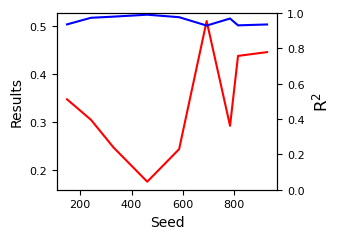

,R-Squared,RMSE,Seed
Model,,,
ExtraTreesRegressor,0.99,0.18,461
ExtraTreesRegressor,0.98,0.24,585
ExtraTreesRegressor,0.98,0.25,330
ExtraTreesRegressor,0.97,0.29,783
ExtraTreeRegressor,0.97,0.31,242
ExtraTreesRegressor,0.94,0.35,149
ExtraTreesRegressor,0.93,0.44,814
ExtraTreesRegressor,0.94,0.45,927
ExtraTreesRegressor,0.93,0.51,692


In [47]:
%%capture --no-display

# Try a seed screen? it takes 30 min to 1 hr

def optimize_ML_performance(X_prop, Y_prop, rand_state=10, if_std=False, if_switch_test_valid=False, ignore_val=False):
    x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=rand_state, ignore_val=ignore_val)
    
    df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
    if if_switch_test_valid:
        df_prop = {'x_train':x_train, 'x_test':x_val, 'x_val':x_test, 'y_train':y_train, 'y_test':y_val, 'y_val':y_test}
    if if_std:
        df_prop = standard_dataset(df_prop)
        scaler = df_prop['scaler']
    else:
        scaler = None
        
    model_ml, lazy_ml = do_lazy_regression(df_prop, rg=used_regressor)
    rmse = model_ml[ model_ml['RMSE']<5 ].sort_values(by='RMSE',ascending=True)
    result = rmse.head(1)
    result['Seed'] = rand_state
    return result[ ['R-Squared','RMSE','Seed'] ]


performance2 = pd.DataFrame()
for rd in range(1,10):
    if rd%1==0:
        display(rd)
    rand_num = np.random.randint(100, size=1) # random int from 0 to 99
    rd = rd*100 + np.array( list(set(rand_num)) )
    for r in rd:
        r = optimize_ML_performance(X_prop, Y_prop, rand_state=r, if_std=True, if_switch_test_valid=False, ignore_val=True)
        performance2 = pd.concat( [performance2, r], axis=0 )
    
fig, axs = plt.subplots(1,1,  figsize=(3.5,2.5),tight_layout=True)
performance2.plot(kind='line', x='Seed', y='RMSE', color=['red'], ax=axs, legend=False, fontsize=8)  ##figsize=(12,3)
axs.set_ylabel('Results', fontsize=10)
axs.set_xlabel('Seed', fontsize=10)
#axs.set_xticklabels( [n for n in range(len(rmse))], rotation=0, ha='center')
axt = axs.twinx()
#axt.set_xticks( [] )
axt.set_ylabel('R$^2$', fontsize=12)
performance2.plot(kind='line', x='Seed', y='R-Squared', color=['blue'], ax=axt, legend=False, fontsize=8)#, xlabel=None)
axt.set_ylim((0,1))
#plt.savefig("ml_modeling_selection.png", dpi=800)  
plt.show()

display( performance2.sort_values(by='RMSE', ascending=True) )

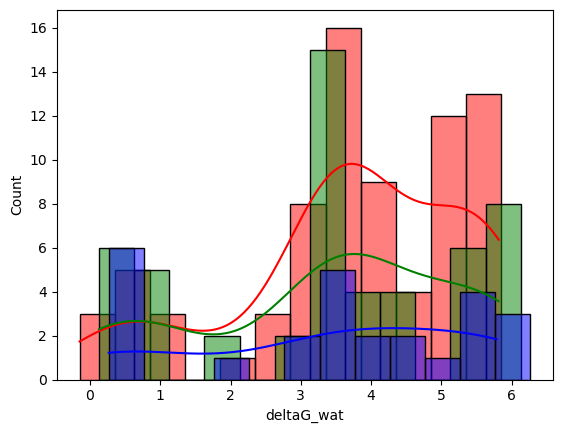

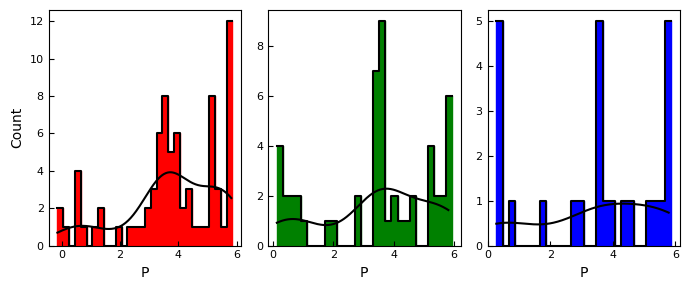

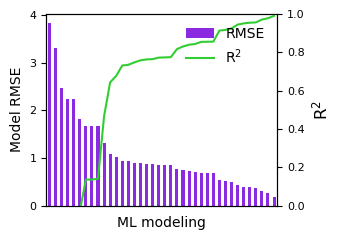

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
KernelRidge,58.73,-3.53,3.83,0.01
GaussianProcessRegressor,43.88,-2.36,3.30,0.02
RANSACRegressor,24.84,-0.87,2.46,0.15
TransformedTargetRegressor,20.72,-0.55,2.24,0.02
LinearRegression,20.72,-0.55,2.24,0.01
DummyRegressor,14.13,-0.03,1.83,0.01
LassoLars,12.02,0.14,1.67,0.01
Lasso,12.02,0.14,1.67,0.01
LassoLarsIC,11.97,0.14,1.67,0.05


In [48]:
%%capture --no-display

random_seed = 461
screen_ML_performance(X_prop, Y_prop, rand_state=random_seed, if_std=True, if_switch_test_valid=False, ignore_val=True )

Train, Test, Val sizes are:  (77, 55) (52, 55) (26, 55)


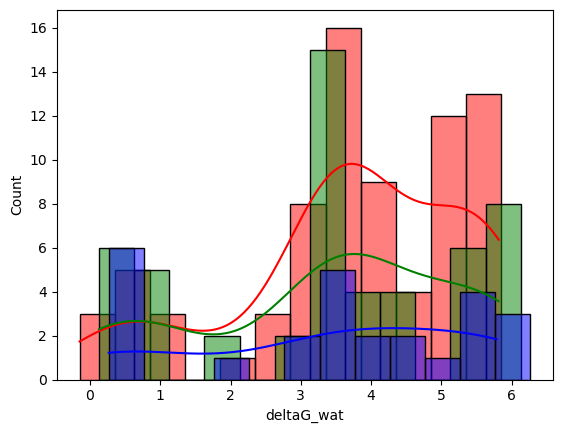

>1, train: 0.526, test: 0.620
>2, train: 0.840, test: 0.870
>3, train: 0.933, test: 0.954
>4, train: 0.974, test: 0.978
>5, train: 0.990, test: 0.986
>6, train: 0.997, test: 0.987
>7, train: 0.999, test: 0.988
>8, train: 1.000, test: 0.990
>9, train: 1.000, test: 0.991
>10, train: 1.000, test: 0.990
>11, train: 1.000, test: 0.990
>12, train: 1.000, test: 0.988
>13, train: 1.000, test: 0.989
>14, train: 1.000, test: 0.990
>15, train: 1.000, test: 0.988
>16, train: 1.000, test: 0.989
>17, train: 1.000, test: 0.989
>18, train: 1.000, test: 0.991
>19, train: 1.000, test: 0.989


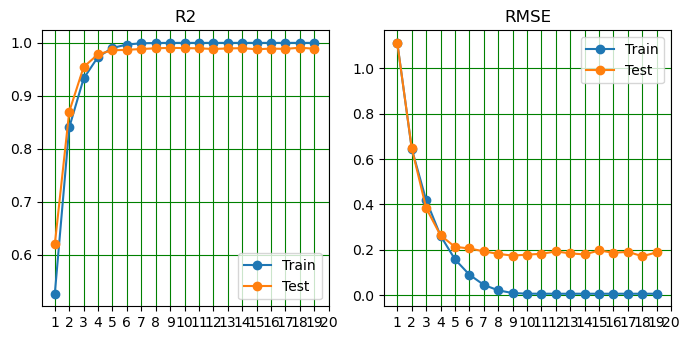

=============Done==============


In [49]:
x_train, x_test, x_val, y_train, y_test, y_val = split_data(X_prop, Y_prop, rand_state=random_seed, ignore_val=True)
df_prop = {'x_train':x_train, 'x_test':x_test, 'x_val':x_val, 'y_train':y_train, 'y_test':y_test, 'y_val':y_val}
sns.histplot(y_train, kde=True, color='r',  binwidth=0.5)
sns.histplot(y_test, kde=True, color='g',  binwidth=0.5)
sns.histplot(y_val, kde=True, color='b',  binwidth=0.5)
plt.show()

df_prop = standard_dataset(df_prop)

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

model_method = ExtraTreesRegressor

know_any_depth(df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
              model_method, name='Prop', max_layer=20)

================ Info =================
>>>>>> Train set (77, 55)
R square score:  0.9998049059557551
RMSE, MAE:  0.022549584596550914 0.01098498932866232
>>>>>> Test set (52, 55)
R square score:  0.9882966103991221
RMSE, MAE:  0.1946080821044063 0.12824999491568828


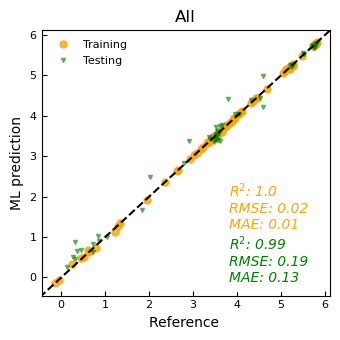

>>>>>> Val set (26,)
R square score:  0.986344397015021
RMSE, MAE: 0.2280271626133216 0.14931945517089182


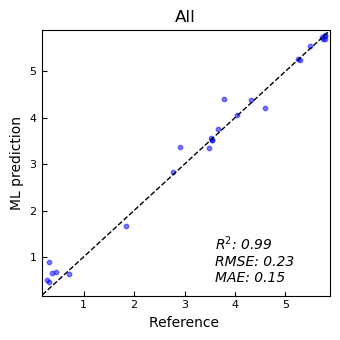

In [50]:
rf_nlayers = 8
model_wat = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
                          model_method, name='All', ml_parameter={'max_depth':rf_nlayers})
score_val( df_prop['x_val'], df_prop['y_val'],  model_wat, name='All',  data_color='b')

feature_wat = list( df_prop['x_train'].columns )

name_header = 'manually'
file_model = f'model_wat_{name_header}.pkl'
joblib.dump(model_wat, file_model)

file_scaler = f'scaler_wat_{name_header}.pkl'
joblib.dump(df_prop['scaler'], file_scaler)

file_feature=f'feature_wat_{name_header}.json'
with open(file_feature, 'w') as f1:
    json.dump( feature_wat, f1, indent=4) 

In [54]:
%%capture --no-display
#from sklearn.ensemble import ExtraTreesRegressor

# Hyper tuning
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'max_depth': np.arange(4, 25),
    'n_estimators': [20, 50, 100, 150, 200, 250, 300],
    'max_features': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'max_leaf_nodes': np.arange(5, 25), 
}

random_search = RandomizedSearchCV(estimator=model_method(), param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_absolute_error', verbose=0)
random_search.fit( df_prop['x_train'], df_prop['y_train'] )

display("Best hyperparameters:")
parameter = random_search.best_params_
for k,v in parameter.items():
    display(k,v)
display("Best accuracy:", random_search.best_score_, )

best_model = random_search.best_estimator_
test_accuracy = best_model.score( df_prop['x_test'], df_prop['y_test'] )
display("Test accuracy:", test_accuracy)
val_accuracy = best_model.score( df_prop['x_val'], df_prop['y_val'] )
display("Validation accuracy:", val_accuracy)

'Best hyperparameters:'

'n_estimators'

200

'max_leaf_nodes'

24

'max_features'

0.4

'max_depth'

22

'Best accuracy:'

-0.2766060819216743

'Test accuracy:'

0.9892674470624888

'Validation accuracy:'

0.9867331484860213

================ Info =================
>>>>>> Train set (77, 55)
R square score:  0.9979349850652361
RMSE, MAE:  0.07336317839085456 0.05569610086181176
>>>>>> Test set (52, 55)
R square score:  0.9884760100784737
RMSE, MAE:  0.19311076137771938 0.1293384751846664


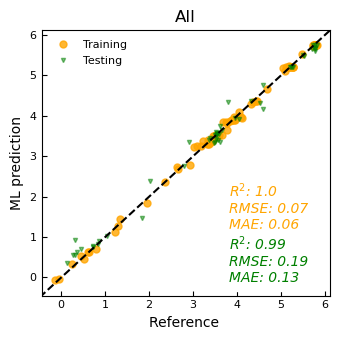

>>>>>> Val set (26,)
R square score:  0.9846543821736405
RMSE, MAE: 0.24172598100262893 0.16588288280476934


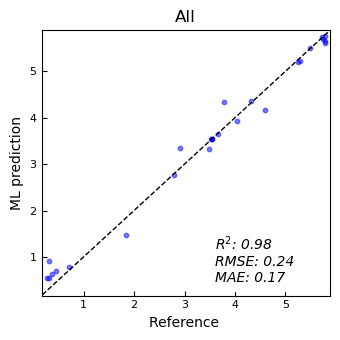

In [55]:
model_wat = model_any_fit( df_prop['x_train'], df_prop['y_train'], df_prop['x_test'], df_prop['y_test'], 
                          model_method, name='All', ml_parameter=parameter )
score_val( df_prop['x_val'], df_prop['y_val'],  model_wat, name='All',  data_color='b')

feature_wat = list( df_prop['x_train'].columns )

name_header = 'manually'
file_model = f'model_wat_{name_header}.pkl'
joblib.dump(model_wat, file_model)

file_scaler = f'scaler_wat_{name_header}.pkl'
joblib.dump(df_prop['scaler'], file_scaler)

file_feature=f'feature_wat_{name_header}.json'
with open(file_feature, 'w') as f1:
    json.dump( feature_wat, f1, indent=4) 

0.9979349850652361 0.9884760100784737 0.9846543821736405


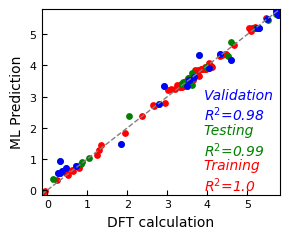

In [56]:
train_score = model_wat.score(df_prop['x_train'], df_prop['y_train'])
test_score = model_wat.score(df_prop['x_test'], df_prop['y_test'])
val_score = model_wat.score(df_prop['x_val'], df_prop['y_val'])

print(train_score, test_score, val_score)

y_train_predict = model_wat.predict(df_prop['x_train'].values)
y_test_predict = model_wat.predict(df_prop['x_test'].values)
y_val_predict = model_wat.predict(df_prop['x_val'].values)

dx = [df_prop['y_train'].values, df_prop['y_test'].values, df_prop['y_val'].values]
dy = [y_train_predict, y_test_predict, y_val_predict]
colors = ['r','g','b']

fig, axs = plt.subplots(1,1,figsize=(3,2.5),tight_layout=True,dpi=100)

axlim = [100000,-1000000]
for x,y,c in zip(dx,dy,colors):
    axs.scatter(x,y,  marker='o', c=c, s=15)  
    if np.amin([x,y])<axlim[0]:
        axlim[0] = np.amin([x,y])
    if np.amax([x,y])>axlim[1]:
        axlim[1] = np.amax([x,y])
axs.plot(axlim,axlim, '--', color='gray', lw=1)

axs.set_xlim(axlim)
axs.set_ylim(axlim)

#a, b = np.polyfit(our_exp_logs,[-2.68,-2.915,-3.075,-3.598], 1)
#axs.plot(df_plot['logS'], a*np.array(df_plot['logS'])+b, color='r', linestyle='--') 
axs.set_xlabel('DFT calculation',fontsize=10) ## input X name
axs.set_ylabel('ML Prediction',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

label = ['Training','Testing','Validation']
for n,s in enumerate([train_score, test_score, val_score]):
    axs.text(0.68,0.02+0.19*n, f'{label[n]} \nR$^2$={round(s,2)}', style='italic', fontsize=10, transform = axs.transAxes, color=colors[n])

plt.savefig('training.png', dpi=800)

plt.show()


In [ ]:
# If save data set split
df_prop['x_train'].to_csv('df_x_train_wat.csv')
df_prop['y_train'].to_csv('df_y_train_wat.csv')
df_prop['x_test'].to_csv('df_x_test_wat.csv')
df_prop['y_test'].to_csv('df_y_test_wat.csv')
df_prop['x_val'].to_csv('df_x_val_wat.csv')
df_prop['y_val'].to_csv('df_y_val_wat.csv')

# Screening new

In [17]:
## Make prdiction on one new data point
from rdkit.ML.Descriptors import MoleculeDescriptors

def predict_rdkfp(smi, fp_name, model, scaler=None, fp_calc=None):
    """
    smi = a list of SMILES
    """
    if fp_calc==None:
        fp_calc = MoleculeDescriptors.MolecularDescriptorCalculator(fp_name)
    fps = [list( fp_calc.CalcDescriptors( Chem.MolFromSmiles(s) ) ) for s in smi]
    new_df = pd.DataFrame( data=fps, columns=fp_name )
    if scaler is not None:
        new_df = scaler.transform(new_df)
    try:
        predict_new = model.predict(new_df)
    except:
        print('Prediction issue for', smi, new_df)
        predict_new = None
    
    return predict_new

In [ ]:
## The MORGAN fp
def predict_rdkfp(smi, fp_name, model, scaler=None):
    rr = 3 # 3 for ML, 2 for similarity usually
    nbits = 1024 # 1024 or 2048
    col = [f'bit_{n}' for n in range(nbits)]
    
    fps = [AllChem.GetMorganFingerprintAsBitVect( Chem.MolFromSmiles(s), radius=rr, nBits=nbits) for s in smi]
    #fp = [np.array( list(fp) , dtype=int)]
    fps = [ list(f) for f in fps]
    
    new_df = pd.DataFrame( data=fps, columns=col )
    new_df = new_df[fp_name]
    
    if scaler is not None:
        new_df = scaler.transform(new_df)
    predict_new = model.predict(new_df)
    
    return predict_new

In [18]:
model_bdo = joblib.load('model_bdo_manually.pkl')
scaler_bdo = joblib.load('scaler_bdo_manually.pkl')
with open('feature_bdo_manually.json', 'r') as f1:
    feature_bdo = json.load(f1)

In [19]:
model_wat = joblib.load('model_wat_manually.pkl')
scaler_wat = joblib.load('scaler_wat_manually.pkl')
with open('feature_wat_manually.json', 'r') as f1:
    feature_wat = json.load(f1)

## Get predicted data in exp data

In [106]:
display( not_included_data, included_data )

,Class,Solvent,MW (g/mol),Kd 20C,Kd 40C,Kd 60C,SMILES,inchi,dG_ML_bdo,dG_ML_wat
2,Alcohol,2-Hexanol,102.17,0.35,0.41,0.47,CCCCC(C)O,"InChI=1S/C6H14O/c1-3-4-5-6(2)7/h6-7H,3-5H2,1-2H3",-1.22,None
3,Alcohol,4-Methyl-2-pentanol,102.17,0.30,0.41,0.44,CC(C)CC(C)O,"InChI=1S/C6H14O/c1-5(2)4-6(3)7/h5-7H,4H2,1-3H3",-1.08,None
7,Alcohol,"3,7-Dimethyl-1-octanol",158.28,0.11,0.17,0.20,CC(C)CCCC(C)CCO,InChI=1S/C10H22O/c1-9(2)5-4-6-10(3)7-8-11/h9-1...,-0.75,None
8,Alcohol,Oleyl alcohol,268.50,0.07,0.07,0.11,CCCCCCCC/C=C\CCCCCCCCO,InChI=1S/C18H36O/c1-2-3-4-5-6-7-8-9-10-11-12-1...,-0.75,None
10,Ester,Isopropyl acetate,102.13,0.10,0.11,0.13,CC(C)COC(=O)C,"InChI=1S/C6H12O2/c1-5(2)4-8-6(3)7/h5H,4H2,1-3H3",1.88,None
11,Ester,sec-Butyl acetate,116.16,0.04,0.08,0.17,CCC(C)OC(=O)C,"InChI=1S/C6H12O2/c1-4-5(2)8-6(3)7/h5H,4H2,1-3H3",1.92,None
12,Ester,Isobutyl acetate,116.16,0.05,0.07,0.07,CC(C)OC(=O)C,"InChI=1S/C5H10O2/c1-4(2)7-5(3)6/h4H,1-3H3",1.90,None
14,Ester,Butyl butyrate,144.21,0.03,0.04,0.04,CCCCOC(=O)CCC,"InChI=1S/C8H16O2/c1-3-5-7-10-8(9)6-4-2/h3-7H2,...",2.05,None
15,Ester,n-Hexyl acetate,144.21,0.03,0.04,0.05,CCCCCCOC(=O)C,"InChI=1S/C8H16O2/c1-3-4-5-6-7-10-8(2)9/h3-7H2,...",2.09,None
16,Ester,Dibutyl oxalate,202.25,0.01,0.02,0.04,CCCCOC(=O)C(=O)OCCCC,InChI=1S/C10H18O4/c1-3-5-7-13-9(11)10(12)14-8-...,2.97,None


,Class,Solvent,MW (g/mol),Kd 20C,Kd 40C,Kd 60C,SMILES,inchi,dG_DFT_bdo,dG_DFT_wat,dG_ML_bdo,dG_ML_wat
0,Alcohol,1-Butanol,74.12,0.92,1.03,1.13,CCCCO,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3",-1.54,0.37,-1.52,None
1,Alcohol,1-Hexanol,102.17,0.37,0.47,0.48,CCCCCCO,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3",-1.22,0.61,-1.13,None
4,Alcohol,1-Heptanol,116.20,0.22,0.29,0.34,CCCCCCCO,"InChI=1S/C7H16O/c1-2-3-4-5-6-7-8/h8H,2-7H2,1H3",-1.05,0.72,-0.93,None
5,Alcohol,1-Octanol,130.23,0.22,0.27,0.30,CCCCCCCCO,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",-0.84,0.87,-0.81,None
6,Alcohol,1-Nonanol,144.25,0.14,0.20,0.20,CCCCCCCCCO,"InChI=1S/C9H20O/c1-2-3-4-5-6-7-8-9-10/h10H,2-9...",-0.60,1.04,-0.79,None
9,Ester,Ethyl acetate,88.11,0.19,0.20,0.22,CCOC(=O)C,"InChI=1S/C4H8O2/c1-3-6-4(2)5/h3H2,1-2H3",1.72,3.88,1.86,None
13,Ester,n-Pentyl acetate,130.18,0.04,0.06,0.06,CCCCCOC(=O)C,"InChI=1S/C7H14O2/c1-3-4-5-6-9-7(2)8/h3-6H2,1-2H3",2.07,4.09,1.93,None
19,Hydrocarbon,Toluene,92.14,0.01,0.02,0.02,CC1=CC=CC=C1,"InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3",3.12,5.17,3.31,None
20,Hydrocarbon,Methylcycohexane,98.19,0.01,0.01,0.05,CC1CCCCC1,"InChI=1S/C7H14/c1-7-5-3-2-4-6-7/h7H,2-6H2,1H3",3.99,5.73,4.03,None
22,Hydrocarbon,Dodecane,170.33,0.03,0.09,0.05,CCCCCCCCCCCC,InChI=1S/C12H26/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,4.16,5.80,4.04,None


In [107]:
%%capture --no-display

x1 = included_data['SMILES']
x2 = not_included_data['SMILES'] 
    
sim = predict_rdkfp( list(x1), feature_bdo, model_bdo, scaler=scaler_bdo)
included_data['dG_ML_bdo'] = sim
sim = predict_rdkfp( list(x1), feature_wat, model_wat, scaler=scaler_wat)
included_data['dG_ML_wat'] = sim

sim = predict_rdkfp( list(x2), feature_bdo, model_bdo, scaler=scaler_bdo)
not_included_data['dG_ML_bdo'] = sim
sim = predict_rdkfp( list(x2), feature_wat, model_wat, scaler=scaler_wat)
not_included_data['dG_ML_wat'] = sim
    
#display( not_included_data, included_data )

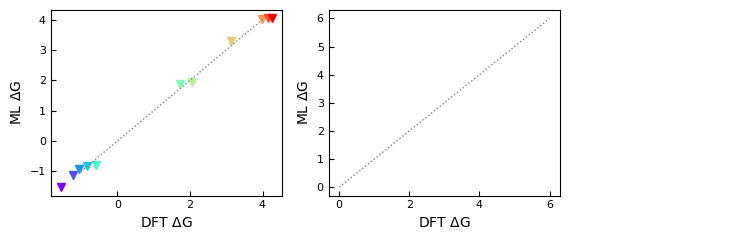

In [108]:
# DFT vs ML in exp data
colors = [ plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

fig, axs = plt.subplots(1,2,figsize=(8,2.5),tight_layout=True,dpi=100)

for n,(x1,y1,x2,y2,b) in enumerate(zip(included_data['dG_DFT_bdo'],included_data['dG_ML_bdo'],
                                       included_data['dG_DFT_wat'],included_data['dG_ML_wat'], 
                                       included_data['Solvent'])):
    axs[0].plot(x1, y1, color=colors[n], label=b, lw=2, ls='', marker='v', ms=6) 
    #axs[1].plot(x2, y2, color=colors[n], label=b, lw=2, ls='', marker='v', ms=6) 

for n in [0,1]:
    axs[n].set_ylabel(r'ML $\Delta$G',fontsize=10) ## input X name
    axs[n].set_xlabel(r'DFT $\Delta$G',fontsize=10) ## input Y name
    axs[n].tick_params(direction='in',labelsize='8')
    
axs[0].plot( [-1,4], [-1,4], ls=':',marker='',lw=1,color='gray')
axs[1].plot( [0,6], [0,6], ls=':',marker='',lw=1,color='gray')

axs[1].legend(fontsize=8, frameon=False, loc='center right', ncol=1, columnspacing=1, bbox_to_anchor=(1.8, 0.5) )

plt.show()

0.05678550187310659 0.021490456657210662
Pearsons correlation: 0.946
R2: 0.883
RMSE: 0.082


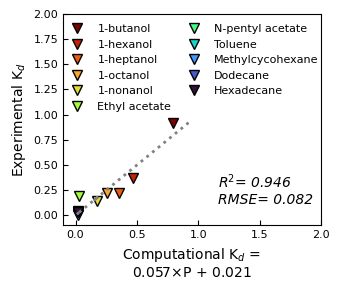

In [109]:
temp_K = 273.15+25

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

colors = [plt.cm.turbo(n) for n in np.linspace(1,0,len(included_data)) ] 


final_x, final_y, final_errbar, final_label = [],[], [],[]
for n in range( len(included_data) ):
    exp_sr = included_data.iloc[n]
    exp = exp_sr['Kd 20C']
    label = exp_sr['Solvent']
    
    sim = exp_sr['dG_DFT_bdo']  ## This is the same as DFT at the beginning
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim = np.power( 10, sim)  #sim = np.exp(sim)
    
    #display( exp_sr, sim )
    #axs.plot((sim,sim), (exp,exp), color=colors[n], label=label.capitalize(), lw=2, ls='', marker='v', ms=5)
    
    #print(sim, exp)
    final_x.append( sim )
    final_y.append( exp )
    final_errbar.append( [0,0] )
    final_label.append( label.capitalize() )
    
final_x = np.array(final_x).flatten()

fit_a,fit_b = np.polyfit(final_x,final_y,1)
fit_x = final_x*fitted_a+fitted_b
print(fit_a,fit_b)
#axs.set_yscale('log')

from scipy.stats import pearsonr
corr, _ = pearsonr( fit_x,final_y )
r2 = metrics.r2_score( fit_x, final_y ) 
rmse = metrics.root_mean_squared_error( fit_x, final_y, )#squared=False)
print('Pearsons correlation: %.3f' % corr)
print('R2: %.3f' % r2)
print('RMSE: %.3f' % rmse)


fitted_a, fitted_b = np.round( [fit_a, fit_b], 3 )
fitted_text_line = fr'{fitted_a}$\times$P + {fitted_b}'
axs.set_xlabel('Computational K$_d$ = \n'+fitted_text_line,fontsize=10) ## input Y name

line = f'R$^2$= {round(corr,3)} \nRMSE= {round(rmse,3)} '
axs.text(0.6, 0.1, line, style='italic', fontsize=10, transform = axs.transAxes, color='k')

for n in range( len(final_y) ):
    axs.plot(fit_x[n], final_y[n], color=colors[n], markeredgecolor='k', label=final_label[n], lw=2, ls='', marker='v', ms=7)

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
#axs.set_xlabel('Computational P',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
axs.set_xlim([-0.1, 2])
axs.set_ylim([-0.1, 2])
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
axs.legend(fontsize=8, frameon=False, loc='upper center', ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1) )

#axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')
axs.plot(final_y,final_y,ls=':',marker='',lw=2,color='gray')

plt.savefig('Compare_ML_fit.png', dpi=800)
plt.show()

0.061401676537250545 0.01776563317459302
Pearsons correlation: 0.951
R2: 0.868
RMSE: 0.007


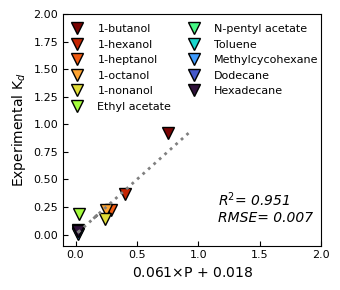

In [238]:
temp_K = 273.15+25

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

colors = [plt.cm.turbo(n) for n in np.linspace(1,0,len(included_data)) ] 


final_x, final_y, final_errbar, final_label = [],[], [],[]
for n in range( len(included_data) ):
    exp_sr = included_data.iloc[n]
    exp = exp_sr['Kd 20C']
    label = exp_sr['Solvent']
    
    #sim = exp_sr['dG_DFT_bdo']  ## This is the same as DFT at the beginning
    sim = exp_sr['dG_ML_bdo']  ## 
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim = np.power( 10, sim)  #sim = np.exp(sim)
    
    #display( exp_sr, sim )
    #axs.plot((sim,sim), (exp,exp), color=colors[n], label=label.capitalize(), lw=2, ls='', marker='v', ms=5)
    
    #print(sim, exp)
    final_x.append( sim )
    final_y.append( exp )
    final_errbar.append( [0,0] )
    final_label.append( label.capitalize() )
    
final_x = np.array(final_x).flatten()

fit_a,fit_b = np.polyfit(final_x,final_y,1)
fit_x = final_x*fitted_a+fitted_b
print(fit_a,fit_b)
#axs.set_yscale('log')

from scipy.stats import pearsonr
corr, _ = pearsonr( fit_x,final_y )
r2 = metrics.r2_score( fit_x, final_y ) 
rmse = metrics.mean_squared_error( fit_x, final_y, )#squared=False)
print('Pearsons correlation: %.3f' % corr)
print('R2: %.3f' % r2)
print('RMSE: %.3f' % rmse)


fitted_a, fitted_b = np.round( [fit_a, fit_b], 3 )
fitted_text_line = fr'{fitted_a}$\times$P + {fitted_b}'
axs.set_xlabel(fitted_text_line,fontsize=10) ## input Y name

line = f'R$^2$= {round(corr,3)} \nRMSE= {round(rmse,3)} '
axs.text(0.6, 0.1, line, style='italic', fontsize=10, transform = axs.transAxes, color='k')

for n in range( len(final_y) ):
    axs.plot(fit_x[n], final_y[n], color=colors[n], markeredgecolor='k', label=final_label[n], lw=2, ls='', marker='v', ms=8)

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
#axs.set_xlabel('Computational P',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
axs.set_xlim([-0.1, 2])
axs.set_ylim([-0.1, 2])
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
axs.legend(fontsize=8, frameon=False, loc='upper center', ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1) )

#axs.plot(fit_x,fit_a*fit_x+fit_b,ls=':',marker='',lw=1,color='gray')
axs.plot(final_y,final_y,ls=':',marker='',lw=2,color='gray')

#plt.savefig('Compare_ML_fit.png', dpi=800)
plt.show()

In [110]:
fitted_a, fitted_b = np.round( [fit_a, fit_b], 5 )
fitted_a, fitted_b  #= 0.05679, 0.02149 # from DFT

(np.float64(0.05679), np.float64(0.02149))

'Fit RMSE error: '

np.float64(0.07391994025775182)

'Check if overfitted:'

np.float64(28.79556337466121)

array([0.00683643, 0.00039883])

'Real RMSE error: '

np.float64(0.07391994025775182)

'========= Both =========='

'Pearsons correlation: 0.926'

'R2: 0.845'

'RMSE: 0.075'

'========= 1 =========='

'Pearsons correlation: 0.951'

'R2: 0.868'

'RMSE: 0.081'

'========= 2 =========='

'Pearsons correlation: 0.931'

'R2: 0.785'

'RMSE: 0.069'

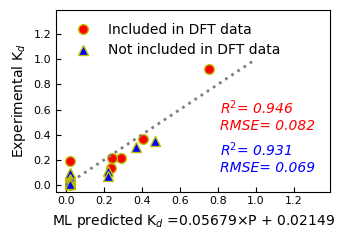

In [111]:
%%capture --no-display

temp_K = 273.15+25

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)
#axt = axs.twinx()

fitted_text_line = fr'{fitted_a}$\times$P + {fitted_b}'

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML predicted K$_d$ =' +fitted_text_line, fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

colors = [ plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

x1 = included_data['SMILES']
y1 = included_data['Kd 20C']
x2 = not_included_data['SMILES']
y2 = not_included_data['Kd 20C']
    
sim = predict_rdkfp( list(x1), feature_bdo, model_bdo, scaler=scaler_bdo)
sim = -sim/(2.303*1.987*0.001*temp_K)
sim1 = np.power( 10, sim) ## P

sim = predict_rdkfp( list(x2), feature_bdo, model_bdo, scaler=scaler_bdo)
sim = -sim/(2.303*1.987*0.001*temp_K)
sim2 = np.power( 10, sim) ## P

if_P_to_Kd = True
if if_P_to_Kd:
    sim1 = fitted_a*sim1 + fitted_b
    sim2 = fitted_a*sim2 + fitted_b

color, label = 'r','Included in DFT data'
axs.plot(sim1, y1, color=color, label=label, lw=2, ls='', marker='o', ms=7, markeredgecolor='y',) 

color, label = 'b','Not included in DFT data'
axs.plot(sim2, y2, color=color, label=label, lw=2, ls='', marker='^', ms=7, markeredgecolor='y',) 

axs.set_xlim([-0.05, 1.39])
axs.set_ylim([-0.05, 1.39])
axs.legend(fontsize=10, frameon=False, loc='upper left', ncol=1)

## Fitting
from scipy.optimize import curve_fit

def func(x,a,b):
    #return a*np.exp(b*x+c)
    return  a*x+b 
    #return a*np.log(x)+b

# Both converted data
xdat = np.array( list(sim1)+list(sim2) )
ydat = np.array( list(y1)+list(y2) )
popt, pcov = curve_fit(func, xdat,ydat, maxfev=1000)
#display(popt, pcov)
display('Fit RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )
display( 'Check if overfitted:', np.linalg.cond(pcov), np.diag(pcov) )
display('Real RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )

x_trend_line = np.linspace( min(xdat), max(xdat),50 )
y_trend_line = func(x_trend_line, *popt)
#axs.plot( x_trend_line, y_trend_line, ls=':',marker='',lw=2,color='gray')
axs.plot( [0,1], [0,1], ls=':',marker='',lw=2,color='gray')

display('========= Both ==========')
corr, _ = pearsonr( xdat,ydat )
r2 = metrics.r2_score( xdat,ydat ) 
rmse = metrics.root_mean_squared_error( xdat,ydat, )#squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)


display('========= 1 ==========')
corr, _ = pearsonr( sim1,y1 )
r2 = metrics.r2_score(  sim1,y1) 
rmse = metrics.root_mean_squared_error(  sim1,y1, )#squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)
line1 = f'R$^2$= {round(corr,3):.3f} \nRMSE= {round(rmse,3):.3f} \n'
line1 = f'R$^2$= {round(0.946,3):.3f} \nRMSE= {round(0.082,3):.3f} \n'


display('========= 2 ==========')
corr, _ = pearsonr( sim2,y2 )
r2 = metrics.r2_score(  sim2,y2) 
rmse = metrics.root_mean_squared_error(  sim2,y2, )#squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)
line2 = f'R$^2$= {round(corr,3)} \nRMSE= {round(rmse,3)} \n'

axs.text(0.6, 0.25, line1, style='italic', fontsize=10, transform = axs.transAxes, color='r')
axs.text(0.6, 0.02, line2, style='italic', fontsize=10, transform = axs.transAxes, color='b')

plt.savefig('Compare_ML_2.png', dpi=800)
plt.show()

,Solvent,MW (g/mol),Kd 20C,SMILES,P_BDO,K_BDO
0,2-Methyl-1-butanol,88.15,0.62,CCC(C)CO,11.67,0.68
1,3-Methyl-1-butanol,88.15,0.60,CC(C)CCO,11.36,0.67
2,3-Pentanol,88.15,0.52,CCC(CC)O,9.86,0.58
3,2-Ethyl-1-butanol,102.17,0.35,CCC(CC)CO,7.24,0.43
4,3-Hexanol,102.17,0.32,CCCC(CC)O,7.37,0.44
5,2-Cyclohexylethanol,128.22,0.35,C1CCC(CC1)CCO,4.02,0.25
6,"2-Ethyl-1,3-hexanediol",146.23,0.35,CCCC(C(CC)CO)O,0.14,0.03


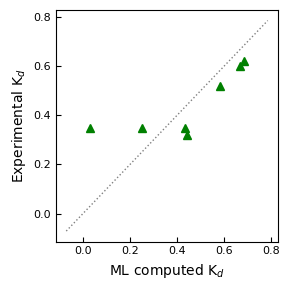

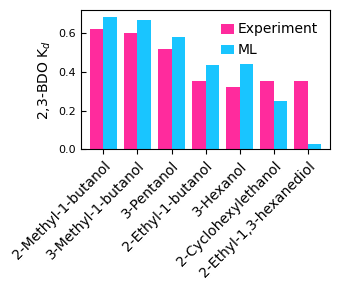

In [112]:
%%capture --no-display

exp_data = 'Experimental_data_2ndGen.csv'

exp_data = pd.read_csv(exp_data)#, index_col=0).set_index('Solvent Name')

predicted_bdo = []
for smi in exp_data['SMILES']:
    pred = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
    predicted_bdo.append( pred[0] )
predicted_bdo = np.array(predicted_bdo)

temp_K = 273.15+25
predicted_bdo = -predicted_bdo/(2.303*1.987*0.001*temp_K)
predicted_bdo = np.power( 10, predicted_bdo) ## P

exp_data['P_BDO'] = predicted_bdo
exp_data['K_BDO'] = predicted_bdo*fitted_a + fitted_b

display( exp_data )

fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)
x,y = exp_data['K_BDO'], exp_data['Kd 20C']
axs.plot(x, y, color='g', label=label, lw=2, ls='', marker='^', ms=6)
axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML computed K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

axlim = ( np.amin([x,y])-0.1, np.amax([x,y])+0.1 )
#axs.set_xlim(axlim)
#axs.set_ylim(axlim)
axs.plot( axlim, axlim, ls=':',marker='',lw=1,color='gray')

plt.show()


fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
#colors = ['magenta','green','darkorange','b','r']
cmap = plt.get_cmap('cool')
colors = cmap(np.linspace(1, 0, len(exp_data)))
labels = exp_data['Solvent']

bars = exp_data.plot(kind='bar', stacked=False, y=['Kd 20C','K_BDO'], ax=axs, xlabel=labels, color=['deeppink','deepskyblue'],
             width=0.8, alpha=0.9)
#for ii,container in enumerate(axs.containers):
#    container.datavalues[0]=-1
#    axs.bar_label(container, rotation=90, fontsize=8, padding=-30 ) #label_type='center')
for n,rect in enumerate(axs.patches):
    x = rect.get_x()
    y = rect.get_height()
    #rect.set_fc( colors[n] )
    #axs.text(x+0.25,y-0.2, str(round(y,2)), ha='left', va='bottom', fontsize=8, color='k', rotation=90) # x=cx+0.1
    
axs.set_xlabel(None,fontsize=10) ## input X name
axs.set_ylabel('2,3-BDO K$_d$' ,fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize=8, axis='y')
axs.set_xticklabels( labels, rotation=45, fontsize=10, ha='right', rotation_mode='anchor')
#axs.set_ylim([0.1,1.4])
#axs.set_xticks( [] )
axs.legend( ['Experiment','ML'], fontsize=10, frameon=False, ncol=1, handlelength=1, handletextpad=0.2, columnspacing=1)
#plt.yscale('log')

plt.savefig("Prediction_2nd_list.png", dpi=800)  
plt.show()

In [114]:
exp_data['K_BDO'] - exp_data['Kd 20C']

0    0.06
1    0.07
2    0.06
3    0.08
4    0.12
5   -0.10
6   -0.32
dtype: float64

'Pearsons correlation: 0.913'

'R2: 0.831'

'RMSE: 0.095'

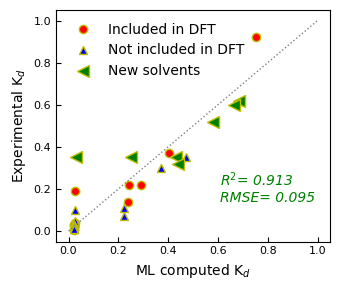

In [27]:
fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

color, label = 'r','Included in DFT'
axs.plot(sim1, y1, color=color, label=label, lw=2, ls='', marker='o', ms=6, markeredgecolor='y') 
color, label = 'b','Not included in DFT'
axs.plot(sim2, y2, color=color, label=label, lw=2, ls='', marker='^', ms=6, markeredgecolor='y')  
color, label = 'g','New solvents'
x,y = exp_data['K_BDO'], exp_data['Kd 20C']
axs.plot(x, y, color=color, label=label, lw=2, ls='', marker='<', ms=8, markeredgecolor='y') 


axs.legend(fontsize=10, frameon=False, loc='upper left', ncol=1)

axs.plot( [-0.,1], [-0.,1], ls=':',marker='',lw=1,color='gray')

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML computed K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

xdat = list(sim1)+list(sim2)+list(x)
ydat = list(y1)+list(y2)+list(y)
corr, _ = pearsonr( xdat,ydat )
r2 = metrics.r2_score(  xdat,ydat ) 
rmse = metrics.root_mean_squared_error(  xdat,ydat,)# squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)

line3 = f'R$^2$= {round(corr,3)} \nRMSE= {round(rmse,3)} \n'
axs.text(0.6, 0.1, line3, style='italic', fontsize=10, transform = axs.transAxes, color='g')

plt.savefig("Prediction_2nd_list_2.png", dpi=800)  
plt.show()

## Consider water?

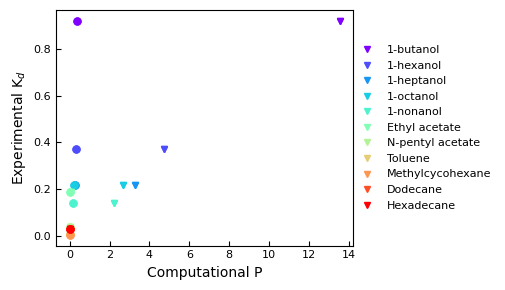

[ 0.06672 -0.07665  0.04659]


In [167]:
## Consider water

temp_K = 273.15+25

fig, axs = plt.subplots(1,1,figsize=(6,3),tight_layout=True,dpi=100)

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

final_x_bdo, final_x_wat, final_y, final_errbar, final_label = [],[],[], [],[]
for n in range( len(included_data) ):
    exp_sr = included_data.iloc[n]
    exp = exp_sr['Kd 20C']
    label = exp_sr['Solvent']
    
    #sim = exp_sr['dG_DFT_bdo']  ## This is the same as DFT at the beginning
    sim = exp_sr['dG_ML_bdo']  ## 
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim_bdo = np.power( 10, sim)  #sim = np.exp(sim)
    
    sim = exp_sr['dG_ML_wat']  ## 
    sim = -sim/(2.303*1.987*0.001*temp_K)  ## logP
    sim_wat = np.power( 10, sim)  #sim = np.exp(sim)
    
    #display( exp_sr, sim )
    axs.plot((sim_bdo,sim_bdo), (exp,exp), color=colors[n], label=label.capitalize(), lw=2, ls='', marker='v', ms=5)
    axs.plot((sim_wat,sim_wat), (exp,exp), color=colors[n], lw=2, ls='', marker='o', ms=5)
    
    #print(sim, exp)
    final_x_bdo.append( sim_bdo )
    final_x_wat.append( sim_wat )
    final_y.append( exp )
    final_errbar.append( [0,0] )
    final_label.append( label.capitalize() )
    
final_x_bdo = np.array(final_x_bdo).flatten()
final_x_wat = np.array(final_x_wat).flatten()

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational P',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
axs.legend(fontsize=8, frameon=False, loc='center right', ncol=1, columnspacing=1, bbox_to_anchor=(1.5, 0.5) )

plt.show()


## Fitting
def func1( xy, a1, a2, a3):
    x1, y1 = xy
    #return a*np.exp(b*x+c)
    return  a1*x1 + a2*y1 + a3
    #return a*np.log(x)+b

popt, pcov = curve_fit(func1, (final_x_bdo,final_x_wat), final_y, maxfev=1000)
y_fit = func1( (final_x_bdo,final_x_wat), *popt)

fitted_abc = np.round( popt, 5 )
print( fitted_abc )

In [168]:
def convert_input2( coeff_abc, bdo, wat):
    a,b,c = coeff_abc
    return  a*bdo + b*wat + c
    

'Fit RMSE error: '

0.044615982089611726

'Check if overfitted:'

27.114218729161472

array([0.00233905, 0.00014481])

'Real RMSE error: '

0.044615982089611726

'Pearsons correlation: 0.974'

'R2: 0.943'

'RMSE: 0.047'

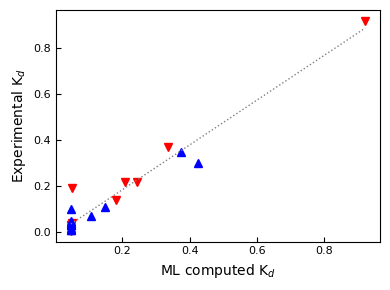

In [169]:
%%capture --no-display

temp_K = 273.15+25

fig, axs = plt.subplots(1,1,figsize=(4,3),tight_layout=True,dpi=100)
#axt = axs.twinx()

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML computed K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

colors = [ plt.cm.rainbow(n) for n in np.linspace(0,1,len(included_data)) ]

x1 = included_data['SMILES']
y1 = included_data['Kd 20C']
b1 = included_data['Solvent']
x2 = not_included_data['SMILES']
y2 = not_included_data['Kd 20C']
b2 = not_included_data['Solvent']
    
sim = predict_rdkfp( list(x1), feature_bdo, model_bdo, scaler=scaler_bdo)
sim = -sim/(2.303*1.987*0.001*temp_K)
sim1_bdo = np.power( 10, sim) ## P

sim = predict_rdkfp( list(x1), feature_wat, model_wat, scaler=scaler_wat)
sim = -sim/(2.303*1.987*0.001*temp_K)
sim1_wat = np.power( 10, sim) ## P

sim = predict_rdkfp( list(x2), feature_bdo, model_bdo, scaler=scaler_bdo)
sim = -sim/(2.303*1.987*0.001*temp_K)
sim2_bdo = np.power( 10, sim) ## P

sim = predict_rdkfp( list(x2), feature_wat, model_wat, scaler=scaler_wat)
sim = -sim/(2.303*1.987*0.001*temp_K)
sim2_wat = np.power( 10, sim) ## P

if_P_to_Kd = True
if if_P_to_Kd:
    sim1 = convert_input2( fitted_abc, sim1_bdo, sim1_wat )
    sim2 = convert_input2( fitted_abc, sim2_bdo, sim2_wat )

color, label = 'r','known'
axs.plot(sim1, y1, color=color, label=label, lw=2, ls='', marker='v', ms=6) 

color, label = 'b','unknown'
axs.plot(sim2, y2, color=color, label=label, lw=2, ls='', marker='^', ms=6) 


## Fitting
from scipy.optimize import curve_fit

def func(x,a,b):
    #return a*np.exp(b*x+c)
    return  a*x+b 
    #return a*np.log(x)+b

xdat = np.array( list(sim1)+list(sim2) )
ydat = np.array( list(y1)+list(y2) )
#axs.set_xlim([-0.1,1])
#axs.set_ylim([-0.1,1])
popt, pcov = curve_fit(func, xdat,ydat, maxfev=1000)

display( 'Fit RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )
display( 'Check if overfitted:', np.linalg.cond(pcov), np.diag(pcov) )
display( 'Real RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )

xdat_fit = np.linspace( min(xdat), max(xdat),50 )
ydat_fit = func(xdat_fit, *popt)
axs.plot( xdat_fit, ydat_fit, ls=':',marker='',lw=1,color='gray')

corr, _ = pearsonr( xdat,ydat )
r2 = metrics.r2_score(  xdat,ydat ) 
rmse = metrics.mean_squared_error(  xdat,ydat, squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)

#plt.savefig('Compare3.png', dpi=800)
plt.show()

In [170]:
for s,e,b in zip(sim1,y1,b1):
    print( s, e, b )
print()
for s,e,b in zip(sim2,y2,b2):
    print( s, e, b )

0.9226732264252704 0.92 1-Butanol
0.33466291337368526 0.37 1-Hexanol
0.2433997672421946 0.22 1-Heptanol
0.2086431336049299 0.22 1-Octanol
0.18065031770821904 0.14 1-Nonanol
0.049548231084306955 0.19 Ethyl acetate
0.04852688152013302 0.04 n-Pentyl acetate
0.04691948816013612 0.01 Toluene
0.04670806389071989 0.005 Methylcycohexane
0.04664506196290293 0.03 Dodecane
0.04663645373246773 0.03 Hexadecane

0.3734308042490235 0.35 2-Hexanol
0.42477836752250037 0.3 4-Methyl-2-pentanol
0.14698375236389238 0.11 3,7-Dimethyl-1-octanol
0.10689436239735176 0.07 Oleyl alcohol
0.04842335795548172 0.1 Isopropyl acetate
0.04815736432832257 0.04 sec-Butyl acetate
0.04814593894781241 0.05 Isobutyl acetate
0.04833304757206133 0.03 Butyl butyrate
0.048430829082733266 0.03 n-Hexyl acetate
0.0471164478974119 0.01 Dibutyl oxalate
0.04737920134729487 0.03 Diethyl adipate
0.047766598523446 0.02 Isopropyl myristate
0.04667530115098347 0.01 tert-Butylcyclohexane


,Solvent,MW (g/mol),Kd 20C,SMILES,P_BDO,P_WAT,K_BDO
0,2-Methyl-1-butanol,88.15,0.62,CCC(C)CO,7.13,0.16,0.51
1,3-Methyl-1-butanol,88.15,0.60,CC(C)CCO,8.12,0.10,0.58
2,3-Pentanol,88.15,0.52,CCC(CC)O,6.30,0.26,0.45
3,2-Ethyl-1-butanol,102.17,0.35,CCC(CC)CO,4.38,0.09,0.33
4,3-Hexanol,102.17,0.32,CCCC(CC)O,4.58,0.19,0.34
5,2-Cyclohexylethanol,128.22,0.35,C1CCC(CC1)CCO,3.70,0.13,0.28
6,"2-Ethyl-1,3-hexanediol",146.23,0.35,CCCC(C(CC)CO)O,1.13,0.01,0.12


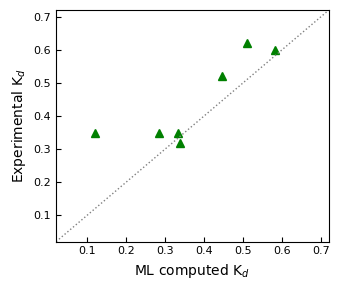

In [411]:
%%capture --no-display

exp_data = 'Experimental_data_2ndGen.csv'

exp_data = pd.read_csv(exp_data)#, index_col=0).set_index('Solvent Name')

predicted_bdo, predicted_wat = [],[]
for smi in exp_data['SMILES']:
    pred = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
    predicted_bdo.append( pred[0] )
    pred = predict_rdkfp( [smi], feature_wat, model_wat, scaler=scaler_wat)
    predicted_wat.append( pred[0] )
predicted_bdo = np.array(predicted_bdo)
predicted_wat = np.array(predicted_wat)
    
temp_K = 273.15+25
predicted_bdo = -predicted_bdo/(2.303*1.987*0.001*temp_K)
predicted_bdo = np.power( 10, predicted_bdo) ## P
predicted_wat = -predicted_wat/(2.303*1.987*0.001*temp_K)
predicted_wat = np.power( 10, predicted_wat) ## P

exp_data['P_BDO'] = predicted_bdo
exp_data['P_WAT'] = predicted_wat
exp_data['K_BDO'] = convert_input2(fitted_abc, predicted_bdo, predicted_wat)

display( exp_data )

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)
x,y = exp_data['K_BDO'], exp_data['Kd 20C']
axs.plot(x, y, color='g', label=label, lw=2, ls='', marker='^', ms=6)
axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML computed K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

axlim = ( np.amin([x,y])-0.1, np.amax([x,y])+0.1 )
axs.set_xlim(axlim)
axs.set_ylim(axlim)

axs.plot( axlim, axlim, ls=':',marker='',lw=1,color='gray')

plt.show()

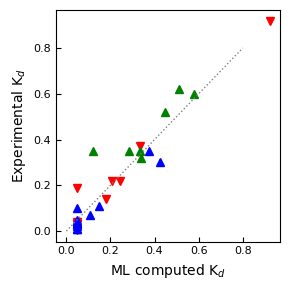

In [172]:
fig, axs = plt.subplots(1,1,figsize=(3,3),tight_layout=True,dpi=100)

color, label = 'r','known'
axs.plot(sim1, y1, color=color, label=label, lw=2, ls='', marker='v', ms=6) 
color, label = 'b','unknown'
axs.plot(sim2, y2, color=color, label=label, lw=2, ls='', marker='^', ms=6)  
color, label = 'g','new'
axs.plot(x, y, color=color, label=label, lw=2, ls='', marker='^', ms=6) 

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML computed K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

axs.plot( [-0.,0.8], [-0.,0.8], ls=':',marker='',lw=1,color='gray')

xdat = list(sim1)+list(sim2)+list(x)
ydat = list(y1)+list(y2)+list(y)
corr, _ = pearsonr( xdat,ydat )
r2 = metrics.r2_score(  xdat,ydat ) 
rmse = metrics.mean_squared_error(  xdat,ydat, squared=False)
display('Pearsons correlation: %.3f' % corr)
display('R2: %.3f' % r2)
display('RMSE: %.3f' % rmse)

plt.show()

In [ ]:
col = ['Solvent','SMILES','Kd 20C']
df1 = included_data[col]
df2 = not_included_data[col]
df3 = exp_data[col]
df1['type']='r'
df2['type']='b'
df3['type']='g'
df_performance = pd.concat([df1,df2,df3],axis=0)
df_performance.to_csv('df_performance.csv')
df_performance

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)

axs.set_ylabel('Experimental \n distribution coefficient',fontsize=10) ## input X name
axs.set_xlabel('ML partition coefficient',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(excluded_data)) ]

for n,d in enumerate(excluded_data): 
    label = d[0]
    color = d[-1] ## colors[n]
    x = d[3]
    y = d[4] 
    if isinstance(y, tuple):
        yerr_lo = np.mean(y)-y[0]
        yerr_hi = y[1]-np.mean(y)
        y= np.mean(y)
        axs.errorbar( x,y, yerr=[[yerr_lo],[yerr_hi]], ecolor=color, capsize=4)
        axs.plot(x, np.mean(y), color=color, label=label, lw=2, ls='', marker='o', ms=6) 
    else:
        axs.plot(x, y, color=color, label=label, lw=2, ls='', marker='o', ms=6) 
    axs.annotate(label, xy=(x, y), fontsize=6)

## Read new solvents

In [28]:
%%capture --no-display

new_solvent1 = pd.read_csv('All_New_Solvents.csv')

good_elements = ['C','H','O','N',]#'S']#,'P']
mask_element = []   ## molecules to keep, keep=True
inchi_column = []
for smi in new_solvent1['SMILES']:
    mol = Chem.MolFromSmiles( smi )
    inchi = Chem.MolToInchi(mol)
    inchi_column.append(inchi)
    
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    if all(e in good_elements for e in element) and '.' not in smi and smi not in list(solvation_data['SMILES']):
        mask_element.append(True) 
    else:
        mask_element.append(False)
        
new_solvent1['Inchi'] = inchi_column
# if we do not consider elements, use this mask. Otherwise, comment it out
#mask_element = ['.' not in smi and smi not in list(solvation_data['SMILES']) for smi in new_solvent['Solvent SMILES']]

new_solvent1 = new_solvent1[mask_element].reset_index(drop=True)
new_solvent1 = new_solvent1.drop_duplicates(subset=['Inchi'])

display( new_solvent1 )

,SMILES,Inchi
0,C1=CC=C(C(=C1)C(CO)O)[N+](=O)[O-],InChI=1S/C8H9NO4/c10-5-8(11)6-3-1-2-4-7(6)9(12...
1,CCOC(C)OCC(CC#CCO)OC(=O)C,InChI=1S/C12H20O5/c1-4-15-11(3)16-9-12(17-10(2...
2,CC(=O)OC(C/C=C\C/C=C\CCCC(=O)OC)CO,InChI=1S/C15H24O5/c1-13(17)20-14(12-16)10-8-6-...
3,CC1(C(=O)CC(C2=CC=CC=C21)CCO)C,InChI=1S/C14H18O2/c1-14(2)12-6-4-3-5-11(12)10(...
4,C1=CC=C(C=C1)CCCO,"InChI=1S/C9H12O/c10-8-4-7-9-5-2-1-3-6-9/h1-3,5..."
...,...,...
1629,CC(=O)CCO,"InChI=1S/C4H8O2/c1-4(6)2-3-5/h5H,2-3H2,1H3"
1630,CC(=O)C(C)(C)O,"InChI=1S/C5H10O2/c1-4(6)5(2,3)7/h7H,1-3H3"
1632,COCC(CO)O,"InChI=1S/C4H10O3/c1-7-3-4(6)2-5/h4-6H,2-3H2,1H3"
1634,CC(=O)CC(C)(C)OC,"InChI=1S/C7H14O2/c1-6(8)5-7(2,3)9-4/h5H2,1-4H3"


In [32]:
%%capture --no-display

# Additional new solvents from previous solubility database
new_solvent2 = pd.read_csv('../../solubililty_general/df_NoWaterSol_dataset.csv', index_col=0)
new_solvent2 = new_solvent2[ ['Solvent SMILES','Solvent Inchi'] ].rename({'Solvent SMILES':'SMILES','Solvent Inchi':'Inchi'}, axis=1)
new_solvent2 = new_solvent2.drop_duplicates(subset=['Inchi'])

good_elements = ['C','H','O','N']#,'S']#,'P']
mask_element = []   ## molecules to keep, keep=True
for smi in new_solvent2['SMILES']:
    mol = Chem.MolFromSmiles( smi )
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    if all(e in good_elements for e in element):
        mask_element.append(True)
    else:
        mask_element.append(False)

new_solvent2 = new_solvent2[mask_element]

new_solvent2

,SMILES,Inchi
0,C1CCCCC1,InChI=1S/C6H12/c1-2-4-6-5-3-1/h1-6H2
7,CCCCCC,"InChI=1S/C6H14/c1-3-5-6-4-2/h3-6H2,1-2H3"
10,CCO,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3"
11,Cc1ccccc1,"InChI=1S/C7H8/c1-7-5-3-2-4-6-7/h2-6H,1H3"
12,CCCCCCCCO,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3"
...,...,...
4381,OCCOCCOCCO,"InChI=1S/C6H14O4/c7-1-3-9-5-6-10-4-2-8/h7-8H,1..."
4409,OCCOCCOCCOCCO,InChI=1S/C8H18O5/c9-1-3-11-5-7-13-8-6-12-4-2-1...
4659,CCN(C=O)CC,"InChI=1S/C5H11NO/c1-3-6(4-2)5-7/h5H,3-4H2,1-2H3"
4671,CCN(CC)C(C)=O,"InChI=1S/C6H13NO/c1-4-7(5-2)6(3)8/h4-5H2,1-3H3"


In [ ]:
# Additional data #3 from ATT Melting point at STP:

file_html =  'Boiling Point (BP) and Melting Point (MP) Reference Table _ AAT Bioquest.html'
with open(file_html,'r') as f1:
    lines = f1.readlines()
lines = lines[0]
lines = lines.split('td>')

index = 0
while "(+)-(1s)-Menthyl Acetate" not in lines[index]:
    index+=1
lines = lines[index:]

lines = [l for l in lines if l!='<' and "</tr>" not in l]

index = len(lines)-1
while "103-105</" not in lines[index]:
    index-=1
lines = lines[:index+1]

lines = np.reshape( lines, (-1,4) )


def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

    
name_list= []
for l in lines:
    mp = l[-1][:-2]
    if is_float( mp ): ## if this mp data exists as a number
        name_list.append( l[0][:-2] )
    elif '-' in mp:
        mp = mp.split('-')
        if is_float( mp[0] ):
            if float(mp[0])<20:  ## if MP says it is a liquid
                name_list.append( l[0][:-2] )
    elif 'Â' not in mp:
        print( mp )
        
""" This is too slow to do it here. Move to HPC if needed"""

smiles = []
for i,m in enumerate( name_list[:] ):
    if i%1000==0:
        print(">>>>>>>>>>>>> ",i)
    try:
        c = pcp.get_compounds(m, 'name')
        if len(c)>0:
            c = [ s.isomeric_smiles for s in c ]
            smiles +=  c
            #print( c )
        else:
            pass
            #print( c, 'has no match')
    except:
        print(m, 'has match issues')

"""
with open('name_list1.log', 'w') as f1:
    for l in name_list:
        f1.write( l+'\n' )
"""
print( len(smiles) )

1-(5-Methyl-Thiophen-2-Yl)-Ethanone has match issues


In [113]:
%%capture --no-display
## Add the Inchi to differentiate SMILES
inchi_solvent = []
for smi_solvent in smiles:
    try:
        mol = Chem.MolFromSmiles(smi_solvent)
        inchi = Chem.MolToInchi(mol)
    except:
        print(smi_solvent, 'is bad solute')
        inchi = 'NotFound'
    inchi_solvent.append(inchi)

new_solvent3 = pd.DataFrame() 
new_solvent3['SMILES'] = smiles
new_solvent3['Inchi'] = inchi_solvent
new_solvent3 = new_solvent3.drop_duplicates(subset=['Inchi'])

good_elements = ['C','H','O','N']#,'S']#,'P']
mask_element = []   ## molecules to keep, keep=True
for smi in new_solvent3['SMILES']:
    mol = Chem.MolFromSmiles( smi )
    element = set([at.GetSymbol() for at in mol.GetAtoms()])  ## GetSymbol , GetAtomicNum
    if all(e in good_elements for e in element):
        mask_element.append(True)
    else:
        mask_element.append(False)

new_solvent3 = new_solvent3[mask_element]

new_solvent3

,SMILES,Inchi
0,CC1(C2CCC(C2)(C1O)C)C,"InChI=1S/C10H18O/c1-9(2)7-4-5-10(3,6-7)8(9)11/..."
1,C[C@@H]1CC[C@@H]([C@H](C1)O)C(C)C,InChI=1S/C10H20O/c1-7(2)9-5-4-8(3)6-10(9)11/h7...
2,C[C@@H]1CC[C@H](C(=O)C1)C(C)C,InChI=1S/C10H18O/c1-7(2)9-5-4-8(3)6-10(9)11/h7...
4,C[C@@]12CC[C@@H](C1)C(C2=O)(C)C,"InChI=1S/C10H16O/c1-9(2)7-4-5-10(3,6-7)8(9)11/..."
5,CC(C(C1=CC=CC=C1)O)NC,InChI=1S/C10H15NO/c1-8(11-2)10(12)9-6-4-3-5-7-...
...,...,...
8952,COC1=CC=C(C=C1)/C=C/C2=CC(=CC(=O)O2)OC,InChI=1S/C15H14O4/c1-17-12-6-3-11(4-7-12)5-8-1...
8953,CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)N,InChI=1S/C17H15N3/c1-12-6-2-5-9-16(12)19-20-17...
8954,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1,InChI=1S/C18H22O5/c1-12-6-5-9-14(19)8-4-2-3-7-...
8955,CC1=C(C(C[C@@H](C1)O)(C)C)/C=C/C(=C/C=C/C(=C/C...,InChI=1S/C40H56O2/c1-29(17-13-19-31(3)21-23-37...


In [116]:
new_solvent = pd.concat([new_solvent1,new_solvent2,new_solvent3], ignore_index=True, axis=0)
print( len(new_solvent) )
new_solvent = new_solvent.drop_duplicates(subset=['Inchi'])
new_solvent

7188


,SMILES,Inchi
0,C1=CC=C(C(=C1)C(CO)O)[N+](=O)[O-],InChI=1S/C8H9NO4/c10-5-8(11)6-3-1-2-4-7(6)9(12...
1,CCOC(C)OCC(CC#CCO)OC(=O)C,InChI=1S/C12H20O5/c1-4-15-11(3)16-9-12(17-10(2...
2,CC(=O)OC(C/C=C\C/C=C\CCCC(=O)OC)CO,InChI=1S/C15H24O5/c1-13(17)20-14(12-16)10-8-6-...
3,CC1(C(=O)CC(C2=CC=CC=C21)CCO)C,InChI=1S/C14H18O2/c1-14(2)12-6-4-3-5-11(12)10(...
4,C1=CC=C(C=C1)CCCO,"InChI=1S/C9H12O/c10-8-4-7-9-5-2-1-3-6-9/h1-3,5..."
...,...,...
7183,COC1=CC=C(C=C1)/C=C/C2=CC(=CC(=O)O2)OC,InChI=1S/C15H14O4/c1-17-12-6-3-11(4-7-12)5-8-1...
7184,CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)N,InChI=1S/C17H15N3/c1-12-6-2-5-9-16(12)19-20-17...
7185,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1,InChI=1S/C18H22O5/c1-12-6-5-9-14(19)8-4-2-3-7-...
7186,CC1=C(C(C[C@@H](C1)O)(C)C)/C=C/C(=C/C=C/C(=C/C...,InChI=1S/C40H56O2/c1-29(17-13-19-31(3)21-23-37...


In [122]:
new_solvent.to_csv('Summary_new_solvent.csv')


## Get summarized solvent

In [28]:
new_solvent = pd.read_csv('Summary_new_solvent.csv', index_col=0 )
new_solvent

,SMILES,Inchi
0,C1=CC=C(C(=C1)C(CO)O)[N+](=O)[O-],InChI=1S/C8H9NO4/c10-5-8(11)6-3-1-2-4-7(6)9(12...
1,CCOC(C)OCC(CC#CCO)OC(=O)C,InChI=1S/C12H20O5/c1-4-15-11(3)16-9-12(17-10(2...
2,CC(=O)OC(C/C=C\C/C=C\CCCC(=O)OC)CO,InChI=1S/C15H24O5/c1-13(17)20-14(12-16)10-8-6-...
3,CC1(C(=O)CC(C2=CC=CC=C21)CCO)C,InChI=1S/C14H18O2/c1-14(2)12-6-4-3-5-11(12)10(...
4,C1=CC=C(C=C1)CCCO,"InChI=1S/C9H12O/c10-8-4-7-9-5-2-1-3-6-9/h1-3,5..."
...,...,...
7183,COC1=CC=C(C=C1)/C=C/C2=CC(=CC(=O)O2)OC,InChI=1S/C15H14O4/c1-17-12-6-3-11(4-7-12)5-8-1...
7184,CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)N,InChI=1S/C17H15N3/c1-12-6-2-5-9-16(12)19-20-17...
7185,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1,InChI=1S/C18H22O5/c1-12-6-5-9-14(19)8-4-2-3-7-...
7186,CC1=C(C(C[C@@H](C1)O)(C)C)/C=C/C(=C/C=C/C(=C/C...,InChI=1S/C40H56O2/c1-29(17-13-19-31(3)21-23-37...


In [ ]:
# Read model and features
model_bdo = joblib.load('model_bdo.pkl')
scaler_bdo = joblib.load('scaler_bdo.pkl')
with open('feature_bdo.json', 'r') as f1:
    feature_bdo = json.load(f1)
    
model_wat = joblib.load('model_wat.pkl')
scaler_wat = joblib.load('scaler_wat.pkl')
with open('feature_wat.json', 'r') as f1:
    feature_wat = json.load(f1)

In [29]:
%%capture --no-display

predicted_bdo = []
for smi in new_solvent['SMILES']:
    pred = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
    predicted_bdo.append( pred )


In [30]:
predicted_bdo = [ p[0] if p is not None else p for p in predicted_bdo ]

new_solvent['deltaG_predicted'] = predicted_bdo
new_solvent

,SMILES,Inchi,deltaG_predicted
0,C1=CC=C(C(=C1)C(CO)O)[N+](=O)[O-],InChI=1S/C8H9NO4/c10-5-8(11)6-3-1-2-4-7(6)9(12...,1.68
1,CCOC(C)OCC(CC#CCO)OC(=O)C,InChI=1S/C12H20O5/c1-4-15-11(3)16-9-12(17-10(2...,3.28
2,CC(=O)OC(C/C=C\C/C=C\CCCC(=O)OC)CO,InChI=1S/C15H24O5/c1-13(17)20-14(12-16)10-8-6-...,3.35
3,CC1(C(=O)CC(C2=CC=CC=C21)CCO)C,InChI=1S/C14H18O2/c1-14(2)12-6-4-3-5-11(12)10(...,1.50
4,C1=CC=C(C=C1)CCCO,"InChI=1S/C9H12O/c10-8-4-7-9-5-2-1-3-6-9/h1-3,5...",-0.80
...,...,...,...
7183,COC1=CC=C(C=C1)/C=C/C2=CC(=CC(=O)O2)OC,InChI=1S/C15H14O4/c1-17-12-6-3-11(4-7-12)5-8-1...,2.84
7184,CC1=CC=CC=C1N=NC2=C(C=CC3=CC=CC=C32)N,InChI=1S/C17H15N3/c1-12-6-2-5-9-16(12)19-20-17...,0.46
7185,C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1,InChI=1S/C18H22O5/c1-12-6-5-9-14(19)8-4-2-3-7-...,3.52
7186,CC1=C(C(C[C@@H](C1)O)(C)C)/C=C/C(=C/C=C/C(=C/C...,InChI=1S/C40H56O2/c1-29(17-13-19-31(3)21-23-37...,1.29


In [31]:
temp_K=273.15+25

#predicted_bdo = predict_rdkfp( list(new_solvent['SMILES']), feature_bdo, model_bdo, scaler=scaler_bdo)
predicted_bdo = new_solvent['deltaG_predicted'] 
predicted_bdo = -predicted_bdo/(2.303*1.987*0.001*temp_K)
predicted_bdo = np.power( 10, predicted_bdo) ## P

new_solvent['P_bdo'] = predicted_bdo
new_solvent = new_solvent.sort_values('P_bdo')

new_solvent['K_bdo'] = new_solvent['P_bdo']*fitted_a + fitted_b

new_solvent

,SMILES,Inchi,deltaG_predicted,P_bdo,K_bdo
4543,C1CCC(CC1)C2CCCCC2,InChI=1S/C12H22/c1-3-7-11(8-4-1)12-9-5-2-6-10-...,4.04,0.00,0.02
5929,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,InChI=1S/C29H60/c1-3-5-7-9-11-13-15-17-19-21-2...,4.04,0.00,0.02
5142,CCCCCCCCCCCCCCCCCCCCCCCCCC,InChI=1S/C26H54/c1-3-5-7-9-11-13-15-17-19-21-2...,4.04,0.00,0.02
5102,CCCCCCCCCCCCCCCCC,InChI=1S/C17H36/c1-3-5-7-9-11-13-15-17-16-14-1...,4.04,0.00,0.02
4696,CCCCCCCCCCCCCCCCCCCCCC,InChI=1S/C22H46/c1-3-5-7-9-11-13-15-17-19-21-2...,4.04,0.00,0.02
...,...,...,...,...,...
1536,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.64,15.95,0.93
3468,C=CCO,"InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2",-1.65,16.08,0.93
1517,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.65,16.23,0.94
1510,CCO,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",-1.66,16.50,0.96


In [39]:
new_solvent.to_csv('Summary_new_solvent_predicted.csv')

In [41]:
new_solvent = pd.read_csv('Summary_new_solvent_predicted.csv', index_col=0 ).reset_index(drop=True)
new_solvent = new_solvent[ new_solvent['K_bdo']<2 ]  ## Just checking ...
new_solvent

,SMILES,Inchi,deltaG_predicted,P_bdo,K_bdo
0,C1CCC(CC1)C2CCCCC2,InChI=1S/C12H22/c1-3-7-11(8-4-1)12-9-5-2-6-10-...,4.04,0.00,0.02
1,CCCCCCCCCCCCCCCCCCCCCCCCCCCCC,InChI=1S/C29H60/c1-3-5-7-9-11-13-15-17-19-21-2...,4.04,0.00,0.02
2,CCCCCCCCCCCCCCCCCCCCCCCCCC,InChI=1S/C26H54/c1-3-5-7-9-11-13-15-17-19-21-2...,4.04,0.00,0.02
3,CCCCCCCCCCCCCCCCC,InChI=1S/C17H36/c1-3-5-7-9-11-13-15-17-16-14-1...,4.04,0.00,0.02
4,CCCCCCCCCCCCCCCCCCCCCC,InChI=1S/C22H46/c1-3-5-7-9-11-13-15-17-19-21-2...,4.04,0.00,0.02
...,...,...,...,...,...
6712,CC(C)O,"InChI=1S/C3H8O/c1-3(2)4/h3-4H,1-2H3",-1.64,15.95,0.93
6713,C=CCO,"InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2",-1.65,16.08,0.93
6714,CCCO,"InChI=1S/C3H8O/c1-2-3-4/h4H,2-3H2,1H3",-1.65,16.23,0.94
6715,CCO,"InChI=1S/C2H6O/c1-2-3/h3H,2H2,1H3",-1.66,16.50,0.96


In [44]:
display( new_solvent[ new_solvent['SMILES'] == 'CCCCCCO' ] ) # 1-hexanol
display( new_solvent[ new_solvent['SMILES'] == 'CCCCO' ] ) # 1-butanol

,SMILES,Inchi,deltaG_predicted,P_bdo,K_bdo
6659,CCCCCCO,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3",-1.13,6.75,0.40


,SMILES,Inchi,deltaG_predicted,P_bdo,K_bdo
6708,CCCCO,"InChI=1S/C4H10O/c1-2-3-4-5/h5H,2-4H2,1H3",-1.52,12.90,0.75


0.4048674652890917


0.4048674652890917 0.7539965156449919


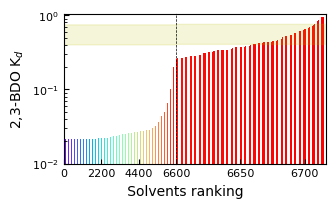

In [115]:
y = new_solvent['K_bdo']
x = np.arange(len(y))
#m = solvation_bdo.index #['Solvent Name']

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(x)) ]

fig, axs = plt.subplots(1,2,figsize=(3.5,2),width_ratios=[3,4], )#tight_layout=True,dpi=100)
fig.subplots_adjust(wspace=0.0, bottom=0.2, left=0.2, right=0.95, top=0.95)

axs[0].bar(x,y, color=colors, width=0.5) 
axs[1].bar(x,y, color=colors, width=0.5)   

split_line_loc = 6600
axs[1].plot( (split_line_loc,split_line_loc) , (0,10), color='k', lw=0.5, ls='--')   

axs[0].set_xlim(0, split_line_loc)
axs[1].set_xlim(split_line_loc, np.amax(x)+1)
axs[0].set_ylim( [0.01, np.amax(y)])
axs[1].set_ylim( [0.01, np.amax(y)])

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].set_xlabel(' '*30+'Solvents ranking',fontsize=10) ## input X name
axs[0].set_ylabel('2,3-BDO K$_d$',fontsize=10) ## input Y name
axs[0].tick_params(which='both', direction='in',labelsize='8')
axs[1].tick_params(which='both', direction='in',labelsize='8')
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
#axs[1].tick_params(labelleft=False) # No number shown
axs[1].get_yaxis().set_visible(False)
axs[0].set_xticks([0, 2200, 4400])

axs[0].spines.right.set_visible(False)
axs[1].spines.left.set_visible(False)
#axs[0].ticklabel_format(style='plain')

lower_limit = new_solvent.iloc[6659]['K_bdo']
upper_limit = new_solvent.iloc[6708]['K_bdo']
print( lower_limit, upper_limit )
y_upper = np.full(len(x), upper_limit )
y_lower = np.full(len(x), lower_limit )
axs[0].fill_between(x, y_lower, y_upper, alpha=0.15, color='y')
axs[1].fill_between(x, y_lower, y_upper, alpha=0.15, color='y')

plt.savefig('Screening_K_BDO.png', dpi=800)
plt.show()


In [104]:
m1 = new_solvent['K_bdo'] < lower_limit 
m2 = new_solvent['K_bdo'] > upper_limit
not_proper = np.any( [m1,m2], axis=0 )

selected = new_solvent[ ~not_proper ]
print( len(selected) )
selected

50


,SMILES,Inchi,deltaG_predicted,P_bdo,K_bdo
6659,CCCCCCO,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3",-1.13,6.75,0.40
6660,CC(C)CCC(C)O,"InChI=1S/C7H16O/c1-6(2)4-5-7(3)8/h6-8H,4-5H2,1...",-1.14,6.84,0.41
6661,CC(C(C)(C)C)O,"InChI=1S/C6H14O/c1-5(7)6(2,3)4/h5,7H,1-4H3",-1.14,6.86,0.41
6662,CC(COC)O,"InChI=1S/C4H10O2/c1-4(5)3-6-2/h4-5H,3H2,1-2H3",-1.14,6.87,0.41
6663,CC(=C=CCC=C)CO,"InChI=1S/C8H12O/c1-3-4-5-6-8(2)7-9/h3,5,9H,1,4...",-1.14,6.90,0.41
6664,C=C/C=C/CCCCO,"InChI=1S/C8H14O/c1-2-3-4-5-6-7-8-9/h2-4,9H,1,5...",-1.15,6.97,0.42
6665,CC/C(=C\CCO)/C,"InChI=1S/C7H14O/c1-3-7(2)5-4-6-8/h5,8H,3-4,6H2...",-1.15,6.98,0.42
6666,CC(CN(C)C)O,"InChI=1S/C5H13NO/c1-5(7)4-6(2)3/h5,7H,4H2,1-3H3",-1.16,7.08,0.42
6667,CCC(=C=C)CO,"InChI=1S/C6H10O/c1-3-6(4-2)5-7/h7H,1,4-5H2,2H3",-1.16,7.12,0.43
6668,CCCC(C)CO,"InChI=1S/C6H14O/c1-3-4-6(2)5-7/h6-7H,3-5H2,1-2H3",-1.17,7.21,0.43


In [95]:
names_new = []
values_new = []
for smi,dat in zip( selected['SMILES'], selected['K_bdo'] ):
    results = pcp.get_compounds(smi, 'smiles')
    if len(results)==1:
        names_new.append( results[0].synonyms )
        values_new.append( dat )
        print( smi, results, dat )
    else:
        smiles.append( None )
        values_new.append( dat )
        print( smi, dat )

CCCCCCO [Compound(8103)] 0.4048674652890917
CC(C)CCC(C)O [Compound(12323)] 0.4098624393130757
CC(C(C)(C)C)O [Compound(10045)] 0.4109809061253654
CC(COC)O [Compound(7900)] 0.4114468124014838
CC(=C=CCC=C)CO [Compound(12452946)] 0.413457491736116
C=C/C=C/CCCCO [Compound(10419192)] 0.4171100483828977
CC/C(=C\CCO)/C [Compound(12544010)] 0.4179672434976909
CC(CN(C)C)O [Compound(37511)] 0.4238234930647895
CCC(=C=C)CO [Compound(10909495)] 0.4261025352062277
CCCC(C)CO [Compound(7745)] 0.430800139843368
CCC(C)(CC)O [Compound(6493)] 0.4316439762453217
CCC(CC)CO [Compound(7358)] 0.4327408382201458
CCC(C(C)C)O [Compound(11264)] 0.4327726424009451
CC(=CC/C=C/CO)C [Compound(10866338)] 0.4369759194440549
CC(C)/C=C/CCO [Compound(13494569)] 0.4391822956448768
CCCC(CC)O [Compound(12178)] 0.4400930703240125
CC(=CCCCO)C [Compound(11789174)] 0.4476198459467967
C/C(=C\CC=C)/CO [Compound(24973758)] 0.4503634873539566
C/C(=C\CCO)/C=C [Compound(11007853)] 0.4515789108423151
CCC/C=C/CCO [Compound(5318018)] 0.454

In [96]:
for v,m in zip(values_new,names_new):
    print( v, m[:3] )

0.4048674652890917 ['1-Hexanol', 'Hexyl alcohol', 'Hexan-1-ol']
0.4098624393130757 ['5-METHYL-2-HEXANOL', '5-Methylhexan-2-ol', '627-59-8']
0.4109809061253654 ['3,3-DIMETHYL-2-BUTANOL', '464-07-3', 'Pinacolyl alcohol']
0.4114468124014838 ['1-Methoxy-2-propanol', '107-98-2', '1-Methoxypropan-2-ol']
0.413457491736116 ['2-methyl-2,3,6-heptatrien-1-ol', '2-methyl-hepta-2,3,6-trien-1-ol']
0.4171100483828977 ['SCHEMBL875407', '(5E)-5,7-octadien-1-ol', '(5E)-octa-5,7-dien-1-ol']
0.4179672434976909 ['(3Z)-4-methyl-3-hexen-1-ol', 'OPKSUXHYTUKXGR-ALCCZGGFSA-', '(Z)-4-methyl-hex-3-en-1-ol']
0.4238234930647895 ['1-Dimethylamino-2-propanol', '108-16-7', 'Dimepranol']
0.4261025352062277 ['2-ethyl-buta-2,3-dien-1-ol', '761-05-7', '2,3-Butadien-1-ol, 2-ethyl-']
0.430800139843368 ['2-METHYL-1-PENTANOL', '2-Methylpentan-1-ol', '105-30-6']
0.4316439762453217 ['3-METHYL-3-PENTANOL', '77-74-7', '3-Methylpentan-3-ol']
0.4327408382201458 ['2-Ethyl-1-butanol', '2-Ethylbutan-1-ol', '97-95-0']
0.432772642400945

In [105]:
selected['PubChem Name 1'] = [m[0] for m in names_new ]
selected['PubChem Name 2'] = [m[1] for m in names_new ]
#selected.to_csv('selected_solvent_predicted.csv')
#print( selected.to_string() )
selected.drop( 'Inchi',axis=1 ).to_csv('selected_solvent_predicted.csv')
selected.head()

,SMILES,Inchi,deltaG_predicted,P_bdo,K_bdo,PubChem Name 1,PubChem Name 2
6659,CCCCCCO,"InChI=1S/C6H14O/c1-2-3-4-5-6-7/h7H,2-6H2,1H3",-1.13,6.75,0.40,1-Hexanol,Hexyl alcohol
6660,CC(C)CCC(C)O,"InChI=1S/C7H16O/c1-6(2)4-5-7(3)8/h6-8H,4-5H2,1...",-1.14,6.84,0.41,5-METHYL-2-HEXANOL,5-Methylhexan-2-ol
6661,CC(C(C)(C)C)O,"InChI=1S/C6H14O/c1-5(7)6(2,3)4/h5,7H,1-4H3",-1.14,6.86,0.41,"3,3-DIMETHYL-2-BUTANOL",464-07-3
6662,CC(COC)O,"InChI=1S/C4H10O2/c1-4(5)3-6-2/h4-5H,3H2,1-2H3",-1.14,6.87,0.41,1-Methoxy-2-propanol,107-98-2
6663,CC(=C=CCC=C)CO,"InChI=1S/C8H12O/c1-3-4-5-6-8(2)7-9/h3,5,9H,1,4...",-1.14,6.90,0.41,"2-methyl-2,3,6-heptatrien-1-ol","2-methyl-hepta-2,3,6-trien-1-ol"


# Experimental T

,Class,Solvent,MW (g/mol),Kd 20C,Kd 40C,Kd 60C,SMILES
0,Alcohol,1-Butanol,74.12,0.920,1.03,1.13,CCCCO
1,Alcohol,1-Hexanol,102.17,0.370,0.47,0.48,CCCCCCO
2,Alcohol,2-Hexanol,102.17,0.350,0.41,0.47,CCCCC(C)O
3,Alcohol,4-Methyl-2-pentanol,102.17,0.300,0.41,0.44,CC(C)CC(C)O
4,Alcohol,1-Heptanol,116.20,0.220,0.29,0.34,CCCCCCCO
5,Alcohol,1-Octanol,130.23,0.220,0.27,0.30,CCCCCCCCO
6,Alcohol,1-Nonanol,144.25,0.140,0.20,0.20,CCCCCCCCCO
7,Alcohol,"3,7-Dimethyl-1-octanol",158.28,0.110,0.17,0.20,CC(C)CCCC(C)CCO
8,Alcohol,Oleyl alcohol,268.50,0.070,0.07,0.11,CCCCCCCC/C=C\CCCCCCCCO
9,Ester,Ethyl acetate,88.11,0.190,0.20,0.22,CCOC(=O)C


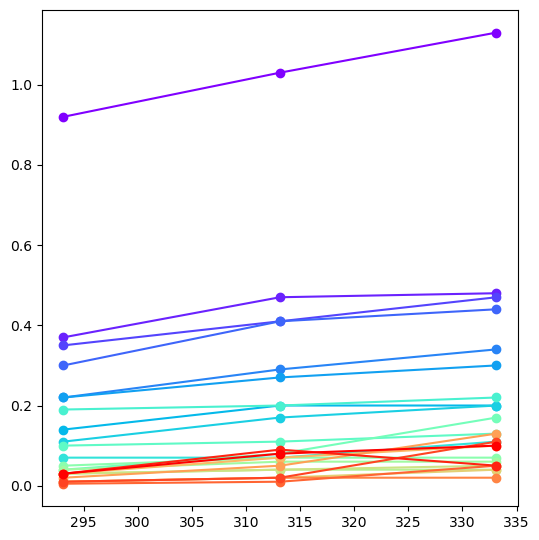

In [21]:
exp_data = 'Experimental_data.csv'

exp_data = pd.read_csv(exp_data)#, index_col=0).set_index('Solvent Name')
display( exp_data )

T = [ temp+273.15 for temp in [20.,40.,60.] ]
#T = np.reciprocal( [ temp+273.15 for temp in [20.,40.,60.] ] )

kd = exp_data[ ['Kd 20C','Kd 40C','Kd 60C']].to_numpy()

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(kd)) ]

fig, axs = plt.subplots(1,1,figsize=(5.5,5.5),tight_layout=True,dpi=100)

for y,c in zip(kd,colors):
    axs.plot(T,y, '-o',c=c)  

xlim = [ np.amin(T), np.amax(T) ]
#axs.set_xlim(xlim)

plt.show()


In [ ]:
kd = exp_data[ ['Solvent','Kd 20C','Kd 40C','Kd 60C']]

smiles = [ ]
for k in kd['Solvent']:
    smi = pcp.get_compounds(k, 'name')
    if len(smi)==1:
        smi = smi[0].isomeric_smiles
        smiles.append(smi)
kd['SMILES'] = smiles
kd


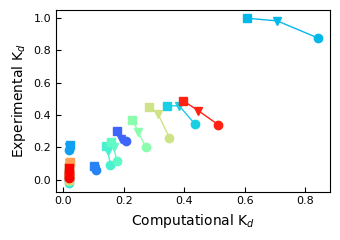

In [51]:
a,b = 0.052, 0.018  # This is the number for 25C

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)

results = [ ]  # 20 40 60
temp_K = np.array( [ temp+273.15 for temp in [20.,40.,60.] ] )
markers = ['o','v','s']

for n,smi in enumerate( kd['SMILES'] ):
    sim = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
    sim = -sim[0]/(2.303*1.987*0.001*temp_K) 
    sim = np.power( 10, sim) ## P
    results.append( sim )

results_exp = kd[ ['Kd 20C','Kd 40C','Kd 60C']].to_numpy()
names = list( kd['Solvent'] )

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(names)) ]
for n,(m, exp, sim) in enumerate( zip(names, results_exp, results) ): 
    sim = a*sim +b
    axs.plot(sim, exp, color=colors[n], lw=1, ls='-', marker='', ms=6)
    for x,y,m in zip(sim,exp,markers):
        axs.plot(x, y, color=colors[n], lw=2, ls='', marker=m, ms=6)

    label = m.upper()
    #axs.annotate(label, xy=(sim[0], exp[0]), fontsize=6)

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

#xlim = [0, 0.4]
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
#axs.legend(fontsize=6, frameon=False, loc=10, ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1.25) )

#axs.legend(fontsize=7, frameon=False, loc=4, ncol=2)
    
#plt.savefig('Compare.png', dpi=800)
plt.show()

In [56]:
# What if we fit every T on their own

# Get the ML delta G
results = []
for n,smi in enumerate( kd['SMILES'] ):
    sim = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
    #sim = -sim[0]/(2.303*1.987*0.001*temp_K) 
    #sim = np.power( 10, sim) ## P
    results.append( sim[0] )
kd['dG'] = results
kd

,Solvent,Kd 20C,Kd 40C,Kd 60C,SMILES,dG
0,Dodecane,0.03,0.00,0.02,CCCCCCCCCCCC,4.15
1,Hexadecane,0.04,0.00,0.02,CCCCCCCCCCCCCCCC,4.14
2,Isopropyl myristate,0.02,0.01,0.02,CCCCCCCCCCCCCC(=O)OC(C)C,2.40
3,1-Octanol,0.24,0.25,0.30,CCCCCCCCO,-0.75
4,Oleyl alcohol,0.06,0.06,0.08,CCCCCCCC/C=C\CCCCCCCCO,-0.32
5,Ethyl acetate,0.18,0.20,0.21,CCOC(=O)C,1.79
6,1-Butanol,0.88,0.98,1.00,CCCCO,-1.61
7,1-Hexanol,0.34,0.46,0.46,CCCCCCO,-1.21
8,Methylcyclohexane,-0.02,-0.00,0.04,CC1CCCCC1,4.01
9,"3,7-Dimethyl-1-octanol",0.09,0.17,0.21,CC(C)CCCC(C)CCO,-0.57


0 0.04549420947434506 0.020905402481600867
Fit RMSE error:  0.05892900613067507
1 0.06339899397184913 0.0333787506947966
Fit RMSE error:  0.056506887265718925
2 0.07565925692343113 0.04394387560802551
Fit RMSE error:  0.05430245727249037


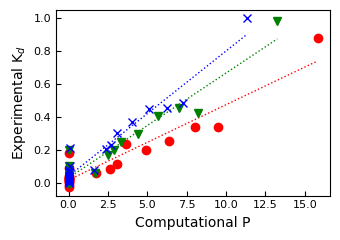

In [96]:
# Plot raw data
from scipy.optimize import curve_fit

def func(x,a,b):
    #return a*np.exp(b*x+c)
    return  a*x+b 
    #return a*np.log(x)+b
    

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)

colors = ['r','g','b']
markers = ['o','v','x']
results_exp = np.transpose( kd[ ['Kd 20C','Kd 40C','Kd 60C']].to_numpy() )
temp_K = np.array( [ temp+273.15 for temp in [20.,40.,60.] ] )

names = list( kd['Solvent'] )

results_sim = kd['dG']

coeff_fit = []
for n,exp in enumerate(results_exp):
    sim = -results_sim/(2.303*1.987*0.001*temp_K[n]) 
    sim = np.power( 10, sim) ## P
    axs.plot(sim, exp, color=colors[n], lw=1, ls='', marker=markers[n], ms=6)
    
    fit_a,fit_b = np.polyfit(sim, exp, 1)
    fit_x = np.array([ min(sim), max(sim) ])
    print(n, fit_a,fit_b)
    coeff_fit.append( [fit_a,fit_b] )
    axs.plot( fit_x, fit_a*fit_x+fit_b, ls=':',marker='',lw=1,color=colors[n])
    
    popt, pcov = curve_fit(func, sim, exp, maxfev=1000)
    print('Fit RMSE error: ', np.sqrt(np.mean((exp-func(sim, *popt))**2)) )

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational P',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
plt.show()

In [68]:
coeff_fit

[[0.04549420947434506, 0.020905402481600867],
 [0.06339899397184913, 0.0333787506947966],
 [0.07565925692343113, 0.04394387560802551]]

In [74]:
a,b = 0.052, 0.018  # This is the number for 25C
smi = 'CCCC(C(CC)CO)O'
sim = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
sim = -sim[0]/(2.303*1.987*0.001*(273.15+25)) 
sim = np.power( 10, sim) ## P
sim = a*sim +b
print( sim )

0.026909330261622077


[0.06406014 0.1318709 ] [[ 5.50483959e-05 -1.04421745e-04]
 [-1.04421745e-04  1.13786190e-03]]
Fit RMSE error:  0.16508700729413261
Check if overfitted: 25.46772722677626 [5.50483959e-05 1.13786190e-03]
Real RMSE error:  0.16508700729413261
Pearsons correlation: 0.848
[  84.56220897   82.28287128 1239.13877368 1497.86725467 1100.68972116
 1219.23408106  999.86254949   39.86790497   54.89835979   13.46099566
   88.69781739    2.74276317   29.95042474    5.89690993   81.80843889
 -190.25340139   74.65530635   49.10498896 -284.9119952    37.60817705
    7.30191749   33.61199082   36.5848811    82.37158659   35.00992598
   79.8734323    36.74059696   60.11300146   36.12330796   53.08152068
   80.49625961]
218.33782488935947
[ 1.61290323  8.33333333 13.46153846 17.14285714  9.375       8.57142857
  8.57142857]
9.581212758056077
Fit RMSE error:  0.0444007721940573


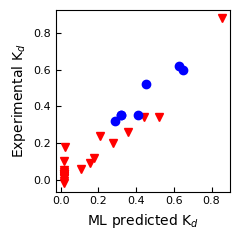

In [93]:
plot_data = [d for d in both_data ]#if d[-1]=='b' ]
excluded_data = [d for d in both_data if d not in plot_data]

fig, axs = plt.subplots(1,1,figsize=(2.5,2.5),tight_layout=True,dpi=100)
#axt = axs.twinx()

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('ML predicted K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(plot_data)) ]

if_P_to_Kd = True

xdat,ydat = [],[]
for n,d in enumerate(plot_data): 
    label = d[0]
    color = d[-1] ## colors[n]
    x = d[3]
    y = d[4] 
    if isinstance(y, tuple):
        yerr_lo = np.mean(y)-y[0]
        yerr_hi = y[1]-np.mean(y)
        y= np.mean(y)
    else:
        if if_P_to_Kd:
            a,b = 0.052, 0.018
            x = a*x+b
        axs.plot(x, y, color='r', label=label, lw=2, ls='', marker='v', ms=6) 
    #axs.annotate(label, xy=(x, y), fontsize=6)
    
    xdat.append(x)
    ydat.append(y)

xdat = np.array(xdat)
ydat = np.array(ydat)

from scipy.optimize import curve_fit

def func(x,a,b):
    #return a*np.exp(b*x+c)
    return  a*x+b 
    #return a*np.log(x)+b

popt, pcov = curve_fit(func, xdat,ydat, maxfev=1000)
print(popt, pcov)
print('Fit RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )
print( 'Check if overfitted:', np.linalg.cond(pcov), np.diag(pcov) )

print('Real RMSE error: ', np.sqrt(np.mean((ydat-func(xdat, *popt))**2)) )

xdat_fit = np.linspace( min(xdat), max(xdat),50 )
ydat_fit = func(xdat_fit, *popt)
#axs.plot( xdat_fit, xdat_fit, ls=':',marker='',lw=1,color='gray')

corr, _ = pearsonr( xdat,ydat )
print('Pearsons correlation: %.3f' % corr)

diff = np.abs(xdat-ydat) / ydat *100
print( diff )
diff = np.mean( diff )
print( diff )

d = [[0.62,0.63],
     [0.60,0.65],
     [0.52,0.45],
     [0.35,0.41],
     [0.32,0.29],
     [0.35,0.32],
     [0.35,0.32],
    ]
d = np.transpose(d)
x, y = d[1], d[0]

diff = np.abs(x-y) / y *100
print( diff )
diff = np.mean( diff )
print( diff )

print('Fit RMSE error: ', np.sqrt(np.mean((x-y)**2)) )

axs.plot(x, y, color='b', label='New', lw=2, ls='', marker='o', ms=6) 

plt.savefig('tmp.png', dpi=800)

plt.show()

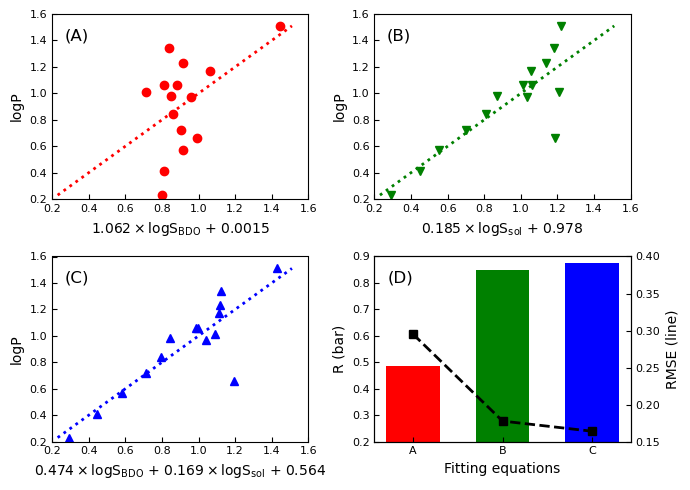

In [59]:
from scipy.optimize import curve_fit
from scipy.stats import pearsonr


def func1( xy, a1, a2, a3):
    x1, y1 = xy
    #return a*np.exp(b*x+c)
    return  a1*x1 + a2*y1 + a3
    #return a*np.log(x)+b

def func2(x,a1,a2):
    return  a1*x + a2 
    

fig, axs = plt.subplots(2,2,figsize=(7,5),tight_layout=True,dpi=100)

df = pd.read_csv('Worksheet.csv', index_col=0)

y = df['logP(dft)']
a = df['logS(solvent)water']
b = df['logS(BDO)solvent']

results = []

#y = np.power( 10, y) 
#a = np.power( 10, a) 
#b = np.power( 10, b) 

## Plot y vs b
popt, pcov = curve_fit(func2, b, y, maxfev=1000)
y_fit = func2( b, *popt)

fitted_y = np.array([ min(y), max(y) ])
fitted_x = fitted_y
axs[0][0].plot( fitted_x, fitted_y, color='r', label='New', lw=2, ls=':', marker='', ms=6) 
axs[0][0].plot( y_fit, y, color='r', label='New', lw=2, ls='', marker='o', ms=6) 

x_axis_name = f'{round(popt[0],3)}'+ r'$\rm \times logS _{BDO}$' + f' + {round(popt[1],4)}'
axs[0][0].set_xlabel(x_axis_name,fontsize=10) 

axs[0][0].text(0.4, 1.4, '(A)', fontsize=12, ha='right')

axs[0][0].set_xlim( 0.2, 1.6 )
axs[0][0].set_ylim( 0.2, 1.6 )

corr, _ = pearsonr( y_fit, y )
r2 = metrics.r2_score( y_fit, y ) 
rmse = metrics.mean_squared_error( y_fit, y, squared=False)

results.append( [popt, corr, r2, rmse] )

## Plot y vs a
popt, pcov = curve_fit(func2, a, y, maxfev=1000)
y_fit = func2( a, *popt)

fitted_y = np.array([ min(y), max(y) ])
fitted_x = fitted_y
axs[0][1].plot( fitted_x, fitted_y, color='g', label='New', lw=2, ls=':', marker='', ms=6) 
axs[0][1].plot( y_fit, y, color='g', label='New', lw=2, ls='', marker='v', ms=6) 

x_axis_name = f'{round(popt[0],3)}'+ r'$\rm \times logS _{sol}$' + f' + {round(popt[1],3)}'
axs[0][1].set_xlabel(x_axis_name,fontsize=10) ## input Y name

axs[0][1].text(0.4, 1.4, '(B)', fontsize=12, ha='right')

axs[0][1].set_xlim( 0.2, 1.6 )
axs[0][1].set_ylim( 0.2, 1.6 )

corr, _ = pearsonr( y_fit, y )
r2 = metrics.r2_score( y_fit, y ) 
rmse = metrics.mean_squared_error( y_fit, y, squared=False)

results.append( [popt,corr, r2, rmse] )

# Plot y vs a and b
popt, pcov = curve_fit(func1, (a,b), y, maxfev=1000)
y_fit = func1( (a,b), *popt)

fitted_y = np.array([ min(y), max(y) ])
fitted_x = fitted_y
axs[1][0].plot( fitted_x, fitted_y, color='b', label='New', lw=2, ls=':', marker='', ms=6) 
axs[1][0].plot( y_fit, y, color='b', label='New', lw=2, ls='', marker='^', ms=6) 

x_axis_name = f'{round(popt[1],3)}'+ r'$\rm\times logS _{BDO}$' + f' + {round(popt[0],3)}'+ r'$\rm\times logS _{sol}$' + f' + {round(popt[2],3)}'
axs[1][0].set_xlabel(x_axis_name,fontsize=10) ## input Y name

axs[1][0].text(0.4, 1.4, '(C)', fontsize=12, ha='right')

axs[1][0].set_xlim( 0.2, 1.6 )
axs[1][0].set_ylim( 0.2, 1.6 )

corr, _ = pearsonr( y_fit, y )
r2 = metrics.r2_score( y_fit, y ) 
rmse = metrics.mean_squared_error( y_fit, y, squared=False)

results.append( [popt,corr, r2, rmse] )

for ax in axs:
    ax[0].set_ylabel('logP',fontsize=10) ## input X name
    ax[0].tick_params(direction='in',labelsize='8')
    ax[1].set_ylabel('logP',fontsize=10) ## input X name
    ax[1].tick_params(direction='in',labelsize='8')

# Plot the performance
bar_colors = ['r','g','b']
#markers = ['o','v','^']
xname = ['A','B','C']
xy = np.transpose([ [results[n][1], results[n][3]] for n,r in enumerate(results) ])

axs[1][1].bar( xname, xy[0], color=bar_colors, width=0.6) 
axs[1][1].set_xlabel('Fitting equations',fontsize=10)
axs[1][1].set_ylabel('R (bar)',fontsize=10)
axs[1][1].set_ylim( 0.2, 0.9 )
axt = axs[1][1].twinx()
axt.tick_params(direction='in',labelsize='8')
axt.plot([0,1,2],xy[1], color='k', lw=2, ls='--', marker='s', ms=6) 
axt.set_ylabel('RMSE (line)',fontsize=10)
axt.set_ylim( 0.15, 0.4 )
axs[1][1].text(0, 0.8, '(D)', fontsize=12, ha='right')

plt.savefig('Solubility_correlation.png', dpi=800)
plt.show()


[0.13584237 0.9804448 ]
0.8446546214701915 0.47832816591376925 0.21553911864607425


,logS(BDO)solvent,logS(solvent)water,logP(dft)
Solvent,,,
2-METHYL-2-PROPANOL,0.90,0.29,0.97
2-METHYL-1-PROPANOL,1.00,0.42,1.17
2-BUTANOL,0.76,0.44,1.06
1-DECANOL,0.75,-3.72,0.23
1-NONANOL,0.76,-2.85,0.41
1-OCTANOL,0.86,-2.30,0.57
1-HEPTANOL,0.85,-1.50,0.72
1-HEXANOL,0.81,-0.90,0.84
1-PENTANOL,0.80,-0.59,0.98


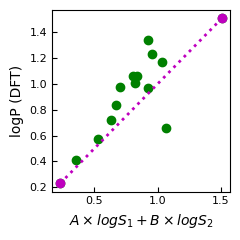

In [166]:
from scipy.optimize import curve_fit

def func1( xy, a1, a2):
    x1, y1 = xy
    #return a*np.exp(b*x+c)
    return  a1*x1 + a2*y1 #+ a3
    #return a*np.log(x)+b
    
fig, axs = plt.subplots(1,1,figsize=(2.5,2.5),tight_layout=True,dpi=100)

df = pd.read_csv('Worksheet.csv', index_col=0)

y1 = df['logP(dft)']
a1 = df['logS(solvent)water']
b1 = df['logS(BDO)solvent']

# The min and max of logP creates the equation:
middle = y1.loc[y1==y1.median()].index[0]
xyz = df.loc[ [y1.idxmin(), y1.idxmax()] ]
#xyz = xyz.to_numpy()
y2 = xyz['logP(dft)']
a2 = xyz['logS(solvent)water']
b2 = xyz['logS(BDO)solvent']

popt, pcov = curve_fit(func1, (a2,b2), y2, maxfev=1000)
print( popt )D

y_fit1 = func1( (a1,b1), *popt)
axs.plot( y_fit1, y1, color='g', label='New', lw=2, ls='', marker='o', ms=6) 

y_fit2 = func1( (a2,b2), *popt)
axs.plot( y_fit2, y2, color='m', label='New', lw=2, ls=':', marker='o', ms=6) 

#plt.show()

axs.set_ylabel('logP (DFT)',fontsize=10) ## input X name
axs.set_xlabel(r'$A\times logS_1+B\times logS_2$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

#plt.savefig('tmp.png', dpi=800)
corr, _ = pearsonr( y_fit1, y1 )
r2 = metrics.r2_score( y_fit1, y1 ) 
rmse = metrics.mean_squared_error( y_fit1, y1, squared=False)
print( corr, r2, rmse )

df

In [69]:
#exp_yes_vol = '042624 Manual Kd results_measured volume change.csv'
#exp_yes_vol = pd.read_csv(exp_yes_vol)#, index_col=0).set_index('Solvent Name')
exp_yes_vol ='''
Dodecane
Hexadecane
Isopropyl myristate
Oleyl alcohol
Methylcyclohexane
3,7-Dimethyl-1-octanol
Dibutyl oxalate
Diethyl adipate
sec-Butyl acetate
Toluene
n-Pentyl acetate
Isopropyl acetate
Butyl butyrate
Isobutyl acetate
n-Hexyl acetate
tert-Butylcyclohexane
'''
solvent_names = [ s for s in exp_yes_vol.split('\n') if len(s)>0 ]

exp_yes_vol='''
4
11.3
10.9
5.7
-2.7
13.3
2.3
6.1
6.4
-0.1
2.9
8.2
1.2
3.1
0.9
8.2
'''
solvent_kd = [ float(s) for s in exp_yes_vol.split('\n') if len(s)>0 ]

smiles = [ ]
for k in solvent_names:
    smi = pcp.get_compounds(k, 'name')
    if len(smi)==1:
        smi = smi[0].isomeric_smiles
        smiles.append(smi)


In [70]:
df_kd_60 = pd.DataFrame() 
df_kd_60['Solvent'] = solvent_names
df_kd_60['SMILES'] = smiles
df_kd_60['Kd 60C'] = solvent_kd
df_kd_60

,Solvent,SMILES,Kd 60C
0,Dodecane,CCCCCCCCCCCC,4.00
1,Hexadecane,CCCCCCCCCCCCCCCC,11.30
2,Isopropyl myristate,CCCCCCCCCCCCCC(=O)OC(C)C,10.90
3,Oleyl alcohol,CCCCCCCC/C=C\CCCCCCCCO,5.70
4,Methylcyclohexane,CC1CCCCC1,-2.70
5,"3,7-Dimethyl-1-octanol",CC(C)CCCC(C)CCO,13.30
6,Dibutyl oxalate,CCCCOC(=O)C(=O)OCCCC,2.30
7,Diethyl adipate,CCOC(=O)CCCCC(=O)OCC,6.10
8,sec-Butyl acetate,CCC(C)OC(=O)C,6.40
9,Toluene,CC1=CC=CC=C1,-0.10


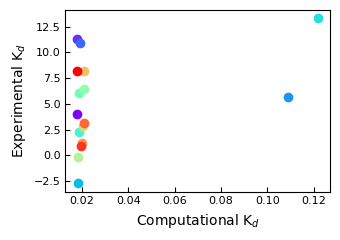

In [71]:
a,b = 0.052, 0.018

fig, axs = plt.subplots(1,1,figsize=(3.5,2.5),tight_layout=True,dpi=100)

temp_K = 273.15+60

results = []
for n,smi in enumerate( df_kd_60['SMILES'] ):
    sim = predict_rdkfp( [smi], feature_bdo, model_bdo, scaler=scaler_bdo)
    sim = -sim[0]/(2.303*1.987*0.001*temp_K) 
    sim = np.power( 10, sim) ## P
    results.append( sim )

df_kd_60['Sim kd 60C'] =results
    
colors = [plt.cm.rainbow(n) for n in np.linspace(0,1,len(results)) ]
for n,(m, exp, sim) in enumerate( zip(df_kd_60['Solvent'], df_kd_60['Kd 60C'], df_kd_60['Sim kd 60C']) ): 
    sim = a*sim +b
    axs.plot(sim, exp, color=colors[n], lw=2, ls='-', marker='o', ms=6)

    label = m.upper()
    #axs.annotate(label, xy=(sim[0], exp[0]), fontsize=6)

axs.set_ylabel('Experimental K$_d$',fontsize=10) ## input X name
axs.set_xlabel('Computational K$_d$',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')

#xlim = [0, 0.4]
#axs.set_xlim(xlim)
#axs.set_ylim(ylim)
#axs.set_xticks([])
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
#axs.legend(fontsize=6, frameon=False, loc=10, ncol=2, columnspacing=1, bbox_to_anchor=(0.5, 1.25) )

#axs.legend(fontsize=7, frameon=False, loc=4, ncol=2)
    
#plt.savefig('Compare.png', dpi=800)
plt.show()

In [ ]:
#predicted_wat = predict_rdkfp( list(new_solvent['Solvent SMILES']), feature_wat, model_wat, scaler=scaler_wat)
#new_solvent['logP_wat'] = predicted_wat

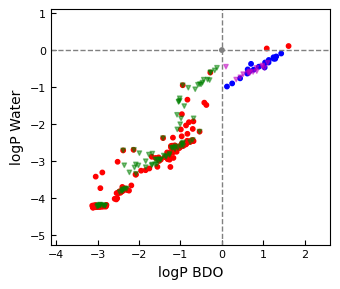

In [126]:
x = solvation_data['logP_bdo']
y = solvation_data['logP_wat']
m = solvation_data.index

idx_water = np.where(m=='WATER')[0][0]

colors = np.array(['gray' if m[i]=='WATER' else 
                   'b' if x[i]>x[idx_water] and y[i]<y[idx_water] else
                   'r' for i in range(len(m))])

fig, axs = plt.subplots(1,1,figsize=(3.5,3),tight_layout=True,dpi=100)

axs.plot([-100,100], [y[idx_water] ,y[idx_water] ], '--', color='gray', lw=1)
axs.plot([x[idx_water] ,x[idx_water] ], [-100,100], '--', color='gray', lw=1)
axs.scatter(x,y, marker='o', c=colors, s=10)  

xlim = [ np.amin(x)-1, np.amax(x)+1 ]
ylim = [ np.amin(y)-1, np.amax(y)+1 ]
axs.set_xlim(xlim)
axs.set_ylim(ylim)

## Add new data
x_new = new_solvent['logP_bdo']
y_new = new_solvent['logP_wat']
m_new = new_solvent['Solvent SMILES']
colors_new = ['m' if x_new[i]>x[idx_water] else 'g' for i in range(len(m_new))]
axs.scatter(x_new,y_new, marker='v', c=colors_new, s=10, alpha=0.5)  

axs.set_xlabel('logP BDO',fontsize=10) ## input X name
axs.set_ylabel('logP Water',fontsize=10) ## input Y name
axs.tick_params(direction='in',labelsize='8')
#axs.text(0.6,0.05, 'Our model', style='italic', fontsize=10, transform = axs.transAxes, color='b')
plt.show()


In [127]:
blue_new = new_solvent[ np.array(colors_new)=='m' ].sort_values('logP_bdo')
blue_new

,Solvent SMILES,logP_bdo,logP_wat
4,CC(O)CCO,0.10,-0.45
66,CC(C)CCCC(C)CCO,0.34,-0.80
15,Cc1ccc(O)c(C)c1,0.45,-0.74
62,Cc1cccc(O)c1,0.51,-0.65
35,OCCc1ccccc1,0.63,-0.62
63,CCCCC(CC)CO,0.66,-0.62
86,OCc1ccccc1,0.67,-0.58
83,OC1CCCCC1,0.68,-0.61
40,CC(C)CC(C)O,0.75,-0.59
3,CCCC(C)CO,0.84,-0.48


In [128]:
names_new = []
for smi in blue_new['Solvent SMILES']:
    results = pcp.get_compounds(smi, 'smiles')
    if len(results)==1:
        names_new.append( results[0].synonyms )
    else:
        smiles.append( None )
        print( smi, results )

In [129]:
candidates_list_2 = [ m[0].capitalize() for m in names_new ]
candidates_list_2


['1,3-butanediol',
 '3,7-dimethyloctan-1-ol',
 '2,4-dimethylphenol',
 'M-cresol',
 '2-phenylethanol',
 '2-ethylhexan-1-ol',
 'Benzyl alcohol',
 'Cyclohexanol',
 '4-methyl-2-pentanol',
 '2-methyl-1-pentanol',
 'Cyclopentanol',
 '2-pentanol',
 'Isoamyl alcohol',
 '2-methyl-2-butanol',
 '2-methyl-1-butanol']

In [130]:
with open('candidate_lists.log','w') as f1:
    f1.write( 'List 1:\n' )
    for c in candidates_list_1:
        f1.write( '  '+c+'\n' )
    f1.write( 'List 2:\n' )
    for c in candidates_list_2:
        f1.write( '  '+c+'\n' )

NameError: name 'candidates_list_1' is not defined